In [1]:
import multiprocessing
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from deap import algorithms, base, creator, tools

%matplotlib notebook

## Problem and Solution Definitions

### Class that holds the problem definition.

This class must implements:
* A method to represent the problem graphically (`__str__`)
* A method to generate a problem instance from an input file (`from_file`).

In [2]:
class Problem:
    def __init__(self, rows, cols, ingredients, cells, pizza):
        self.rows = rows
        self.cols = cols
        self.ingredients = ingredients
        self.cells = cells
        self.pizza = pizza
        self._size = None

    @property
    def size(self):
        if self._size is None:
            self._size = self.rows * self.cols

        return self._size
    
    @classmethod
    def from_file(cls, file_path, *args, **kwargs):
        with open(file_path) as f:
            rows, cols, min_ingredients, max_cells = [int(i) for i in f.readline().split()]
            pizza_data = np.array([list(i.strip()) for i in f.readlines()])

        return cls(rows, cols, min_ingredients, max_cells, pizza_data)

    def __str__(self):
        return '\n'.join([''.join(i) for i in self.pizza])

    def __repr__(self):
        s = f'Problem{{rows={self.rows}, cols={self.cols}, ingredients={self.ingredients}, cells={self.cells}, ' \
            f'size={self.size}}}'
        if self.size < 100:
            s += f'\n{str(self)}'
        return s

### Problem instance

In [3]:
problem = Problem.from_file('input/medium.in')
problem

Problem{rows=200, cols=250, ingredients=4, cells=12, size=50000}

### Class that contains a Solution

The solution to this problem will be represented by a class that can be written and represented, so that following methods must be implemented:
* Serialize the solution into a string (`__str__`).
* Create a string that represents the solution (`__repr__`).
* Write to file the solution (`to_file`).

In [4]:
class Solution:
    """
    A solution for this problem that consists of a structure [[x0, y0, x1, y1]...]
    """
    def __init__(self, data, problem):
        self.data = data
        self.problem = problem

    def to_file(self, file_path):
        with open(file_path, 'w') as f:
            f.write(self.__str__())

    def __str__(self):
        return str(len(self.data)) + '\n' + '\n'.join(' '.join([str(x) for x in s]) for s in self.data)

    def __repr__(self):
        m = np.zeros([self.problem.rows, self.problem.cols], dtype=np.int16)
        for i, s in enumerate(self.data):
            m[s[0]:s[2] + 1, s[1]:s[3] + 1] = i + 1

        return '\n'.join([' '.join([str(j) for j in i]) for i in m])

## Genetic Algorithm's Operators

In order to generate a population for the Genetic Algorithm it's necessary to define following constants:
* `INDIVIDUAL_TYPE`: The base type for an individual.
* `INDIVIDUAL_SIZE`: Initial size of the individual.

Running the algorithm consists of generating and evaluating individuals, so it's required to define functions for:
* Generating a new individual based on problem instance (`generate`).
* Evaluating the current fitness value of the individual (`evaluate`).

If it's necessary, following functions can be defined:
* Mutate individuals (`mutate`).
* Crossover (`crossover`).

### Helpers

In [5]:
def is_individual_valid(individual, problem: Problem) -> bool:
    m = np.zeros([problem.rows, problem.cols], dtype=np.int16)
    for s in individual:
        m[s[0]:s[2] + 1, s[1]:s[3] + 1] += 1
        if m[m > 1].any():
            return False

    return True


def slice_area(data: Tuple[int]) -> int:
    return (data[2] - data[0] + 1) * (data[3] - data[1] + 1)


def is_slice_valid(problem: Problem, data: tuple) -> bool:
    ingredients = set(problem.pizza[data[0]:data[2] + 1, data[1]:data[3] + 1].flatten())
    valid = 0 < slice_area(data) <= problem.cells and len(ingredients) == 2

    return valid

def generate_slice(problem: Problem) -> Tuple[int]:
    valid = False
    while not valid:
        # Generate first point
        xo = random.randint(0, problem.rows - 1)
        yo = random.randint(0, problem.cols - 1)

        # Generate second point
        xf = random.randint(xo, min(xo + problem.cells, problem.rows - 1))
        x_size = xf - xo + 1
        y_size = problem.cells // x_size
        yf = random.randint(yo, min(yo + y_size, problem.cols - 1))

        s = (xo, yo, xf, yf)
        # Check if valid
        valid = is_slice_valid(problem, s)
    
    return s

### Constants

In [6]:
INDIVIDUAL_SIZE = 100
INDIVIDUAL_TYPE = np.ndarray

### Generation

In [7]:
def generate(problem: Problem, size: int) -> Tuple[int]:
    result = []
    for _ in range(size):
        valid = False
        while not valid:
            s = generate_slice(problem)
            valid = is_individual_valid(result + [s], problem)
        result.append(s)

    return creator.Individual(result)

### Evaluation

In [8]:
def evaluate(individual, problem: Problem) -> Tuple[float]:
    if individual.any() and is_individual_valid(individual, problem):
        return float(np.sum(np.apply_along_axis(slice_area, 1, individual))),
    else:
        return 0.0,

### Mutation

In [9]:
ESTIMATED_SOL_LENGTH = int(problem.cols * problem.rows // problem.cells * 0.2)

def mutate(individual, problem) -> Tuple:
    length = len(individual)
    mutation = np.delete(individual, random.sample(range(length), random.randint(0, int(length*0.1))), axis=0)
    mutation = np.append(mutation, [generate_slice(problem) for _ in range(random.randint(1, ESTIMATED_SOL_LENGTH))], axis=0)
    mutation = np.unique(mutation, axis=0)
    
    return creator.Individual(mutation),

### Crossover

In [10]:
def crossover(ind1, ind2) -> Tuple:
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2].copy(), ind1[cxpoint1:cxpoint2].copy()
        
    return ind1, ind2

## DEAP toolbox

### Types

In [11]:
creator.create("Fitness", base.Fitness, weights=(1.0,))
creator.create("Individual", INDIVIDUAL_TYPE, fitness=creator.Fitness)

### Population

In [12]:
toolbox = base.Toolbox()
toolbox.register("individual", generate, size=INDIVIDUAL_SIZE, problem=problem)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Genetic functions

In [13]:
toolbox.register("evaluate", evaluate, problem=problem)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate, problem=problem)
toolbox.register("select", tools.selNSGA2)

### Multiprocessing

In [14]:
pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

## Solution

### Hyperparameters

In [15]:
GENERATIONS = 50000
MU = 20
LAMBDA = 50
CROSSOVER_PROBABILITY = 0.2
MUTATION_PROBABILITY = 0.5

### Run the algorithm

In [16]:
population = toolbox.population(n=MU)

hof = tools.HallOfFame(1, similar=np.array_equal)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

population, log = algorithms.eaMuPlusLambda(population, toolbox, MU, LAMBDA, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, GENERATIONS, stats, halloffame=hof)
# population, log = algorithms.eaMuCommaLambda(population, toolbox, MU, LAMBDA, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, GENERATIONS, stats, halloffame=hof)

gen	nevals	avg     	std          	min   	max   
0  	20    	[844.15]	[24.63386896]	[801.]	[888.]
1  	35    	[864.5] 	[13.34353776]	[847.]	[888.]
2  	30    	[873.]  	[6.73795221] 	[864.]	[888.]
3  	33    	[878.6] 	[5.75673519] 	[874.]	[889.]
4  	34    	[882.55]	[5.45412688] 	[874.]	[891.]
5  	38    	[886.9] 	[1.57797338] 	[885.]	[891.]
6  	34    	[903.5] 	[64.22810911]	[886.]	[1183.]
7  	35    	[919.25]	[87.98117696]	[888.]	[1183.]
8  	34    	[920.5] 	[87.60679197]	[889.]	[1183.]
9  	35    	[946.7] 	[110.011863] 	[889.]	[1183.]
10 	33    	[998.65]	[132.04744413]	[891.]	[1183.]
11 	28    	[1136.45]	[90.02192788] 	[904.]	[1183.]
12 	32    	[1183.15]	[0.65383484]  	[1183.]	[1186.]
13 	36    	[1183.95]	[1.71682847]  	[1183.]	[1188.]
14 	37    	[1184.75]	[1.89406969]  	[1183.]	[1188.]
15 	33    	[1186.8] 	[0.9797959]   	[1186.]	[1188.]
16 	31    	[1187.9] 	[0.43588989]  	[1186.]	[1188.]
17 	34    	[1188.]  	[0.]          	[1188.]	[1188.]
18 	39    	[1188.]  	[0.]          	[1188.]	[1188.]
19 

158	37    	[1892.]  	[0.]          	[1892.]	[1892.]
159	40    	[1892.]  	[0.]          	[1892.]	[1892.]
160	44    	[1892.]  	[0.]          	[1892.]	[1892.]
161	40    	[1892.]  	[0.]          	[1892.]	[1892.]
162	32    	[1892.]  	[0.]          	[1892.]	[1892.]
163	42    	[1892.]  	[0.]          	[1892.]	[1892.]
164	28    	[1892.]  	[0.]          	[1892.]	[1892.]
165	39    	[1892.]  	[0.]          	[1892.]	[1892.]
166	35    	[1892.]  	[0.]          	[1892.]	[1892.]
167	29    	[1892.]  	[0.]          	[1892.]	[1892.]
168	32    	[1892.]  	[0.]          	[1892.]	[1892.]
169	41    	[1892.]  	[0.]          	[1892.]	[1892.]
170	40    	[1892.]  	[0.]          	[1892.]	[1892.]
171	35    	[1892.]  	[0.]          	[1892.]	[1892.]
172	36    	[1892.]  	[0.]          	[1892.]	[1892.]
173	40    	[1892.]  	[0.]          	[1892.]	[1892.]
174	36    	[1892.]  	[0.]          	[1892.]	[1892.]
175	35    	[1892.]  	[0.]          	[1892.]	[1892.]
176	35    	[1892.]  	[0.]          	[1892.]	[1892.]
177	33    	[

316	37    	[2584.15]	[26.72877663] 	[2560.]	[2619.]
317	37    	[2605.95]	[19.41771099] 	[2560.]	[2619.]
318	35    	[2614.5] 	[2.59807621]  	[2613.]	[2619.]
319	37    	[2616.]  	[3.]          	[2613.]	[2619.]
320	38    	[2619.1] 	[0.43588989]  	[2619.]	[2621.]
321	30    	[2619.4] 	[0.8]         	[2619.]	[2621.]
322	38    	[2619.9] 	[0.99498744]  	[2619.]	[2621.]
323	34    	[2621.]  	[0.]          	[2621.]	[2621.]
324	36    	[2621.]  	[0.]          	[2621.]	[2621.]
325	35    	[2621.]  	[0.]          	[2621.]	[2621.]
326	34    	[2621.]  	[0.]          	[2621.]	[2621.]
327	35    	[2621.]  	[0.]          	[2621.]	[2621.]
328	36    	[2621.]  	[0.]          	[2621.]	[2621.]
329	36    	[2621.]  	[0.]          	[2621.]	[2621.]
330	35    	[2621.]  	[0.]          	[2621.]	[2621.]
331	33    	[2621.]  	[0.]          	[2621.]	[2621.]
332	38    	[2621.]  	[0.]          	[2621.]	[2621.]
333	28    	[2621.]  	[0.]          	[2621.]	[2621.]
334	32    	[2621.]  	[0.]          	[2621.]	[2621.]
335	39    	[

474	41    	[2751.]  	[0.]          	[2751.]	[2751.]
475	28    	[2751.]  	[0.]          	[2751.]	[2751.]
476	37    	[2751.]  	[0.]          	[2751.]	[2751.]
477	36    	[2751.]  	[0.]          	[2751.]	[2751.]
478	32    	[2751.]  	[0.]          	[2751.]	[2751.]
479	38    	[2751.]  	[0.]          	[2751.]	[2751.]
480	39    	[2751.]  	[0.]          	[2751.]	[2751.]
481	33    	[2751.]  	[0.]          	[2751.]	[2751.]
482	31    	[2751.]  	[0.]          	[2751.]	[2751.]
483	39    	[2751.]  	[0.]          	[2751.]	[2751.]
484	33    	[2751.]  	[0.]          	[2751.]	[2751.]
485	36    	[2751.]  	[0.]          	[2751.]	[2751.]
486	35    	[2751.]  	[0.]          	[2751.]	[2751.]
487	33    	[2751.]  	[0.]          	[2751.]	[2751.]
488	34    	[2751.]  	[0.]          	[2751.]	[2751.]
489	33    	[2751.]  	[0.]          	[2751.]	[2751.]
490	31    	[2751.05]	[0.21794495]  	[2751.]	[2752.]
491	28    	[2751.15]	[0.35707142]  	[2751.]	[2752.]
492	37    	[2751.25]	[0.4330127]   	[2751.]	[2752.]
493	32    	[

632	35    	[3005.]  	[0.]          	[3005.]	[3005.]
633	37    	[3005.]  	[0.]          	[3005.]	[3005.]
634	36    	[3005.]  	[0.]          	[3005.]	[3005.]
635	37    	[3005.]  	[0.]          	[3005.]	[3005.]
636	34    	[3005.]  	[0.]          	[3005.]	[3005.]
637	33    	[3005.]  	[0.]          	[3005.]	[3005.]
638	38    	[3005.]  	[0.]          	[3005.]	[3005.]
639	36    	[3005.]  	[0.]          	[3005.]	[3005.]
640	35    	[3005.]  	[0.]          	[3005.]	[3005.]
641	32    	[3005.]  	[0.]          	[3005.]	[3005.]
642	33    	[3005.]  	[0.]          	[3005.]	[3005.]
643	33    	[3005.]  	[0.]          	[3005.]	[3005.]
644	34    	[3005.]  	[0.]          	[3005.]	[3005.]
645	33    	[3005.]  	[0.]          	[3005.]	[3005.]
646	35    	[3005.]  	[0.]          	[3005.]	[3005.]
647	37    	[3005.]  	[0.]          	[3005.]	[3005.]
648	40    	[3005.]  	[0.]          	[3005.]	[3005.]
649	39    	[3005.]  	[0.]          	[3005.]	[3005.]
650	33    	[3005.]  	[0.]          	[3005.]	[3005.]
651	35    	[

790	40    	[3065.]  	[0.]          	[3065.]	[3065.]
791	39    	[3065.]  	[0.]          	[3065.]	[3065.]
792	41    	[3067.05]	[8.93574283]  	[3065.]	[3106.]
793	35    	[3069.1] 	[12.3]        	[3065.]	[3106.]
794	34    	[3075.1] 	[17.50399954] 	[3065.]	[3106.]
795	34    	[3081.25]	[19.91199387] 	[3065.]	[3106.]
796	33    	[3097.7] 	[16.36490147] 	[3065.]	[3107.]
797	33    	[3106.05]	[0.21794495]  	[3106.]	[3107.]
798	33    	[3106.1] 	[0.3]         	[3106.]	[3107.]
799	34    	[3106.2] 	[0.4]         	[3106.]	[3107.]
800	36    	[3106.45]	[0.49749372]  	[3106.]	[3107.]
801	39    	[3106.8] 	[0.4]         	[3106.]	[3107.]
802	39    	[3107.]  	[0.]          	[3107.]	[3107.]
803	31    	[3107.]  	[0.]          	[3107.]	[3107.]
804	37    	[3107.]  	[0.]          	[3107.]	[3107.]
805	28    	[3107.]  	[0.]          	[3107.]	[3107.]
806	36    	[3107.]  	[0.]          	[3107.]	[3107.]
807	35    	[3107.]  	[0.]          	[3107.]	[3107.]
808	22    	[3107.]  	[0.]          	[3107.]	[3107.]
809	31    	[

948	28    	[3186.2] 	[0.6]         	[3186.]	[3188.]
949	32    	[3186.4] 	[0.8]         	[3186.]	[3188.]
950	31    	[3186.7] 	[0.9539392]   	[3186.]	[3188.]
951	39    	[3187.4] 	[0.91651514]  	[3186.]	[3188.]
952	39    	[3188.]  	[0.]          	[3188.]	[3188.]
953	32    	[3188.]  	[0.]          	[3188.]	[3188.]
954	37    	[3188.]  	[0.]          	[3188.]	[3188.]
955	37    	[3188.]  	[0.]          	[3188.]	[3188.]
956	38    	[3188.]  	[0.]          	[3188.]	[3188.]
957	34    	[3188.]  	[0.]          	[3188.]	[3188.]
958	41    	[3188.]  	[0.]          	[3188.]	[3188.]
959	29    	[3188.]  	[0.]          	[3188.]	[3188.]
960	30    	[3188.]  	[0.]          	[3188.]	[3188.]
961	34    	[3188.]  	[0.]          	[3188.]	[3188.]
962	32    	[3188.]  	[0.]          	[3188.]	[3188.]
963	39    	[3188.]  	[0.]          	[3188.]	[3188.]
964	42    	[3188.]  	[0.]          	[3188.]	[3188.]
965	36    	[3188.]  	[0.]          	[3188.]	[3188.]
966	32    	[3188.]  	[0.]          	[3188.]	[3188.]
967	35    	[

1104	34    	[3188.]  	[0.]          	[3188.]	[3188.]
1105	30    	[3188.]  	[0.]          	[3188.]	[3188.]
1106	36    	[3188.]  	[0.]          	[3188.]	[3188.]
1107	32    	[3188.]  	[0.]          	[3188.]	[3188.]
1108	36    	[3188.]  	[0.]          	[3188.]	[3188.]
1109	35    	[3188.]  	[0.]          	[3188.]	[3188.]
1110	35    	[3188.]  	[0.]          	[3188.]	[3188.]
1111	31    	[3188.]  	[0.]          	[3188.]	[3188.]
1112	40    	[3188.]  	[0.]          	[3188.]	[3188.]
1113	32    	[3188.]  	[0.]          	[3188.]	[3188.]
1114	35    	[3188.]  	[0.]          	[3188.]	[3188.]
1115	35    	[3188.]  	[0.]          	[3188.]	[3188.]
1116	34    	[3188.]  	[0.]          	[3188.]	[3188.]
1117	39    	[3188.]  	[0.]          	[3188.]	[3188.]
1118	34    	[3188.]  	[0.]          	[3188.]	[3188.]
1119	31    	[3191.9] 	[16.99970588] 	[3188.]	[3266.]
1120	35    	[3195.8] 	[23.4]        	[3188.]	[3266.]
1121	39    	[3195.8] 	[23.4]        	[3188.]	[3266.]
1122	33    	[3207.5] 	[33.77499075] 	[3188.]	[

1259	39    	[3390.]  	[0.]          	[3390.]	[3390.]
1260	30    	[3390.]  	[0.]          	[3390.]	[3390.]
1261	28    	[3390.]  	[0.]          	[3390.]	[3390.]
1262	39    	[3390.]  	[0.]          	[3390.]	[3390.]
1263	40    	[3390.]  	[0.]          	[3390.]	[3390.]
1264	39    	[3390.]  	[0.]          	[3390.]	[3390.]
1265	31    	[3390.]  	[0.]          	[3390.]	[3390.]
1266	38    	[3390.]  	[0.]          	[3390.]	[3390.]
1267	36    	[3390.]  	[0.]          	[3390.]	[3390.]
1268	34    	[3390.]  	[0.]          	[3390.]	[3390.]
1269	39    	[3390.]  	[0.]          	[3390.]	[3390.]
1270	37    	[3390.]  	[0.]          	[3390.]	[3390.]
1271	33    	[3390.]  	[0.]          	[3390.]	[3390.]
1272	34    	[3390.]  	[0.]          	[3390.]	[3390.]
1273	33    	[3390.]  	[0.]          	[3390.]	[3390.]
1274	42    	[3390.]  	[0.]          	[3390.]	[3390.]
1275	36    	[3390.]  	[0.]          	[3390.]	[3390.]
1276	37    	[3390.]  	[0.]          	[3390.]	[3390.]
1277	41    	[3390.]  	[0.]          	[3390.]	[

1414	29    	[3411.]  	[0.]          	[3411.]	[3411.]
1415	35    	[3411.]  	[0.]          	[3411.]	[3411.]
1416	32    	[3411.]  	[0.]          	[3411.]	[3411.]
1417	37    	[3411.]  	[0.]          	[3411.]	[3411.]
1418	33    	[3411.]  	[0.]          	[3411.]	[3411.]
1419	34    	[3411.]  	[0.]          	[3411.]	[3411.]
1420	31    	[3411.]  	[0.]          	[3411.]	[3411.]
1421	40    	[3411.]  	[0.]          	[3411.]	[3411.]
1422	27    	[3411.]  	[0.]          	[3411.]	[3411.]
1423	39    	[3411.]  	[0.]          	[3411.]	[3411.]
1424	39    	[3411.]  	[0.]          	[3411.]	[3411.]
1425	28    	[3411.]  	[0.]          	[3411.]	[3411.]
1426	39    	[3411.]  	[0.]          	[3411.]	[3411.]
1427	38    	[3411.]  	[0.]          	[3411.]	[3411.]
1428	34    	[3411.]  	[0.]          	[3411.]	[3411.]
1429	36    	[3411.]  	[0.]          	[3411.]	[3411.]
1430	34    	[3411.]  	[0.]          	[3411.]	[3411.]
1431	37    	[3411.]  	[0.]          	[3411.]	[3411.]
1432	40    	[3411.]  	[0.]          	[3411.]	[

1569	33    	[3429.]  	[0.]          	[3429.]	[3429.]
1570	35    	[3429.]  	[0.]          	[3429.]	[3429.]
1571	35    	[3429.]  	[0.]          	[3429.]	[3429.]
1572	37    	[3429.]  	[0.]          	[3429.]	[3429.]
1573	33    	[3429.]  	[0.]          	[3429.]	[3429.]
1574	35    	[3429.]  	[0.]          	[3429.]	[3429.]
1575	43    	[3429.]  	[0.]          	[3429.]	[3429.]
1576	31    	[3429.]  	[0.]          	[3429.]	[3429.]
1577	32    	[3429.]  	[0.]          	[3429.]	[3429.]
1578	35    	[3429.]  	[0.]          	[3429.]	[3429.]
1579	34    	[3429.]  	[0.]          	[3429.]	[3429.]
1580	35    	[3429.]  	[0.]          	[3429.]	[3429.]
1581	33    	[3429.]  	[0.]          	[3429.]	[3429.]
1582	29    	[3429.]  	[0.]          	[3429.]	[3429.]
1583	41    	[3429.]  	[0.]          	[3429.]	[3429.]
1584	39    	[3429.]  	[0.]          	[3429.]	[3429.]
1585	31    	[3429.]  	[0.]          	[3429.]	[3429.]
1586	34    	[3429.]  	[0.]          	[3429.]	[3429.]
1587	34    	[3429.]  	[0.]          	[3429.]	[

1724	35    	[3485.]  	[0.]          	[3485.]	[3485.]
1725	39    	[3485.]  	[0.]          	[3485.]	[3485.]
1726	39    	[3485.]  	[0.]          	[3485.]	[3485.]
1727	35    	[3485.]  	[0.]          	[3485.]	[3485.]
1728	42    	[3485.]  	[0.]          	[3485.]	[3485.]
1729	39    	[3485.]  	[0.]          	[3485.]	[3485.]
1730	32    	[3485.]  	[0.]          	[3485.]	[3485.]
1731	42    	[3485.]  	[0.]          	[3485.]	[3485.]
1732	37    	[3485.]  	[0.]          	[3485.]	[3485.]
1733	31    	[3485.]  	[0.]          	[3485.]	[3485.]
1734	31    	[3485.]  	[0.]          	[3485.]	[3485.]
1735	33    	[3485.]  	[0.]          	[3485.]	[3485.]
1736	24    	[3485.]  	[0.]          	[3485.]	[3485.]
1737	30    	[3485.]  	[0.]          	[3485.]	[3485.]
1738	39    	[3485.]  	[0.]          	[3485.]	[3485.]
1739	34    	[3485.]  	[0.]          	[3485.]	[3485.]
1740	35    	[3485.]  	[0.]          	[3485.]	[3485.]
1741	30    	[3485.]  	[0.]          	[3485.]	[3485.]
1742	34    	[3485.]  	[0.]          	[3485.]	[

1879	34    	[3687.]  	[0.]          	[3687.]	[3687.]
1880	38    	[3687.]  	[0.]          	[3687.]	[3687.]
1881	37    	[3687.]  	[0.]          	[3687.]	[3687.]
1882	37    	[3687.]  	[0.]          	[3687.]	[3687.]
1883	34    	[3687.]  	[0.]          	[3687.]	[3687.]
1884	36    	[3687.]  	[0.]          	[3687.]	[3687.]
1885	40    	[3687.]  	[0.]          	[3687.]	[3687.]
1886	33    	[3687.]  	[0.]          	[3687.]	[3687.]
1887	39    	[3687.]  	[0.]          	[3687.]	[3687.]
1888	32    	[3687.]  	[0.]          	[3687.]	[3687.]
1889	31    	[3687.]  	[0.]          	[3687.]	[3687.]
1890	31    	[3687.]  	[0.]          	[3687.]	[3687.]
1891	36    	[3687.]  	[0.]          	[3687.]	[3687.]
1892	40    	[3687.]  	[0.]          	[3687.]	[3687.]
1893	40    	[3687.]  	[0.]          	[3687.]	[3687.]
1894	41    	[3687.]  	[0.]          	[3687.]	[3687.]
1895	38    	[3687.]  	[0.]          	[3687.]	[3687.]
1896	42    	[3687.]  	[0.]          	[3687.]	[3687.]
1897	32    	[3687.]  	[0.]          	[3687.]	[

2034	37    	[3702.]  	[0.]          	[3702.]	[3702.]
2035	37    	[3702.]  	[0.]          	[3702.]	[3702.]
2036	32    	[3702.]  	[0.]          	[3702.]	[3702.]
2037	37    	[3702.]  	[0.]          	[3702.]	[3702.]
2038	41    	[3702.]  	[0.]          	[3702.]	[3702.]
2039	40    	[3702.]  	[0.]          	[3702.]	[3702.]
2040	37    	[3702.]  	[0.]          	[3702.]	[3702.]
2041	34    	[3702.]  	[0.]          	[3702.]	[3702.]
2042	33    	[3702.]  	[0.]          	[3702.]	[3702.]
2043	38    	[3702.]  	[0.]          	[3702.]	[3702.]
2044	37    	[3702.]  	[0.]          	[3702.]	[3702.]
2045	34    	[3702.]  	[0.]          	[3702.]	[3702.]
2046	35    	[3702.]  	[0.]          	[3702.]	[3702.]
2047	34    	[3702.]  	[0.]          	[3702.]	[3702.]
2048	34    	[3702.]  	[0.]          	[3702.]	[3702.]
2049	35    	[3702.]  	[0.]          	[3702.]	[3702.]
2050	34    	[3702.]  	[0.]          	[3702.]	[3702.]
2051	45    	[3702.]  	[0.]          	[3702.]	[3702.]
2052	33    	[3702.]  	[0.]          	[3702.]	[

2189	34    	[3727.]  	[0.]          	[3727.]	[3727.]
2190	33    	[3727.]  	[0.]          	[3727.]	[3727.]
2191	36    	[3727.]  	[0.]          	[3727.]	[3727.]
2192	28    	[3727.]  	[0.]          	[3727.]	[3727.]
2193	37    	[3727.]  	[0.]          	[3727.]	[3727.]
2194	32    	[3727.]  	[0.]          	[3727.]	[3727.]
2195	38    	[3727.]  	[0.]          	[3727.]	[3727.]
2196	32    	[3727.]  	[0.]          	[3727.]	[3727.]
2197	37    	[3727.]  	[0.]          	[3727.]	[3727.]
2198	33    	[3727.]  	[0.]          	[3727.]	[3727.]
2199	36    	[3727.]  	[0.]          	[3727.]	[3727.]
2200	35    	[3727.]  	[0.]          	[3727.]	[3727.]
2201	33    	[3727.]  	[0.]          	[3727.]	[3727.]
2202	35    	[3727.]  	[0.]          	[3727.]	[3727.]
2203	39    	[3727.]  	[0.]          	[3727.]	[3727.]
2204	35    	[3727.]  	[0.]          	[3727.]	[3727.]
2205	40    	[3727.]  	[0.]          	[3727.]	[3727.]
2206	31    	[3727.]  	[0.]          	[3727.]	[3727.]
2207	36    	[3727.]  	[0.]          	[3727.]	[

2344	31    	[3727.]  	[0.]          	[3727.]	[3727.]
2345	39    	[3727.]  	[0.]          	[3727.]	[3727.]
2346	37    	[3727.]  	[0.]          	[3727.]	[3727.]
2347	30    	[3727.]  	[0.]          	[3727.]	[3727.]
2348	32    	[3727.]  	[0.]          	[3727.]	[3727.]
2349	40    	[3727.]  	[0.]          	[3727.]	[3727.]
2350	31    	[3727.]  	[0.]          	[3727.]	[3727.]
2351	35    	[3727.]  	[0.]          	[3727.]	[3727.]
2352	36    	[3727.]  	[0.]          	[3727.]	[3727.]
2353	33    	[3727.]  	[0.]          	[3727.]	[3727.]
2354	39    	[3727.]  	[0.]          	[3727.]	[3727.]
2355	38    	[3727.]  	[0.]          	[3727.]	[3727.]
2356	33    	[3727.]  	[0.]          	[3727.]	[3727.]
2357	33    	[3727.]  	[0.]          	[3727.]	[3727.]
2358	40    	[3727.]  	[0.]          	[3727.]	[3727.]
2359	35    	[3727.]  	[0.]          	[3727.]	[3727.]
2360	39    	[3727.]  	[0.]          	[3727.]	[3727.]
2361	31    	[3727.]  	[0.]          	[3727.]	[3727.]
2362	26    	[3727.]  	[0.]          	[3727.]	[

2499	31    	[3727.]  	[0.]          	[3727.]	[3727.]
2500	39    	[3727.]  	[0.]          	[3727.]	[3727.]
2501	38    	[3727.]  	[0.]          	[3727.]	[3727.]
2502	30    	[3727.]  	[0.]          	[3727.]	[3727.]
2503	37    	[3727.]  	[0.]          	[3727.]	[3727.]
2504	39    	[3727.]  	[0.]          	[3727.]	[3727.]
2505	34    	[3727.]  	[0.]          	[3727.]	[3727.]
2506	35    	[3727.]  	[0.]          	[3727.]	[3727.]
2507	40    	[3727.]  	[0.]          	[3727.]	[3727.]
2508	37    	[3727.]  	[0.]          	[3727.]	[3727.]
2509	35    	[3727.]  	[0.]          	[3727.]	[3727.]
2510	25    	[3727.]  	[0.]          	[3727.]	[3727.]
2511	30    	[3727.]  	[0.]          	[3727.]	[3727.]
2512	33    	[3727.]  	[0.]          	[3727.]	[3727.]
2513	36    	[3727.]  	[0.]          	[3727.]	[3727.]
2514	37    	[3727.]  	[0.]          	[3727.]	[3727.]
2515	30    	[3727.]  	[0.]          	[3727.]	[3727.]
2516	35    	[3727.]  	[0.]          	[3727.]	[3727.]
2517	33    	[3727.]  	[0.]          	[3727.]	[

2654	37    	[3743.]  	[0.]          	[3743.]	[3743.]
2655	40    	[3743.]  	[0.]          	[3743.]	[3743.]
2656	43    	[3743.]  	[0.]          	[3743.]	[3743.]
2657	36    	[3743.]  	[0.]          	[3743.]	[3743.]
2658	39    	[3743.]  	[0.]          	[3743.]	[3743.]
2659	36    	[3743.]  	[0.]          	[3743.]	[3743.]
2660	43    	[3743.]  	[0.]          	[3743.]	[3743.]
2661	32    	[3743.]  	[0.]          	[3743.]	[3743.]
2662	36    	[3743.]  	[0.]          	[3743.]	[3743.]
2663	41    	[3743.]  	[0.]          	[3743.]	[3743.]
2664	35    	[3743.]  	[0.]          	[3743.]	[3743.]
2665	34    	[3743.]  	[0.]          	[3743.]	[3743.]
2666	33    	[3743.]  	[0.]          	[3743.]	[3743.]
2667	38    	[3743.]  	[0.]          	[3743.]	[3743.]
2668	32    	[3743.]  	[0.]          	[3743.]	[3743.]
2669	33    	[3743.]  	[0.]          	[3743.]	[3743.]
2670	30    	[3743.]  	[0.]          	[3743.]	[3743.]
2671	40    	[3743.]  	[0.]          	[3743.]	[3743.]
2672	33    	[3743.]  	[0.]          	[3743.]	[

2809	34    	[3888.]  	[0.]          	[3888.]	[3888.]
2810	36    	[3888.]  	[0.]          	[3888.]	[3888.]
2811	35    	[3888.]  	[0.]          	[3888.]	[3888.]
2812	35    	[3888.]  	[0.]          	[3888.]	[3888.]
2813	34    	[3888.]  	[0.]          	[3888.]	[3888.]
2814	35    	[3888.]  	[0.]          	[3888.]	[3888.]
2815	34    	[3888.]  	[0.]          	[3888.]	[3888.]
2816	40    	[3888.]  	[0.]          	[3888.]	[3888.]
2817	35    	[3888.]  	[0.]          	[3888.]	[3888.]
2818	33    	[3888.]  	[0.]          	[3888.]	[3888.]
2819	37    	[3888.]  	[0.]          	[3888.]	[3888.]
2820	31    	[3888.]  	[0.]          	[3888.]	[3888.]
2821	38    	[3888.]  	[0.]          	[3888.]	[3888.]
2822	36    	[3888.]  	[0.]          	[3888.]	[3888.]
2823	34    	[3888.]  	[0.]          	[3888.]	[3888.]
2824	30    	[3888.]  	[0.]          	[3888.]	[3888.]
2825	33    	[3888.]  	[0.]          	[3888.]	[3888.]
2826	37    	[3888.]  	[0.]          	[3888.]	[3888.]
2827	36    	[3888.]  	[0.]          	[3888.]	[

2964	33    	[3888.]  	[0.]          	[3888.]	[3888.]
2965	35    	[3888.]  	[0.]          	[3888.]	[3888.]
2966	33    	[3888.]  	[0.]          	[3888.]	[3888.]
2967	37    	[3888.]  	[0.]          	[3888.]	[3888.]
2968	40    	[3888.]  	[0.]          	[3888.]	[3888.]
2969	42    	[3888.]  	[0.]          	[3888.]	[3888.]
2970	37    	[3888.]  	[0.]          	[3888.]	[3888.]
2971	37    	[3888.]  	[0.]          	[3888.]	[3888.]
2972	33    	[3888.]  	[0.]          	[3888.]	[3888.]
2973	33    	[3888.]  	[0.]          	[3888.]	[3888.]
2974	34    	[3888.]  	[0.]          	[3888.]	[3888.]
2975	37    	[3888.]  	[0.]          	[3888.]	[3888.]
2976	33    	[3888.]  	[0.]          	[3888.]	[3888.]
2977	41    	[3888.]  	[0.]          	[3888.]	[3888.]
2978	34    	[3888.]  	[0.]          	[3888.]	[3888.]
2979	32    	[3888.]  	[0.]          	[3888.]	[3888.]
2980	36    	[3888.]  	[0.]          	[3888.]	[3888.]
2981	30    	[3888.]  	[0.]          	[3888.]	[3888.]
2982	40    	[3888.]  	[0.]          	[3888.]	[

3119	39    	[3905.]  	[0.]          	[3905.]	[3905.]
3120	37    	[3905.]  	[0.]          	[3905.]	[3905.]
3121	27    	[3905.]  	[0.]          	[3905.]	[3905.]
3122	26    	[3905.]  	[0.]          	[3905.]	[3905.]
3123	42    	[3905.]  	[0.]          	[3905.]	[3905.]
3124	32    	[3905.]  	[0.]          	[3905.]	[3905.]
3125	32    	[3905.]  	[0.]          	[3905.]	[3905.]
3126	36    	[3905.]  	[0.]          	[3905.]	[3905.]
3127	37    	[3905.]  	[0.]          	[3905.]	[3905.]
3128	30    	[3905.]  	[0.]          	[3905.]	[3905.]
3129	38    	[3905.]  	[0.]          	[3905.]	[3905.]
3130	39    	[3905.]  	[0.]          	[3905.]	[3905.]
3131	31    	[3905.]  	[0.]          	[3905.]	[3905.]
3132	38    	[3905.]  	[0.]          	[3905.]	[3905.]
3133	38    	[3905.]  	[0.]          	[3905.]	[3905.]
3134	37    	[3905.]  	[0.]          	[3905.]	[3905.]
3135	31    	[3905.]  	[0.]          	[3905.]	[3905.]
3136	32    	[3905.]  	[0.]          	[3905.]	[3905.]
3137	34    	[3905.]  	[0.]          	[3905.]	[

3274	40    	[3922.]  	[0.]          	[3922.]	[3922.]
3275	36    	[3922.]  	[0.]          	[3922.]	[3922.]
3276	38    	[3922.]  	[0.]          	[3922.]	[3922.]
3277	32    	[3922.]  	[0.]          	[3922.]	[3922.]
3278	35    	[3922.]  	[0.]          	[3922.]	[3922.]
3279	29    	[3922.]  	[0.]          	[3922.]	[3922.]
3280	36    	[3922.]  	[0.]          	[3922.]	[3922.]
3281	36    	[3922.]  	[0.]          	[3922.]	[3922.]
3282	32    	[3922.]  	[0.]          	[3922.]	[3922.]
3283	35    	[3922.]  	[0.]          	[3922.]	[3922.]
3284	34    	[3922.]  	[0.]          	[3922.]	[3922.]
3285	32    	[3922.]  	[0.]          	[3922.]	[3922.]
3286	29    	[3922.]  	[0.]          	[3922.]	[3922.]
3287	36    	[3922.]  	[0.]          	[3922.]	[3922.]
3288	36    	[3922.]  	[0.]          	[3922.]	[3922.]
3289	43    	[3922.]  	[0.]          	[3922.]	[3922.]
3290	33    	[3922.]  	[0.]          	[3922.]	[3922.]
3291	35    	[3922.]  	[0.]          	[3922.]	[3922.]
3292	39    	[3923.55]	[6.75629336]  	[3922.]	[

3429	38    	[4058.]  	[0.]          	[4058.]	[4058.]
3430	35    	[4058.]  	[0.]          	[4058.]	[4058.]
3431	36    	[4058.]  	[0.]          	[4058.]	[4058.]
3432	33    	[4058.]  	[0.]          	[4058.]	[4058.]
3433	39    	[4058.]  	[0.]          	[4058.]	[4058.]
3434	40    	[4058.]  	[0.]          	[4058.]	[4058.]
3435	33    	[4058.]  	[0.]          	[4058.]	[4058.]
3436	32    	[4058.]  	[0.]          	[4058.]	[4058.]
3437	34    	[4058.]  	[0.]          	[4058.]	[4058.]
3438	36    	[4058.]  	[0.]          	[4058.]	[4058.]
3439	34    	[4058.]  	[0.]          	[4058.]	[4058.]
3440	30    	[4058.]  	[0.]          	[4058.]	[4058.]
3441	35    	[4058.]  	[0.]          	[4058.]	[4058.]
3442	34    	[4058.]  	[0.]          	[4058.]	[4058.]
3443	32    	[4058.]  	[0.]          	[4058.]	[4058.]
3444	38    	[4058.]  	[0.]          	[4058.]	[4058.]
3445	37    	[4058.]  	[0.]          	[4058.]	[4058.]
3446	31    	[4058.]  	[0.]          	[4058.]	[4058.]
3447	33    	[4058.]  	[0.]          	[4058.]	[

3584	34    	[4209.]  	[0.]          	[4209.]	[4209.]
3585	32    	[4209.]  	[0.]          	[4209.]	[4209.]
3586	35    	[4209.]  	[0.]          	[4209.]	[4209.]
3587	27    	[4209.]  	[0.]          	[4209.]	[4209.]
3588	35    	[4209.]  	[0.]          	[4209.]	[4209.]
3589	34    	[4209.]  	[0.]          	[4209.]	[4209.]
3590	31    	[4209.]  	[0.]          	[4209.]	[4209.]
3591	33    	[4209.]  	[0.]          	[4209.]	[4209.]
3592	34    	[4209.]  	[0.]          	[4209.]	[4209.]
3593	37    	[4209.]  	[0.]          	[4209.]	[4209.]
3594	32    	[4209.]  	[0.]          	[4209.]	[4209.]
3595	34    	[4209.]  	[0.]          	[4209.]	[4209.]
3596	37    	[4209.]  	[0.]          	[4209.]	[4209.]
3597	37    	[4209.]  	[0.]          	[4209.]	[4209.]
3598	28    	[4209.]  	[0.]          	[4209.]	[4209.]
3599	38    	[4209.]  	[0.]          	[4209.]	[4209.]
3600	35    	[4209.]  	[0.]          	[4209.]	[4209.]
3601	35    	[4209.]  	[0.]          	[4209.]	[4209.]
3602	35    	[4209.]  	[0.]          	[4209.]	[

3739	31    	[4209.]  	[0.]          	[4209.]	[4209.]
3740	38    	[4209.]  	[0.]          	[4209.]	[4209.]
3741	36    	[4209.35]	[1.52561463]  	[4209.]	[4216.]
3742	36    	[4210.4] 	[2.8]         	[4209.]	[4216.]
3743	39    	[4211.1] 	[3.20780299]  	[4209.]	[4216.]
3744	35    	[4212.85]	[3.48245603]  	[4209.]	[4216.]
3745	33    	[4216.]  	[0.]          	[4216.]	[4216.]
3746	38    	[4216.]  	[0.]          	[4216.]	[4216.]
3747	33    	[4216.]  	[0.]          	[4216.]	[4216.]
3748	32    	[4216.]  	[0.]          	[4216.]	[4216.]
3749	30    	[4216.]  	[0.]          	[4216.]	[4216.]
3750	37    	[4216.]  	[0.]          	[4216.]	[4216.]
3751	37    	[4216.]  	[0.]          	[4216.]	[4216.]
3752	38    	[4216.]  	[0.]          	[4216.]	[4216.]
3753	41    	[4216.]  	[0.]          	[4216.]	[4216.]
3754	41    	[4218.7] 	[11.76902715] 	[4216.]	[4270.]
3755	30    	[4226.8] 	[21.6]        	[4216.]	[4270.]
3756	40    	[4237.6] 	[26.45448922] 	[4216.]	[4270.]
3757	38    	[4259.2] 	[21.6]        	[4216.]	[

3894	38    	[4271.]  	[0.]          	[4271.]	[4271.]
3895	30    	[4271.]  	[0.]          	[4271.]	[4271.]
3896	30    	[4271.]  	[0.]          	[4271.]	[4271.]
3897	30    	[4271.]  	[0.]          	[4271.]	[4271.]
3898	31    	[4271.]  	[0.]          	[4271.]	[4271.]
3899	32    	[4271.]  	[0.]          	[4271.]	[4271.]
3900	35    	[4271.]  	[0.]          	[4271.]	[4271.]
3901	37    	[4271.]  	[0.]          	[4271.]	[4271.]
3902	38    	[4271.]  	[0.]          	[4271.]	[4271.]
3903	38    	[4271.]  	[0.]          	[4271.]	[4271.]
3904	37    	[4271.]  	[0.]          	[4271.]	[4271.]
3905	41    	[4271.]  	[0.]          	[4271.]	[4271.]
3906	28    	[4271.]  	[0.]          	[4271.]	[4271.]
3907	31    	[4271.]  	[0.]          	[4271.]	[4271.]
3908	36    	[4271.]  	[0.]          	[4271.]	[4271.]
3909	30    	[4271.]  	[0.]          	[4271.]	[4271.]
3910	37    	[4271.]  	[0.]          	[4271.]	[4271.]
3911	37    	[4271.]  	[0.]          	[4271.]	[4271.]
3912	38    	[4271.]  	[0.]          	[4271.]	[

4049	32    	[4271.]  	[0.]          	[4271.]	[4271.]
4050	34    	[4271.]  	[0.]          	[4271.]	[4271.]
4051	30    	[4271.]  	[0.]          	[4271.]	[4271.]
4052	35    	[4271.]  	[0.]          	[4271.]	[4271.]
4053	33    	[4271.]  	[0.]          	[4271.]	[4271.]
4054	35    	[4271.]  	[0.]          	[4271.]	[4271.]
4055	36    	[4271.]  	[0.]          	[4271.]	[4271.]
4056	38    	[4271.]  	[0.]          	[4271.]	[4271.]
4057	42    	[4271.]  	[0.]          	[4271.]	[4271.]
4058	35    	[4271.]  	[0.]          	[4271.]	[4271.]
4059	29    	[4271.]  	[0.]          	[4271.]	[4271.]
4060	33    	[4271.]  	[0.]          	[4271.]	[4271.]
4061	32    	[4271.]  	[0.]          	[4271.]	[4271.]
4062	36    	[4271.]  	[0.]          	[4271.]	[4271.]
4063	40    	[4271.]  	[0.]          	[4271.]	[4271.]
4064	35    	[4271.]  	[0.]          	[4271.]	[4271.]
4065	32    	[4271.]  	[0.]          	[4271.]	[4271.]
4066	35    	[4271.]  	[0.]          	[4271.]	[4271.]
4067	35    	[4271.]  	[0.]          	[4271.]	[

4204	34    	[4271.]  	[0.]          	[4271.]	[4271.]
4205	33    	[4271.]  	[0.]          	[4271.]	[4271.]
4206	34    	[4271.]  	[0.]          	[4271.]	[4271.]
4207	27    	[4271.]  	[0.]          	[4271.]	[4271.]
4208	36    	[4271.]  	[0.]          	[4271.]	[4271.]
4209	36    	[4271.]  	[0.]          	[4271.]	[4271.]
4210	32    	[4271.]  	[0.]          	[4271.]	[4271.]
4211	40    	[4271.1] 	[0.43588989]  	[4271.]	[4273.]
4212	33    	[4271.1] 	[0.43588989]  	[4271.]	[4273.]
4213	30    	[4271.1] 	[0.43588989]  	[4271.]	[4273.]
4214	36    	[4271.1] 	[0.43588989]  	[4271.]	[4273.]
4215	35    	[4271.4] 	[0.8]         	[4271.]	[4273.]
4216	39    	[4271.8] 	[1.46969385]  	[4271.]	[4277.]
4217	34    	[4272.]  	[1.4832397]   	[4271.]	[4277.]
4218	40    	[4273.3] 	[1.14455231]  	[4271.]	[4277.]
4219	32    	[4273.8] 	[1.16619038]  	[4273.]	[4277.]
4220	36    	[4275.]  	[1.44913767]  	[4273.]	[4278.]
4221	36    	[4276.25]	[1.21963109]  	[4275.]	[4279.]
4222	32    	[4277.5] 	[0.67082039]  	[4277.]	[

4359	35    	[4366.]  	[0.]          	[4366.]	[4366.]
4360	42    	[4366.]  	[0.]          	[4366.]	[4366.]
4361	34    	[4366.]  	[0.]          	[4366.]	[4366.]
4362	33    	[4366.]  	[0.]          	[4366.]	[4366.]
4363	34    	[4366.]  	[0.]          	[4366.]	[4366.]
4364	35    	[4366.]  	[0.]          	[4366.]	[4366.]
4365	39    	[4366.]  	[0.]          	[4366.]	[4366.]
4366	34    	[4366.]  	[0.]          	[4366.]	[4366.]
4367	39    	[4366.]  	[0.]          	[4366.]	[4366.]
4368	38    	[4366.]  	[0.]          	[4366.]	[4366.]
4369	36    	[4366.]  	[0.]          	[4366.]	[4366.]
4370	41    	[4366.]  	[0.]          	[4366.]	[4366.]
4371	35    	[4366.]  	[0.]          	[4366.]	[4366.]
4372	45    	[4366.]  	[0.]          	[4366.]	[4366.]
4373	35    	[4366.]  	[0.]          	[4366.]	[4366.]
4374	34    	[4366.]  	[0.]          	[4366.]	[4366.]
4375	40    	[4366.]  	[0.]          	[4366.]	[4366.]
4376	31    	[4366.]  	[0.]          	[4366.]	[4366.]
4377	33    	[4366.]  	[0.]          	[4366.]	[

4514	37    	[4388.]  	[0.]          	[4388.]	[4388.]
4515	30    	[4388.]  	[0.]          	[4388.]	[4388.]
4516	41    	[4388.]  	[0.]          	[4388.]	[4388.]
4517	32    	[4388.]  	[0.]          	[4388.]	[4388.]
4518	31    	[4388.]  	[0.]          	[4388.]	[4388.]
4519	39    	[4388.]  	[0.]          	[4388.]	[4388.]
4520	35    	[4388.]  	[0.]          	[4388.]	[4388.]
4521	32    	[4388.]  	[0.]          	[4388.]	[4388.]
4522	35    	[4388.]  	[0.]          	[4388.]	[4388.]
4523	30    	[4388.]  	[0.]          	[4388.]	[4388.]
4524	36    	[4388.]  	[0.]          	[4388.]	[4388.]
4525	36    	[4388.]  	[0.]          	[4388.]	[4388.]
4526	35    	[4388.]  	[0.]          	[4388.]	[4388.]
4527	34    	[4388.]  	[0.]          	[4388.]	[4388.]
4528	38    	[4388.]  	[0.]          	[4388.]	[4388.]
4529	30    	[4388.]  	[0.]          	[4388.]	[4388.]
4530	32    	[4388.]  	[0.]          	[4388.]	[4388.]
4531	35    	[4388.]  	[0.]          	[4388.]	[4388.]
4532	31    	[4388.]  	[0.]          	[4388.]	[

4669	34    	[4465.]  	[0.]          	[4465.]	[4465.]
4670	36    	[4465.]  	[0.]          	[4465.]	[4465.]
4671	32    	[4465.]  	[0.]          	[4465.]	[4465.]
4672	29    	[4465.]  	[0.]          	[4465.]	[4465.]
4673	37    	[4465.]  	[0.]          	[4465.]	[4465.]
4674	32    	[4465.]  	[0.]          	[4465.]	[4465.]
4675	37    	[4465.]  	[0.]          	[4465.]	[4465.]
4676	37    	[4465.]  	[0.]          	[4465.]	[4465.]
4677	34    	[4465.]  	[0.]          	[4465.]	[4465.]
4678	38    	[4465.]  	[0.]          	[4465.]	[4465.]
4679	30    	[4465.]  	[0.]          	[4465.]	[4465.]
4680	33    	[4465.]  	[0.]          	[4465.]	[4465.]
4681	31    	[4465.]  	[0.]          	[4465.]	[4465.]
4682	39    	[4465.]  	[0.]          	[4465.]	[4465.]
4683	39    	[4465.]  	[0.]          	[4465.]	[4465.]
4684	32    	[4465.]  	[0.]          	[4465.]	[4465.]
4685	37    	[4465.]  	[0.]          	[4465.]	[4465.]
4686	35    	[4465.]  	[0.]          	[4465.]	[4465.]
4687	35    	[4465.]  	[0.]          	[4465.]	[

4824	29    	[4519.]  	[0.]          	[4519.]	[4519.]
4825	24    	[4519.]  	[0.]          	[4519.]	[4519.]
4826	31    	[4519.]  	[0.]          	[4519.]	[4519.]
4827	37    	[4519.]  	[0.]          	[4519.]	[4519.]
4828	36    	[4519.]  	[0.]          	[4519.]	[4519.]
4829	34    	[4519.]  	[0.]          	[4519.]	[4519.]
4830	36    	[4519.]  	[0.]          	[4519.]	[4519.]
4831	38    	[4519.]  	[0.]          	[4519.]	[4519.]
4832	36    	[4519.]  	[0.]          	[4519.]	[4519.]
4833	40    	[4519.]  	[0.]          	[4519.]	[4519.]
4834	34    	[4519.]  	[0.]          	[4519.]	[4519.]
4835	37    	[4519.]  	[0.]          	[4519.]	[4519.]
4836	40    	[4519.]  	[0.]          	[4519.]	[4519.]
4837	37    	[4519.]  	[0.]          	[4519.]	[4519.]
4838	36    	[4519.]  	[0.]          	[4519.]	[4519.]
4839	34    	[4519.]  	[0.]          	[4519.]	[4519.]
4840	28    	[4519.]  	[0.]          	[4519.]	[4519.]
4841	40    	[4519.]  	[0.]          	[4519.]	[4519.]
4842	32    	[4519.]  	[0.]          	[4519.]	[

4979	35    	[4519.]  	[0.]          	[4519.]	[4519.]
4980	33    	[4519.]  	[0.]          	[4519.]	[4519.]
4981	33    	[4519.]  	[0.]          	[4519.]	[4519.]
4982	40    	[4519.]  	[0.]          	[4519.]	[4519.]
4983	33    	[4519.]  	[0.]          	[4519.]	[4519.]
4984	38    	[4519.]  	[0.]          	[4519.]	[4519.]
4985	32    	[4519.]  	[0.]          	[4519.]	[4519.]
4986	37    	[4519.]  	[0.]          	[4519.]	[4519.]
4987	34    	[4519.]  	[0.]          	[4519.]	[4519.]
4988	38    	[4519.]  	[0.]          	[4519.]	[4519.]
4989	41    	[4519.]  	[0.]          	[4519.]	[4519.]
4990	34    	[4519.]  	[0.]          	[4519.]	[4519.]
4991	42    	[4519.]  	[0.]          	[4519.]	[4519.]
4992	35    	[4519.]  	[0.]          	[4519.]	[4519.]
4993	32    	[4519.]  	[0.]          	[4519.]	[4519.]
4994	35    	[4519.]  	[0.]          	[4519.]	[4519.]
4995	33    	[4519.]  	[0.]          	[4519.]	[4519.]
4996	43    	[4519.]  	[0.]          	[4519.]	[4519.]
4997	34    	[4519.]  	[0.]          	[4519.]	[

5134	30    	[4594.]  	[0.]          	[4594.]	[4594.]
5135	33    	[4594.]  	[0.]          	[4594.]	[4594.]
5136	32    	[4594.]  	[0.]          	[4594.]	[4594.]
5137	36    	[4594.]  	[0.]          	[4594.]	[4594.]
5138	36    	[4594.]  	[0.]          	[4594.]	[4594.]
5139	37    	[4594.]  	[0.]          	[4594.]	[4594.]
5140	37    	[4594.]  	[0.]          	[4594.]	[4594.]
5141	32    	[4594.]  	[0.]          	[4594.]	[4594.]
5142	38    	[4594.]  	[0.]          	[4594.]	[4594.]
5143	40    	[4594.]  	[0.]          	[4594.]	[4594.]
5144	41    	[4594.]  	[0.]          	[4594.]	[4594.]
5145	39    	[4594.]  	[0.]          	[4594.]	[4594.]
5146	35    	[4594.]  	[0.]          	[4594.]	[4594.]
5147	33    	[4594.]  	[0.]          	[4594.]	[4594.]
5148	40    	[4594.]  	[0.]          	[4594.]	[4594.]
5149	38    	[4594.]  	[0.]          	[4594.]	[4594.]
5150	38    	[4594.]  	[0.]          	[4594.]	[4594.]
5151	31    	[4594.]  	[0.]          	[4594.]	[4594.]
5152	33    	[4594.]  	[0.]          	[4594.]	[

5289	40    	[4611.]  	[0.]          	[4611.]	[4611.]
5290	34    	[4611.]  	[0.]          	[4611.]	[4611.]
5291	35    	[4611.]  	[0.]          	[4611.]	[4611.]
5292	34    	[4611.]  	[0.]          	[4611.]	[4611.]
5293	31    	[4611.]  	[0.]          	[4611.]	[4611.]
5294	39    	[4611.]  	[0.]          	[4611.]	[4611.]
5295	36    	[4611.]  	[0.]          	[4611.]	[4611.]
5296	35    	[4611.]  	[0.]          	[4611.]	[4611.]
5297	36    	[4611.]  	[0.]          	[4611.]	[4611.]
5298	35    	[4611.]  	[0.]          	[4611.]	[4611.]
5299	39    	[4611.]  	[0.]          	[4611.]	[4611.]
5300	38    	[4611.]  	[0.]          	[4611.]	[4611.]
5301	30    	[4611.]  	[0.]          	[4611.]	[4611.]
5302	37    	[4611.]  	[0.]          	[4611.]	[4611.]
5303	35    	[4611.]  	[0.]          	[4611.]	[4611.]
5304	32    	[4611.]  	[0.]          	[4611.]	[4611.]
5305	36    	[4611.]  	[0.]          	[4611.]	[4611.]
5306	39    	[4611.]  	[0.]          	[4611.]	[4611.]
5307	35    	[4611.]  	[0.]          	[4611.]	[

5444	35    	[4634.]  	[0.]          	[4634.]	[4634.]
5445	39    	[4634.]  	[0.]          	[4634.]	[4634.]
5446	34    	[4634.]  	[0.]          	[4634.]	[4634.]
5447	29    	[4634.]  	[0.]          	[4634.]	[4634.]
5448	39    	[4634.]  	[0.]          	[4634.]	[4634.]
5449	35    	[4634.]  	[0.]          	[4634.]	[4634.]
5450	38    	[4634.]  	[0.]          	[4634.]	[4634.]
5451	30    	[4634.]  	[0.]          	[4634.]	[4634.]
5452	37    	[4634.]  	[0.]          	[4634.]	[4634.]
5453	33    	[4634.]  	[0.]          	[4634.]	[4634.]
5454	30    	[4634.]  	[0.]          	[4634.]	[4634.]
5455	34    	[4634.]  	[0.]          	[4634.]	[4634.]
5456	32    	[4634.]  	[0.]          	[4634.]	[4634.]
5457	41    	[4634.]  	[0.]          	[4634.]	[4634.]
5458	38    	[4634.]  	[0.]          	[4634.]	[4634.]
5459	32    	[4634.]  	[0.]          	[4634.]	[4634.]
5460	37    	[4634.]  	[0.]          	[4634.]	[4634.]
5461	31    	[4634.]  	[0.]          	[4634.]	[4634.]
5462	36    	[4634.]  	[0.]          	[4634.]	[

5599	34    	[4646.]  	[0.]          	[4646.]	[4646.]
5600	36    	[4646.]  	[0.]          	[4646.]	[4646.]
5601	32    	[4646.]  	[0.]          	[4646.]	[4646.]
5602	36    	[4646.]  	[0.]          	[4646.]	[4646.]
5603	35    	[4646.]  	[0.]          	[4646.]	[4646.]
5604	36    	[4646.]  	[0.]          	[4646.]	[4646.]
5605	39    	[4646.]  	[0.]          	[4646.]	[4646.]
5606	33    	[4646.]  	[0.]          	[4646.]	[4646.]
5607	39    	[4646.]  	[0.]          	[4646.]	[4646.]
5608	40    	[4646.]  	[0.]          	[4646.]	[4646.]
5609	36    	[4646.]  	[0.]          	[4646.]	[4646.]
5610	37    	[4646.]  	[0.]          	[4646.]	[4646.]
5611	35    	[4646.]  	[0.]          	[4646.]	[4646.]
5612	34    	[4646.]  	[0.]          	[4646.]	[4646.]
5613	39    	[4646.]  	[0.]          	[4646.]	[4646.]
5614	35    	[4646.]  	[0.]          	[4646.]	[4646.]
5615	31    	[4646.]  	[0.]          	[4646.]	[4646.]
5616	33    	[4646.]  	[0.]          	[4646.]	[4646.]
5617	37    	[4646.]  	[0.]          	[4646.]	[

5754	32    	[4735.]  	[0.]          	[4735.]	[4735.]
5755	38    	[4735.]  	[0.]          	[4735.]	[4735.]
5756	32    	[4735.]  	[0.]          	[4735.]	[4735.]
5757	36    	[4735.]  	[0.]          	[4735.]	[4735.]
5758	41    	[4735.]  	[0.]          	[4735.]	[4735.]
5759	34    	[4735.]  	[0.]          	[4735.]	[4735.]
5760	38    	[4735.]  	[0.]          	[4735.]	[4735.]
5761	29    	[4735.]  	[0.]          	[4735.]	[4735.]
5762	36    	[4735.]  	[0.]          	[4735.]	[4735.]
5763	35    	[4735.]  	[0.]          	[4735.]	[4735.]
5764	36    	[4735.]  	[0.]          	[4735.]	[4735.]
5765	38    	[4735.]  	[0.]          	[4735.]	[4735.]
5766	40    	[4735.]  	[0.]          	[4735.]	[4735.]
5767	33    	[4735.]  	[0.]          	[4735.]	[4735.]
5768	35    	[4735.]  	[0.]          	[4735.]	[4735.]
5769	32    	[4735.]  	[0.]          	[4735.]	[4735.]
5770	35    	[4735.]  	[0.]          	[4735.]	[4735.]
5771	36    	[4735.]  	[0.]          	[4735.]	[4735.]
5772	30    	[4735.]  	[0.]          	[4735.]	[

5909	41    	[4735.]  	[0.]          	[4735.]	[4735.]
5910	34    	[4735.]  	[0.]          	[4735.]	[4735.]
5911	25    	[4735.]  	[0.]          	[4735.]	[4735.]
5912	37    	[4735.]  	[0.]          	[4735.]	[4735.]
5913	33    	[4735.]  	[0.]          	[4735.]	[4735.]
5914	33    	[4735.]  	[0.]          	[4735.]	[4735.]
5915	31    	[4735.]  	[0.]          	[4735.]	[4735.]
5916	41    	[4735.]  	[0.]          	[4735.]	[4735.]
5917	33    	[4735.]  	[0.]          	[4735.]	[4735.]
5918	38    	[4735.]  	[0.]          	[4735.]	[4735.]
5919	35    	[4735.]  	[0.]          	[4735.]	[4735.]
5920	37    	[4735.]  	[0.]          	[4735.]	[4735.]
5921	31    	[4735.]  	[0.]          	[4735.]	[4735.]
5922	43    	[4735.]  	[0.]          	[4735.]	[4735.]
5923	34    	[4735.]  	[0.]          	[4735.]	[4735.]
5924	37    	[4735.]  	[0.]          	[4735.]	[4735.]
5925	32    	[4735.]  	[0.]          	[4735.]	[4735.]
5926	41    	[4735.]  	[0.]          	[4735.]	[4735.]
5927	37    	[4735.]  	[0.]          	[4735.]	[

6064	32    	[4757.]  	[0.]          	[4757.]	[4757.]
6065	37    	[4757.]  	[0.]          	[4757.]	[4757.]
6066	34    	[4757.]  	[0.]          	[4757.]	[4757.]
6067	42    	[4757.]  	[0.]          	[4757.]	[4757.]
6068	43    	[4757.]  	[0.]          	[4757.]	[4757.]
6069	39    	[4757.]  	[0.]          	[4757.]	[4757.]
6070	31    	[4757.]  	[0.]          	[4757.]	[4757.]
6071	36    	[4757.]  	[0.]          	[4757.]	[4757.]
6072	32    	[4757.]  	[0.]          	[4757.]	[4757.]
6073	35    	[4757.]  	[0.]          	[4757.]	[4757.]
6074	35    	[4757.]  	[0.]          	[4757.]	[4757.]
6075	40    	[4757.]  	[0.]          	[4757.]	[4757.]
6076	33    	[4757.]  	[0.]          	[4757.]	[4757.]
6077	37    	[4757.]  	[0.]          	[4757.]	[4757.]
6078	35    	[4757.]  	[0.]          	[4757.]	[4757.]
6079	31    	[4757.]  	[0.]          	[4757.]	[4757.]
6080	35    	[4757.]  	[0.]          	[4757.]	[4757.]
6081	32    	[4757.]  	[0.]          	[4757.]	[4757.]
6082	29    	[4757.]  	[0.]          	[4757.]	[

6219	31    	[4779.]  	[0.]          	[4779.]	[4779.]
6220	33    	[4779.]  	[0.]          	[4779.]	[4779.]
6221	41    	[4779.]  	[0.]          	[4779.]	[4779.]
6222	31    	[4779.]  	[0.]          	[4779.]	[4779.]
6223	31    	[4779.]  	[0.]          	[4779.]	[4779.]
6224	38    	[4779.]  	[0.]          	[4779.]	[4779.]
6225	30    	[4779.]  	[0.]          	[4779.]	[4779.]
6226	36    	[4779.]  	[0.]          	[4779.]	[4779.]
6227	30    	[4779.]  	[0.]          	[4779.]	[4779.]
6228	34    	[4779.]  	[0.]          	[4779.]	[4779.]
6229	36    	[4779.]  	[0.]          	[4779.]	[4779.]
6230	36    	[4779.]  	[0.]          	[4779.]	[4779.]
6231	32    	[4779.]  	[0.]          	[4779.]	[4779.]
6232	29    	[4779.]  	[0.]          	[4779.]	[4779.]
6233	32    	[4779.]  	[0.]          	[4779.]	[4779.]
6234	38    	[4779.]  	[0.]          	[4779.]	[4779.]
6235	34    	[4779.]  	[0.]          	[4779.]	[4779.]
6236	36    	[4779.]  	[0.]          	[4779.]	[4779.]
6237	37    	[4779.]  	[0.]          	[4779.]	[

6374	39    	[4815.]  	[0.]          	[4815.]	[4815.]
6375	35    	[4815.]  	[0.]          	[4815.]	[4815.]
6376	40    	[4815.]  	[0.]          	[4815.]	[4815.]
6377	35    	[4815.]  	[0.]          	[4815.]	[4815.]
6378	41    	[4815.]  	[0.]          	[4815.]	[4815.]
6379	34    	[4815.]  	[0.]          	[4815.]	[4815.]
6380	35    	[4815.]  	[0.]          	[4815.]	[4815.]
6381	34    	[4815.]  	[0.]          	[4815.]	[4815.]
6382	33    	[4815.]  	[0.]          	[4815.]	[4815.]
6383	34    	[4815.]  	[0.]          	[4815.]	[4815.]
6384	35    	[4815.]  	[0.]          	[4815.]	[4815.]
6385	29    	[4815.]  	[0.]          	[4815.]	[4815.]
6386	30    	[4815.]  	[0.]          	[4815.]	[4815.]
6387	32    	[4815.]  	[0.]          	[4815.]	[4815.]
6388	38    	[4815.]  	[0.]          	[4815.]	[4815.]
6389	33    	[4817.65]	[11.5510822]  	[4815.]	[4868.]
6390	31    	[4817.65]	[11.5510822]  	[4815.]	[4868.]
6391	42    	[4817.65]	[11.5510822]  	[4815.]	[4868.]
6392	35    	[4822.95]	[18.92478534] 	[4815.]	[

6529	32    	[4874.1] 	[18.3]        	[4868.]	[4929.]
6530	35    	[4880.2] 	[24.4]        	[4868.]	[4929.]
6531	39    	[4883.25]	[26.41377482] 	[4868.]	[4929.]
6532	36    	[4892.75]	[29.63591571] 	[4868.]	[4929.]
6533	36    	[4920.9] 	[19.28185676] 	[4875.]	[4929.]
6534	37    	[4929.]  	[0.]          	[4929.]	[4929.]
6535	30    	[4929.]  	[0.]          	[4929.]	[4929.]
6536	35    	[4929.]  	[0.]          	[4929.]	[4929.]
6537	35    	[4929.]  	[0.]          	[4929.]	[4929.]
6538	32    	[4929.]  	[0.]          	[4929.]	[4929.]
6539	35    	[4929.]  	[0.]          	[4929.]	[4929.]
6540	34    	[4929.]  	[0.]          	[4929.]	[4929.]
6541	31    	[4929.]  	[0.]          	[4929.]	[4929.]
6542	36    	[4929.]  	[0.]          	[4929.]	[4929.]
6543	33    	[4929.]  	[0.]          	[4929.]	[4929.]
6544	37    	[4929.]  	[0.]          	[4929.]	[4929.]
6545	35    	[4929.]  	[0.]          	[4929.]	[4929.]
6546	34    	[4929.]  	[0.]          	[4929.]	[4929.]
6547	34    	[4929.]  	[0.]          	[4929.]	[

6684	42    	[5004.]  	[0.]          	[5004.]	[5004.]
6685	40    	[5004.]  	[0.]          	[5004.]	[5004.]
6686	41    	[5004.]  	[0.]          	[5004.]	[5004.]
6687	31    	[5004.]  	[0.]          	[5004.]	[5004.]
6688	39    	[5004.]  	[0.]          	[5004.]	[5004.]
6689	34    	[5004.]  	[0.]          	[5004.]	[5004.]
6690	29    	[5004.]  	[0.]          	[5004.]	[5004.]
6691	32    	[5004.]  	[0.]          	[5004.]	[5004.]
6692	31    	[5004.]  	[0.]          	[5004.]	[5004.]
6693	39    	[5004.]  	[0.]          	[5004.]	[5004.]
6694	35    	[5004.]  	[0.]          	[5004.]	[5004.]
6695	27    	[5004.]  	[0.]          	[5004.]	[5004.]
6696	29    	[5004.]  	[0.]          	[5004.]	[5004.]
6697	31    	[5004.]  	[0.]          	[5004.]	[5004.]
6698	36    	[5004.]  	[0.]          	[5004.]	[5004.]
6699	33    	[5004.]  	[0.]          	[5004.]	[5004.]
6700	34    	[5004.]  	[0.]          	[5004.]	[5004.]
6701	32    	[5004.]  	[0.]          	[5004.]	[5004.]
6702	34    	[5004.]  	[0.]          	[5004.]	[

6839	32    	[5025.25]	[3.03108891]  	[5023.]	[5038.]
6840	36    	[5025.65]	[2.83328431]  	[5025.]	[5038.]
6841	32    	[5026.95]	[4.64192848]  	[5025.]	[5038.]
6842	33    	[5029.55]	[6.20060481]  	[5025.]	[5038.]
6843	34    	[5035.4] 	[5.2]         	[5025.]	[5038.]
6844	37    	[5038.]  	[0.]          	[5038.]	[5038.]
6845	34    	[5038.]  	[0.]          	[5038.]	[5038.]
6846	29    	[5038.]  	[0.]          	[5038.]	[5038.]
6847	33    	[5038.]  	[0.]          	[5038.]	[5038.]
6848	34    	[5038.]  	[0.]          	[5038.]	[5038.]
6849	35    	[5038.]  	[0.]          	[5038.]	[5038.]
6850	42    	[5038.]  	[0.]          	[5038.]	[5038.]
6851	29    	[5038.]  	[0.]          	[5038.]	[5038.]
6852	34    	[5038.]  	[0.]          	[5038.]	[5038.]
6853	34    	[5038.]  	[0.]          	[5038.]	[5038.]
6854	37    	[5038.]  	[0.]          	[5038.]	[5038.]
6855	39    	[5038.]  	[0.]          	[5038.]	[5038.]
6856	34    	[5038.]  	[0.]          	[5038.]	[5038.]
6857	35    	[5038.]  	[0.]          	[5038.]	[

6994	38    	[5041.]  	[0.]          	[5041.]	[5041.]
6995	33    	[5041.]  	[0.]          	[5041.]	[5041.]
6996	34    	[5041.]  	[0.]          	[5041.]	[5041.]
6997	35    	[5041.]  	[0.]          	[5041.]	[5041.]
6998	32    	[5041.]  	[0.]          	[5041.]	[5041.]
6999	34    	[5041.]  	[0.]          	[5041.]	[5041.]
7000	33    	[5041.]  	[0.]          	[5041.]	[5041.]
7001	33    	[5041.]  	[0.]          	[5041.]	[5041.]
7002	30    	[5041.]  	[0.]          	[5041.]	[5041.]
7003	32    	[5041.]  	[0.]          	[5041.]	[5041.]
7004	33    	[5041.]  	[0.]          	[5041.]	[5041.]
7005	32    	[5041.]  	[0.]          	[5041.]	[5041.]
7006	36    	[5041.]  	[0.]          	[5041.]	[5041.]
7007	33    	[5041.]  	[0.]          	[5041.]	[5041.]
7008	36    	[5041.]  	[0.]          	[5041.]	[5041.]
7009	32    	[5041.]  	[0.]          	[5041.]	[5041.]
7010	36    	[5041.]  	[0.]          	[5041.]	[5041.]
7011	32    	[5041.]  	[0.]          	[5041.]	[5041.]
7012	37    	[5041.]  	[0.]          	[5041.]	[

7149	38    	[5041.]  	[0.]          	[5041.]	[5041.]
7150	35    	[5041.]  	[0.]          	[5041.]	[5041.]
7151	36    	[5041.]  	[0.]          	[5041.]	[5041.]
7152	37    	[5041.]  	[0.]          	[5041.]	[5041.]
7153	42    	[5041.]  	[0.]          	[5041.]	[5041.]
7154	37    	[5041.]  	[0.]          	[5041.]	[5041.]
7155	36    	[5041.]  	[0.]          	[5041.]	[5041.]
7156	34    	[5041.]  	[0.]          	[5041.]	[5041.]
7157	35    	[5041.]  	[0.]          	[5041.]	[5041.]
7158	40    	[5041.]  	[0.]          	[5041.]	[5041.]
7159	36    	[5041.]  	[0.]          	[5041.]	[5041.]
7160	33    	[5041.]  	[0.]          	[5041.]	[5041.]
7161	39    	[5041.]  	[0.]          	[5041.]	[5041.]
7162	35    	[5041.]  	[0.]          	[5041.]	[5041.]
7163	31    	[5041.]  	[0.]          	[5041.]	[5041.]
7164	38    	[5041.]  	[0.]          	[5041.]	[5041.]
7165	36    	[5041.]  	[0.]          	[5041.]	[5041.]
7166	37    	[5041.]  	[0.]          	[5041.]	[5041.]
7167	39    	[5041.]  	[0.]          	[5041.]	[

7304	37    	[5049.]  	[0.]          	[5049.]	[5049.]
7305	37    	[5049.]  	[0.]          	[5049.]	[5049.]
7306	36    	[5049.]  	[0.]          	[5049.]	[5049.]
7307	41    	[5049.]  	[0.]          	[5049.]	[5049.]
7308	34    	[5049.]  	[0.]          	[5049.]	[5049.]
7309	37    	[5049.]  	[0.]          	[5049.]	[5049.]
7310	34    	[5049.]  	[0.]          	[5049.]	[5049.]
7311	40    	[5049.]  	[0.]          	[5049.]	[5049.]
7312	35    	[5049.]  	[0.]          	[5049.]	[5049.]
7313	39    	[5049.]  	[0.]          	[5049.]	[5049.]
7314	33    	[5049.]  	[0.]          	[5049.]	[5049.]
7315	38    	[5049.]  	[0.]          	[5049.]	[5049.]
7316	36    	[5049.]  	[0.]          	[5049.]	[5049.]
7317	37    	[5049.]  	[0.]          	[5049.]	[5049.]
7318	35    	[5049.]  	[0.]          	[5049.]	[5049.]
7319	33    	[5049.]  	[0.]          	[5049.]	[5049.]
7320	36    	[5049.]  	[0.]          	[5049.]	[5049.]
7321	36    	[5049.]  	[0.]          	[5049.]	[5049.]
7322	33    	[5049.]  	[0.]          	[5049.]	[

7459	31    	[5175.]  	[0.]          	[5175.]	[5175.]
7460	37    	[5175.]  	[0.]          	[5175.]	[5175.]
7461	27    	[5175.]  	[0.]          	[5175.]	[5175.]
7462	34    	[5175.]  	[0.]          	[5175.]	[5175.]
7463	31    	[5175.]  	[0.]          	[5175.]	[5175.]
7464	42    	[5175.]  	[0.]          	[5175.]	[5175.]
7465	30    	[5175.]  	[0.]          	[5175.]	[5175.]
7466	35    	[5175.]  	[0.]          	[5175.]	[5175.]
7467	37    	[5175.]  	[0.]          	[5175.]	[5175.]
7468	33    	[5175.]  	[0.]          	[5175.]	[5175.]
7469	40    	[5175.]  	[0.]          	[5175.]	[5175.]
7470	35    	[5175.]  	[0.]          	[5175.]	[5175.]
7471	37    	[5175.]  	[0.]          	[5175.]	[5175.]
7472	35    	[5175.]  	[0.]          	[5175.]	[5175.]
7473	37    	[5175.]  	[0.]          	[5175.]	[5175.]
7474	33    	[5175.]  	[0.]          	[5175.]	[5175.]
7475	36    	[5175.]  	[0.]          	[5175.]	[5175.]
7476	34    	[5175.]  	[0.]          	[5175.]	[5175.]
7477	34    	[5175.]  	[0.]          	[5175.]	[

7614	29    	[5209.]  	[0.]          	[5209.]	[5209.]
7615	34    	[5209.]  	[0.]          	[5209.]	[5209.]
7616	38    	[5209.]  	[0.]          	[5209.]	[5209.]
7617	31    	[5209.]  	[0.]          	[5209.]	[5209.]
7618	31    	[5209.]  	[0.]          	[5209.]	[5209.]
7619	37    	[5209.]  	[0.]          	[5209.]	[5209.]
7620	37    	[5209.]  	[0.]          	[5209.]	[5209.]
7621	39    	[5209.]  	[0.]          	[5209.]	[5209.]
7622	33    	[5209.]  	[0.]          	[5209.]	[5209.]
7623	31    	[5209.]  	[0.]          	[5209.]	[5209.]
7624	33    	[5209.]  	[0.]          	[5209.]	[5209.]
7625	35    	[5209.]  	[0.]          	[5209.]	[5209.]
7626	32    	[5209.]  	[0.]          	[5209.]	[5209.]
7627	39    	[5209.]  	[0.]          	[5209.]	[5209.]
7628	35    	[5209.]  	[0.]          	[5209.]	[5209.]
7629	36    	[5209.]  	[0.]          	[5209.]	[5209.]
7630	31    	[5209.]  	[0.]          	[5209.]	[5209.]
7631	35    	[5209.]  	[0.]          	[5209.]	[5209.]
7632	35    	[5209.]  	[0.]          	[5209.]	[

7769	39    	[5209.]  	[0.]          	[5209.]	[5209.]
7770	33    	[5209.]  	[0.]          	[5209.]	[5209.]
7771	32    	[5209.]  	[0.]          	[5209.]	[5209.]
7772	33    	[5209.]  	[0.]          	[5209.]	[5209.]
7773	39    	[5209.]  	[0.]          	[5209.]	[5209.]
7774	30    	[5209.]  	[0.]          	[5209.]	[5209.]
7775	36    	[5209.]  	[0.]          	[5209.]	[5209.]
7776	32    	[5209.]  	[0.]          	[5209.]	[5209.]
7777	43    	[5209.]  	[0.]          	[5209.]	[5209.]
7778	38    	[5209.]  	[0.]          	[5209.]	[5209.]
7779	33    	[5209.]  	[0.]          	[5209.]	[5209.]
7780	32    	[5209.]  	[0.]          	[5209.]	[5209.]
7781	34    	[5209.]  	[0.]          	[5209.]	[5209.]
7782	37    	[5209.]  	[0.]          	[5209.]	[5209.]
7783	36    	[5209.]  	[0.]          	[5209.]	[5209.]
7784	38    	[5209.]  	[0.]          	[5209.]	[5209.]
7785	35    	[5209.]  	[0.]          	[5209.]	[5209.]
7786	30    	[5209.]  	[0.]          	[5209.]	[5209.]
7787	35    	[5209.]  	[0.]          	[5209.]	[

7924	34    	[5211.]  	[0.]          	[5211.]	[5211.]
7925	32    	[5211.]  	[0.]          	[5211.]	[5211.]
7926	31    	[5211.]  	[0.]          	[5211.]	[5211.]
7927	40    	[5211.]  	[0.]          	[5211.]	[5211.]
7928	32    	[5211.]  	[0.]          	[5211.]	[5211.]
7929	34    	[5211.]  	[0.]          	[5211.]	[5211.]
7930	38    	[5211.]  	[0.]          	[5211.]	[5211.]
7931	34    	[5211.]  	[0.]          	[5211.]	[5211.]
7932	30    	[5211.]  	[0.]          	[5211.]	[5211.]
7933	37    	[5211.]  	[0.]          	[5211.]	[5211.]
7934	38    	[5211.]  	[0.]          	[5211.]	[5211.]
7935	39    	[5211.]  	[0.]          	[5211.]	[5211.]
7936	35    	[5211.]  	[0.]          	[5211.]	[5211.]
7937	35    	[5211.]  	[0.]          	[5211.]	[5211.]
7938	34    	[5211.]  	[0.]          	[5211.]	[5211.]
7939	36    	[5211.]  	[0.]          	[5211.]	[5211.]
7940	38    	[5211.]  	[0.]          	[5211.]	[5211.]
7941	32    	[5211.]  	[0.]          	[5211.]	[5211.]
7942	38    	[5211.]  	[0.]          	[5211.]	[

8079	36    	[5211.]  	[0.]          	[5211.]	[5211.]
8080	27    	[5211.]  	[0.]          	[5211.]	[5211.]
8081	35    	[5211.]  	[0.]          	[5211.]	[5211.]
8082	36    	[5211.]  	[0.]          	[5211.]	[5211.]
8083	35    	[5211.]  	[0.]          	[5211.]	[5211.]
8084	37    	[5211.]  	[0.]          	[5211.]	[5211.]
8085	37    	[5211.]  	[0.]          	[5211.]	[5211.]
8086	38    	[5211.]  	[0.]          	[5211.]	[5211.]
8087	37    	[5211.]  	[0.]          	[5211.]	[5211.]
8088	36    	[5211.]  	[0.]          	[5211.]	[5211.]
8089	36    	[5211.]  	[0.]          	[5211.]	[5211.]
8090	35    	[5211.]  	[0.]          	[5211.]	[5211.]
8091	36    	[5211.]  	[0.]          	[5211.]	[5211.]
8092	33    	[5211.]  	[0.]          	[5211.]	[5211.]
8093	35    	[5211.]  	[0.]          	[5211.]	[5211.]
8094	33    	[5211.]  	[0.]          	[5211.]	[5211.]
8095	29    	[5211.]  	[0.]          	[5211.]	[5211.]
8096	39    	[5211.]  	[0.]          	[5211.]	[5211.]
8097	36    	[5211.]  	[0.]          	[5211.]	[

8234	35    	[5211.]  	[0.]          	[5211.]	[5211.]
8235	30    	[5211.]  	[0.]          	[5211.]	[5211.]
8236	34    	[5211.]  	[0.]          	[5211.]	[5211.]
8237	40    	[5211.]  	[0.]          	[5211.]	[5211.]
8238	35    	[5211.]  	[0.]          	[5211.]	[5211.]
8239	36    	[5211.]  	[0.]          	[5211.]	[5211.]
8240	33    	[5211.]  	[0.]          	[5211.]	[5211.]
8241	38    	[5211.]  	[0.]          	[5211.]	[5211.]
8242	29    	[5211.]  	[0.]          	[5211.]	[5211.]
8243	31    	[5211.]  	[0.]          	[5211.]	[5211.]
8244	33    	[5211.]  	[0.]          	[5211.]	[5211.]
8245	36    	[5211.]  	[0.]          	[5211.]	[5211.]
8246	35    	[5211.]  	[0.]          	[5211.]	[5211.]
8247	29    	[5211.]  	[0.]          	[5211.]	[5211.]
8248	38    	[5211.]  	[0.]          	[5211.]	[5211.]
8249	27    	[5211.]  	[0.]          	[5211.]	[5211.]
8250	31    	[5211.]  	[0.]          	[5211.]	[5211.]
8251	30    	[5211.]  	[0.]          	[5211.]	[5211.]
8252	36    	[5211.]  	[0.]          	[5211.]	[

8389	39    	[5253.]  	[0.]          	[5253.]	[5253.]
8390	30    	[5253.]  	[0.]          	[5253.]	[5253.]
8391	36    	[5253.]  	[0.]          	[5253.]	[5253.]
8392	36    	[5253.]  	[0.]          	[5253.]	[5253.]
8393	35    	[5253.]  	[0.]          	[5253.]	[5253.]
8394	35    	[5253.]  	[0.]          	[5253.]	[5253.]
8395	35    	[5253.]  	[0.]          	[5253.]	[5253.]
8396	34    	[5253.]  	[0.]          	[5253.]	[5253.]
8397	31    	[5253.]  	[0.]          	[5253.]	[5253.]
8398	39    	[5253.]  	[0.]          	[5253.]	[5253.]
8399	40    	[5253.]  	[0.]          	[5253.]	[5253.]
8400	36    	[5253.]  	[0.]          	[5253.]	[5253.]
8401	35    	[5253.]  	[0.]          	[5253.]	[5253.]
8402	33    	[5253.]  	[0.]          	[5253.]	[5253.]
8403	32    	[5253.]  	[0.]          	[5253.]	[5253.]
8404	26    	[5253.]  	[0.]          	[5253.]	[5253.]
8405	30    	[5253.]  	[0.]          	[5253.]	[5253.]
8406	33    	[5253.]  	[0.]          	[5253.]	[5253.]
8407	35    	[5253.]  	[0.]          	[5253.]	[

8544	44    	[5307.9] 	[7.79037868]  	[5296.]	[5313.]
8545	39    	[5313.]  	[0.]          	[5313.]	[5313.]
8546	36    	[5313.]  	[0.]          	[5313.]	[5313.]
8547	36    	[5313.]  	[0.]          	[5313.]	[5313.]
8548	31    	[5313.]  	[0.]          	[5313.]	[5313.]
8549	35    	[5313.]  	[0.]          	[5313.]	[5313.]
8550	36    	[5313.]  	[0.]          	[5313.]	[5313.]
8551	36    	[5313.]  	[0.]          	[5313.]	[5313.]
8552	42    	[5313.]  	[0.]          	[5313.]	[5313.]
8553	34    	[5313.]  	[0.]          	[5313.]	[5313.]
8554	37    	[5313.]  	[0.]          	[5313.]	[5313.]
8555	36    	[5313.]  	[0.]          	[5313.]	[5313.]
8556	36    	[5313.]  	[0.]          	[5313.]	[5313.]
8557	34    	[5313.]  	[0.]          	[5313.]	[5313.]
8558	39    	[5313.]  	[0.]          	[5313.]	[5313.]
8559	35    	[5313.]  	[0.]          	[5313.]	[5313.]
8560	37    	[5313.]  	[0.]          	[5313.]	[5313.]
8561	34    	[5313.]  	[0.]          	[5313.]	[5313.]
8562	33    	[5313.]  	[0.]          	[5313.]	[

8699	35    	[5344.]  	[0.]          	[5344.]	[5344.]
8700	43    	[5344.]  	[0.]          	[5344.]	[5344.]
8701	40    	[5344.]  	[0.]          	[5344.]	[5344.]
8702	31    	[5344.]  	[0.]          	[5344.]	[5344.]
8703	31    	[5344.]  	[0.]          	[5344.]	[5344.]
8704	32    	[5344.]  	[0.]          	[5344.]	[5344.]
8705	34    	[5344.]  	[0.]          	[5344.]	[5344.]
8706	35    	[5344.]  	[0.]          	[5344.]	[5344.]
8707	36    	[5344.]  	[0.]          	[5344.]	[5344.]
8708	34    	[5344.]  	[0.]          	[5344.]	[5344.]
8709	37    	[5344.]  	[0.]          	[5344.]	[5344.]
8710	37    	[5344.]  	[0.]          	[5344.]	[5344.]
8711	33    	[5344.]  	[0.]          	[5344.]	[5344.]
8712	31    	[5344.]  	[0.]          	[5344.]	[5344.]
8713	38    	[5344.]  	[0.]          	[5344.]	[5344.]
8714	35    	[5344.]  	[0.]          	[5344.]	[5344.]
8715	33    	[5344.]  	[0.]          	[5344.]	[5344.]
8716	33    	[5344.]  	[0.]          	[5344.]	[5344.]
8717	32    	[5344.]  	[0.]          	[5344.]	[

8854	40    	[5379.]  	[0.]          	[5379.]	[5379.]
8855	35    	[5379.]  	[0.]          	[5379.]	[5379.]
8856	37    	[5379.]  	[0.]          	[5379.]	[5379.]
8857	34    	[5379.]  	[0.]          	[5379.]	[5379.]
8858	36    	[5379.]  	[0.]          	[5379.]	[5379.]
8859	32    	[5379.]  	[0.]          	[5379.]	[5379.]
8860	32    	[5379.]  	[0.]          	[5379.]	[5379.]
8861	34    	[5379.]  	[0.]          	[5379.]	[5379.]
8862	30    	[5379.]  	[0.]          	[5379.]	[5379.]
8863	42    	[5379.]  	[0.]          	[5379.]	[5379.]
8864	36    	[5379.]  	[0.]          	[5379.]	[5379.]
8865	37    	[5379.]  	[0.]          	[5379.]	[5379.]
8866	36    	[5379.]  	[0.]          	[5379.]	[5379.]
8867	33    	[5379.]  	[0.]          	[5379.]	[5379.]
8868	37    	[5379.]  	[0.]          	[5379.]	[5379.]
8869	33    	[5379.]  	[0.]          	[5379.]	[5379.]
8870	33    	[5379.]  	[0.]          	[5379.]	[5379.]
8871	31    	[5379.]  	[0.]          	[5379.]	[5379.]
8872	33    	[5379.]  	[0.]          	[5379.]	[

9009	37    	[5448.]  	[0.]          	[5448.]	[5448.]
9010	40    	[5448.]  	[0.]          	[5448.]	[5448.]
9011	34    	[5448.]  	[0.]          	[5448.]	[5448.]
9012	36    	[5448.]  	[0.]          	[5448.]	[5448.]
9013	33    	[5448.]  	[0.]          	[5448.]	[5448.]
9014	34    	[5448.]  	[0.]          	[5448.]	[5448.]
9015	34    	[5448.]  	[0.]          	[5448.]	[5448.]
9016	34    	[5448.]  	[0.]          	[5448.]	[5448.]
9017	34    	[5448.]  	[0.]          	[5448.]	[5448.]
9018	33    	[5448.]  	[0.]          	[5448.]	[5448.]
9019	41    	[5448.]  	[0.]          	[5448.]	[5448.]
9020	35    	[5448.]  	[0.]          	[5448.]	[5448.]
9021	33    	[5448.]  	[0.]          	[5448.]	[5448.]
9022	36    	[5448.]  	[0.]          	[5448.]	[5448.]
9023	34    	[5448.]  	[0.]          	[5448.]	[5448.]
9024	33    	[5448.]  	[0.]          	[5448.]	[5448.]
9025	31    	[5448.]  	[0.]          	[5448.]	[5448.]
9026	37    	[5448.]  	[0.]          	[5448.]	[5448.]
9027	29    	[5448.]  	[0.]          	[5448.]	[

9164	36    	[5473.]  	[0.]          	[5473.]	[5473.]
9165	33    	[5473.]  	[0.]          	[5473.]	[5473.]
9166	34    	[5473.]  	[0.]          	[5473.]	[5473.]
9167	38    	[5473.]  	[0.]          	[5473.]	[5473.]
9168	32    	[5473.]  	[0.]          	[5473.]	[5473.]
9169	33    	[5473.]  	[0.]          	[5473.]	[5473.]
9170	40    	[5473.]  	[0.]          	[5473.]	[5473.]
9171	36    	[5473.]  	[0.]          	[5473.]	[5473.]
9172	38    	[5473.]  	[0.]          	[5473.]	[5473.]
9173	30    	[5473.]  	[0.]          	[5473.]	[5473.]
9174	38    	[5473.]  	[0.]          	[5473.]	[5473.]
9175	36    	[5473.]  	[0.]          	[5473.]	[5473.]
9176	37    	[5473.]  	[0.]          	[5473.]	[5473.]
9177	38    	[5473.]  	[0.]          	[5473.]	[5473.]
9178	34    	[5473.]  	[0.]          	[5473.]	[5473.]
9179	36    	[5473.]  	[0.]          	[5473.]	[5473.]
9180	35    	[5473.]  	[0.]          	[5473.]	[5473.]
9181	35    	[5473.]  	[0.]          	[5473.]	[5473.]
9182	31    	[5473.]  	[0.]          	[5473.]	[

9319	30    	[5473.]  	[0.]          	[5473.]	[5473.]
9320	35    	[5473.]  	[0.]          	[5473.]	[5473.]
9321	34    	[5473.]  	[0.]          	[5473.]	[5473.]
9322	32    	[5473.]  	[0.]          	[5473.]	[5473.]
9323	35    	[5473.]  	[0.]          	[5473.]	[5473.]
9324	28    	[5473.]  	[0.]          	[5473.]	[5473.]
9325	34    	[5473.]  	[0.]          	[5473.]	[5473.]
9326	37    	[5473.]  	[0.]          	[5473.]	[5473.]
9327	33    	[5473.]  	[0.]          	[5473.]	[5473.]
9328	38    	[5473.]  	[0.]          	[5473.]	[5473.]
9329	34    	[5473.]  	[0.]          	[5473.]	[5473.]
9330	39    	[5473.]  	[0.]          	[5473.]	[5473.]
9331	36    	[5473.]  	[0.]          	[5473.]	[5473.]
9332	35    	[5473.]  	[0.]          	[5473.]	[5473.]
9333	33    	[5473.]  	[0.]          	[5473.]	[5473.]
9334	33    	[5473.]  	[0.]          	[5473.]	[5473.]
9335	37    	[5473.]  	[0.]          	[5473.]	[5473.]
9336	37    	[5473.]  	[0.]          	[5473.]	[5473.]
9337	36    	[5473.]  	[0.]          	[5473.]	[

9474	40    	[5539.]  	[0.]          	[5539.]	[5539.]
9475	30    	[5539.]  	[0.]          	[5539.]	[5539.]
9476	34    	[5539.]  	[0.]          	[5539.]	[5539.]
9477	37    	[5539.]  	[0.]          	[5539.]	[5539.]
9478	35    	[5539.]  	[0.]          	[5539.]	[5539.]
9479	39    	[5539.]  	[0.]          	[5539.]	[5539.]
9480	34    	[5539.]  	[0.]          	[5539.]	[5539.]
9481	37    	[5539.]  	[0.]          	[5539.]	[5539.]
9482	33    	[5539.]  	[0.]          	[5539.]	[5539.]
9483	36    	[5539.]  	[0.]          	[5539.]	[5539.]
9484	33    	[5539.]  	[0.]          	[5539.]	[5539.]
9485	34    	[5539.]  	[0.]          	[5539.]	[5539.]
9486	38    	[5539.]  	[0.]          	[5539.]	[5539.]
9487	35    	[5539.]  	[0.]          	[5539.]	[5539.]
9488	36    	[5539.]  	[0.]          	[5539.]	[5539.]
9489	37    	[5539.]  	[0.]          	[5539.]	[5539.]
9490	34    	[5539.]  	[0.]          	[5539.]	[5539.]
9491	35    	[5539.]  	[0.]          	[5539.]	[5539.]
9492	34    	[5539.]  	[0.]          	[5539.]	[

9629	30    	[5539.]  	[0.]          	[5539.]	[5539.]
9630	38    	[5539.]  	[0.]          	[5539.]	[5539.]
9631	38    	[5539.]  	[0.]          	[5539.]	[5539.]
9632	33    	[5539.]  	[0.]          	[5539.]	[5539.]
9633	42    	[5539.]  	[0.]          	[5539.]	[5539.]
9634	31    	[5539.]  	[0.]          	[5539.]	[5539.]
9635	38    	[5539.]  	[0.]          	[5539.]	[5539.]
9636	33    	[5539.]  	[0.]          	[5539.]	[5539.]
9637	34    	[5539.]  	[0.]          	[5539.]	[5539.]
9638	36    	[5539.]  	[0.]          	[5539.]	[5539.]
9639	32    	[5539.]  	[0.]          	[5539.]	[5539.]
9640	33    	[5539.]  	[0.]          	[5539.]	[5539.]
9641	35    	[5539.]  	[0.]          	[5539.]	[5539.]
9642	35    	[5539.]  	[0.]          	[5539.]	[5539.]
9643	36    	[5539.]  	[0.]          	[5539.]	[5539.]
9644	38    	[5539.]  	[0.]          	[5539.]	[5539.]
9645	36    	[5539.]  	[0.]          	[5539.]	[5539.]
9646	39    	[5540.3] 	[5.66656863]  	[5539.]	[5565.]
9647	24    	[5541.6] 	[7.8]         	[5539.]	[

9784	36    	[5565.]  	[0.]          	[5565.]	[5565.]
9785	34    	[5565.]  	[0.]          	[5565.]	[5565.]
9786	38    	[5565.]  	[0.]          	[5565.]	[5565.]
9787	29    	[5565.]  	[0.]          	[5565.]	[5565.]
9788	34    	[5565.]  	[0.]          	[5565.]	[5565.]
9789	40    	[5565.]  	[0.]          	[5565.]	[5565.]
9790	34    	[5565.]  	[0.]          	[5565.]	[5565.]
9791	30    	[5565.]  	[0.]          	[5565.]	[5565.]
9792	35    	[5565.]  	[0.]          	[5565.]	[5565.]
9793	33    	[5565.]  	[0.]          	[5565.]	[5565.]
9794	35    	[5565.]  	[0.]          	[5565.]	[5565.]
9795	36    	[5565.]  	[0.]          	[5565.]	[5565.]
9796	38    	[5565.]  	[0.]          	[5565.]	[5565.]
9797	31    	[5565.]  	[0.]          	[5565.]	[5565.]
9798	35    	[5565.]  	[0.]          	[5565.]	[5565.]
9799	35    	[5565.]  	[0.]          	[5565.]	[5565.]
9800	36    	[5565.]  	[0.]          	[5565.]	[5565.]
9801	36    	[5565.]  	[0.]          	[5565.]	[5565.]
9802	37    	[5565.]  	[0.]          	[5565.]	[

9939	37    	[5565.]  	[0.]          	[5565.]	[5565.]
9940	42    	[5565.]  	[0.]          	[5565.]	[5565.]
9941	40    	[5565.]  	[0.]          	[5565.]	[5565.]
9942	40    	[5565.]  	[0.]          	[5565.]	[5565.]
9943	36    	[5565.]  	[0.]          	[5565.]	[5565.]
9944	35    	[5565.]  	[0.]          	[5565.]	[5565.]
9945	36    	[5565.]  	[0.]          	[5565.]	[5565.]
9946	34    	[5565.]  	[0.]          	[5565.]	[5565.]
9947	35    	[5565.]  	[0.]          	[5565.]	[5565.]
9948	37    	[5565.]  	[0.]          	[5565.]	[5565.]
9949	41    	[5565.]  	[0.]          	[5565.]	[5565.]
9950	34    	[5565.]  	[0.]          	[5565.]	[5565.]
9951	41    	[5565.]  	[0.]          	[5565.]	[5565.]
9952	34    	[5565.]  	[0.]          	[5565.]	[5565.]
9953	33    	[5565.]  	[0.]          	[5565.]	[5565.]
9954	34    	[5565.]  	[0.]          	[5565.]	[5565.]
9955	32    	[5565.]  	[0.]          	[5565.]	[5565.]
9956	39    	[5565.]  	[0.]          	[5565.]	[5565.]
9957	31    	[5565.]  	[0.]          	[5565.]	[

10092	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10093	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10094	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10095	42    	[5565.]  	[0.]          	[5565.]	[5565.]
10096	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10097	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10098	31    	[5565.]  	[0.]          	[5565.]	[5565.]
10099	38    	[5565.]  	[0.]          	[5565.]	[5565.]
10100	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10101	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10102	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10103	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10104	40    	[5565.]  	[0.]          	[5565.]	[5565.]
10105	29    	[5565.]  	[0.]          	[5565.]	[5565.]
10106	39    	[5565.]  	[0.]          	[5565.]	[5565.]
10107	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10108	31    	[5565.]  	[0.]          	[5565.]	[5565.]
10109	30    	[5565.]  	[0.]          	[5565.]	[5565.]
10110	32    	[5565.]  	[0.] 

10244	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10245	34    	[5565.]  	[0.]          	[5565.]	[5565.]
10246	32    	[5565.]  	[0.]          	[5565.]	[5565.]
10247	38    	[5565.]  	[0.]          	[5565.]	[5565.]
10248	30    	[5565.]  	[0.]          	[5565.]	[5565.]
10249	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10250	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10251	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10252	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10253	31    	[5565.]  	[0.]          	[5565.]	[5565.]
10254	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10255	38    	[5565.]  	[0.]          	[5565.]	[5565.]
10256	32    	[5565.]  	[0.]          	[5565.]	[5565.]
10257	30    	[5565.]  	[0.]          	[5565.]	[5565.]
10258	31    	[5565.]  	[0.]          	[5565.]	[5565.]
10259	40    	[5565.]  	[0.]          	[5565.]	[5565.]
10260	32    	[5565.]  	[0.]          	[5565.]	[5565.]
10261	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10262	35    	[5565.]  	[0.] 

10396	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10397	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10398	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10399	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10400	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10401	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10402	34    	[5565.]  	[0.]          	[5565.]	[5565.]
10403	32    	[5565.]  	[0.]          	[5565.]	[5565.]
10404	39    	[5565.]  	[0.]          	[5565.]	[5565.]
10405	34    	[5565.]  	[0.]          	[5565.]	[5565.]
10406	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10407	39    	[5565.]  	[0.]          	[5565.]	[5565.]
10408	29    	[5565.]  	[0.]          	[5565.]	[5565.]
10409	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10410	40    	[5565.]  	[0.]          	[5565.]	[5565.]
10411	39    	[5565.]  	[0.]          	[5565.]	[5565.]
10412	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10413	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10414	35    	[5565.]  	[0.] 

10548	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10549	34    	[5565.]  	[0.]          	[5565.]	[5565.]
10550	31    	[5565.]  	[0.]          	[5565.]	[5565.]
10551	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10552	41    	[5565.]  	[0.]          	[5565.]	[5565.]
10553	34    	[5565.]  	[0.]          	[5565.]	[5565.]
10554	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10555	32    	[5565.]  	[0.]          	[5565.]	[5565.]
10556	31    	[5565.]  	[0.]          	[5565.]	[5565.]
10557	40    	[5565.]  	[0.]          	[5565.]	[5565.]
10558	32    	[5565.]  	[0.]          	[5565.]	[5565.]
10559	28    	[5565.]  	[0.]          	[5565.]	[5565.]
10560	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10561	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10562	38    	[5565.]  	[0.]          	[5565.]	[5565.]
10563	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10564	44    	[5565.]  	[0.]          	[5565.]	[5565.]
10565	30    	[5565.]  	[0.]          	[5565.]	[5565.]
10566	38    	[5565.]  	[0.] 

10700	34    	[5565.]  	[0.]          	[5565.]	[5565.]
10701	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10702	32    	[5565.]  	[0.]          	[5565.]	[5565.]
10703	38    	[5565.]  	[0.]          	[5565.]	[5565.]
10704	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10705	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10706	38    	[5565.]  	[0.]          	[5565.]	[5565.]
10707	38    	[5565.]  	[0.]          	[5565.]	[5565.]
10708	29    	[5565.]  	[0.]          	[5565.]	[5565.]
10709	40    	[5565.]  	[0.]          	[5565.]	[5565.]
10710	31    	[5565.]  	[0.]          	[5565.]	[5565.]
10711	34    	[5565.]  	[0.]          	[5565.]	[5565.]
10712	36    	[5565.]  	[0.]          	[5565.]	[5565.]
10713	37    	[5565.]  	[0.]          	[5565.]	[5565.]
10714	33    	[5565.]  	[0.]          	[5565.]	[5565.]
10715	30    	[5565.]  	[0.]          	[5565.]	[5565.]
10716	35    	[5565.]  	[0.]          	[5565.]	[5565.]
10717	38    	[5565.]  	[0.]          	[5565.]	[5565.]
10718	33    	[5565.]  	[0.] 

10852	34    	[5565.]  	[0.]          	[5565.]	[5565.]
10853	39    	[5565.]  	[0.]          	[5565.]	[5565.]
10854	31    	[5565.]  	[0.]          	[5565.]	[5565.]
10855	37    	[5565.2] 	[0.87177979]  	[5565.]	[5569.]
10856	39    	[5565.2] 	[0.87177979]  	[5565.]	[5569.]
10857	31    	[5565.2] 	[0.87177979]  	[5565.]	[5569.]
10858	40    	[5565.2] 	[0.87177979]  	[5565.]	[5569.]
10859	41    	[5565.4] 	[1.2]         	[5565.]	[5569.]
10860	38    	[5566.]  	[1.73205081]  	[5565.]	[5569.]
10861	36    	[5567.2] 	[1.98997487]  	[5565.]	[5569.]
10862	37    	[5568.8] 	[0.87177979]  	[5565.]	[5569.]
10863	32    	[5569.]  	[0.]          	[5569.]	[5569.]
10864	38    	[5569.]  	[0.]          	[5569.]	[5569.]
10865	33    	[5569.]  	[0.]          	[5569.]	[5569.]
10866	40    	[5569.]  	[0.]          	[5569.]	[5569.]
10867	32    	[5569.]  	[0.]          	[5569.]	[5569.]
10868	34    	[5569.]  	[0.]          	[5569.]	[5569.]
10869	29    	[5569.]  	[0.]          	[5569.]	[5569.]
10870	28    	[5569.]  	[0.] 

11004	33    	[5632.]  	[0.]          	[5632.]	[5632.]
11005	31    	[5632.]  	[0.]          	[5632.]	[5632.]
11006	32    	[5632.]  	[0.]          	[5632.]	[5632.]
11007	41    	[5632.]  	[0.]          	[5632.]	[5632.]
11008	30    	[5632.]  	[0.]          	[5632.]	[5632.]
11009	32    	[5632.]  	[0.]          	[5632.]	[5632.]
11010	40    	[5632.]  	[0.]          	[5632.]	[5632.]
11011	41    	[5632.]  	[0.]          	[5632.]	[5632.]
11012	31    	[5632.]  	[0.]          	[5632.]	[5632.]
11013	35    	[5632.]  	[0.]          	[5632.]	[5632.]
11014	34    	[5632.]  	[0.]          	[5632.]	[5632.]
11015	35    	[5632.]  	[0.]          	[5632.]	[5632.]
11016	35    	[5632.]  	[0.]          	[5632.]	[5632.]
11017	34    	[5632.]  	[0.]          	[5632.]	[5632.]
11018	37    	[5632.]  	[0.]          	[5632.]	[5632.]
11019	41    	[5632.]  	[0.]          	[5632.]	[5632.]
11020	39    	[5632.]  	[0.]          	[5632.]	[5632.]
11021	36    	[5632.]  	[0.]          	[5632.]	[5632.]
11022	38    	[5632.]  	[0.] 

11156	30    	[5632.]  	[0.]          	[5632.]	[5632.]
11157	30    	[5632.]  	[0.]          	[5632.]	[5632.]
11158	35    	[5632.]  	[0.]          	[5632.]	[5632.]
11159	41    	[5632.]  	[0.]          	[5632.]	[5632.]
11160	34    	[5632.]  	[0.]          	[5632.]	[5632.]
11161	29    	[5632.]  	[0.]          	[5632.]	[5632.]
11162	35    	[5632.]  	[0.]          	[5632.]	[5632.]
11163	36    	[5632.]  	[0.]          	[5632.]	[5632.]
11164	38    	[5632.]  	[0.]          	[5632.]	[5632.]
11165	34    	[5632.]  	[0.]          	[5632.]	[5632.]
11166	39    	[5632.]  	[0.]          	[5632.]	[5632.]
11167	32    	[5632.]  	[0.]          	[5632.]	[5632.]
11168	39    	[5632.]  	[0.]          	[5632.]	[5632.]
11169	28    	[5632.]  	[0.]          	[5632.]	[5632.]
11170	38    	[5632.]  	[0.]          	[5632.]	[5632.]
11171	40    	[5632.]  	[0.]          	[5632.]	[5632.]
11172	34    	[5632.]  	[0.]          	[5632.]	[5632.]
11173	33    	[5632.]  	[0.]          	[5632.]	[5632.]
11174	38    	[5632.]  	[0.] 

11308	36    	[5687.]  	[0.]          	[5687.]	[5687.]
11309	33    	[5687.]  	[0.]          	[5687.]	[5687.]
11310	38    	[5687.]  	[0.]          	[5687.]	[5687.]
11311	38    	[5687.]  	[0.]          	[5687.]	[5687.]
11312	37    	[5687.]  	[0.]          	[5687.]	[5687.]
11313	30    	[5687.]  	[0.]          	[5687.]	[5687.]
11314	35    	[5687.]  	[0.]          	[5687.]	[5687.]
11315	37    	[5687.]  	[0.]          	[5687.]	[5687.]
11316	36    	[5687.]  	[0.]          	[5687.]	[5687.]
11317	33    	[5687.]  	[0.]          	[5687.]	[5687.]
11318	35    	[5687.]  	[0.]          	[5687.]	[5687.]
11319	32    	[5687.]  	[0.]          	[5687.]	[5687.]
11320	32    	[5687.]  	[0.]          	[5687.]	[5687.]
11321	36    	[5687.]  	[0.]          	[5687.]	[5687.]
11322	37    	[5687.]  	[0.]          	[5687.]	[5687.]
11323	35    	[5687.]  	[0.]          	[5687.]	[5687.]
11324	36    	[5687.]  	[0.]          	[5687.]	[5687.]
11325	39    	[5687.]  	[0.]          	[5687.]	[5687.]
11326	36    	[5687.]  	[0.] 

11460	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11461	35    	[5702.]  	[0.]          	[5702.]	[5702.]
11462	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11463	36    	[5702.]  	[0.]          	[5702.]	[5702.]
11464	37    	[5702.]  	[0.]          	[5702.]	[5702.]
11465	40    	[5702.]  	[0.]          	[5702.]	[5702.]
11466	30    	[5702.]  	[0.]          	[5702.]	[5702.]
11467	37    	[5702.]  	[0.]          	[5702.]	[5702.]
11468	30    	[5702.]  	[0.]          	[5702.]	[5702.]
11469	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11470	35    	[5702.]  	[0.]          	[5702.]	[5702.]
11471	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11472	39    	[5702.]  	[0.]          	[5702.]	[5702.]
11473	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11474	35    	[5702.]  	[0.]          	[5702.]	[5702.]
11475	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11476	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11477	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11478	35    	[5702.]  	[0.] 

11612	29    	[5702.]  	[0.]          	[5702.]	[5702.]
11613	37    	[5702.]  	[0.]          	[5702.]	[5702.]
11614	36    	[5702.]  	[0.]          	[5702.]	[5702.]
11615	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11616	40    	[5702.]  	[0.]          	[5702.]	[5702.]
11617	33    	[5702.]  	[0.]          	[5702.]	[5702.]
11618	37    	[5702.]  	[0.]          	[5702.]	[5702.]
11619	36    	[5702.]  	[0.]          	[5702.]	[5702.]
11620	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11621	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11622	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11623	33    	[5702.]  	[0.]          	[5702.]	[5702.]
11624	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11625	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11626	30    	[5702.]  	[0.]          	[5702.]	[5702.]
11627	40    	[5702.]  	[0.]          	[5702.]	[5702.]
11628	35    	[5702.]  	[0.]          	[5702.]	[5702.]
11629	36    	[5702.]  	[0.]          	[5702.]	[5702.]
11630	38    	[5702.]  	[0.] 

11764	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11765	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11766	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11767	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11768	35    	[5702.]  	[0.]          	[5702.]	[5702.]
11769	41    	[5702.]  	[0.]          	[5702.]	[5702.]
11770	35    	[5702.]  	[0.]          	[5702.]	[5702.]
11771	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11772	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11773	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11774	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11775	31    	[5702.]  	[0.]          	[5702.]	[5702.]
11776	39    	[5702.]  	[0.]          	[5702.]	[5702.]
11777	33    	[5702.]  	[0.]          	[5702.]	[5702.]
11778	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11779	35    	[5702.]  	[0.]          	[5702.]	[5702.]
11780	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11781	33    	[5702.]  	[0.]          	[5702.]	[5702.]
11782	39    	[5702.]  	[0.] 

11916	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11917	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11918	33    	[5702.]  	[0.]          	[5702.]	[5702.]
11919	32    	[5702.]  	[0.]          	[5702.]	[5702.]
11920	33    	[5702.]  	[0.]          	[5702.]	[5702.]
11921	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11922	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11923	35    	[5702.]  	[0.]          	[5702.]	[5702.]
11924	40    	[5702.]  	[0.]          	[5702.]	[5702.]
11925	36    	[5702.]  	[0.]          	[5702.]	[5702.]
11926	36    	[5702.]  	[0.]          	[5702.]	[5702.]
11927	33    	[5702.]  	[0.]          	[5702.]	[5702.]
11928	36    	[5702.]  	[0.]          	[5702.]	[5702.]
11929	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11930	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11931	34    	[5702.]  	[0.]          	[5702.]	[5702.]
11932	38    	[5702.]  	[0.]          	[5702.]	[5702.]
11933	29    	[5702.]  	[0.]          	[5702.]	[5702.]
11934	34    	[5702.]  	[0.] 

12068	38    	[5724.]  	[0.]          	[5724.]	[5724.]
12069	40    	[5724.]  	[0.]          	[5724.]	[5724.]
12070	37    	[5724.]  	[0.]          	[5724.]	[5724.]
12071	30    	[5724.]  	[0.]          	[5724.]	[5724.]
12072	34    	[5724.]  	[0.]          	[5724.]	[5724.]
12073	35    	[5724.]  	[0.]          	[5724.]	[5724.]
12074	30    	[5724.]  	[0.]          	[5724.]	[5724.]
12075	36    	[5724.]  	[0.]          	[5724.]	[5724.]
12076	34    	[5724.]  	[0.]          	[5724.]	[5724.]
12077	33    	[5724.]  	[0.]          	[5724.]	[5724.]
12078	40    	[5724.]  	[0.]          	[5724.]	[5724.]
12079	36    	[5724.]  	[0.]          	[5724.]	[5724.]
12080	33    	[5724.]  	[0.]          	[5724.]	[5724.]
12081	36    	[5724.]  	[0.]          	[5724.]	[5724.]
12082	35    	[5724.]  	[0.]          	[5724.]	[5724.]
12083	37    	[5724.]  	[0.]          	[5724.]	[5724.]
12084	32    	[5724.]  	[0.]          	[5724.]	[5724.]
12085	37    	[5724.]  	[0.]          	[5724.]	[5724.]
12086	38    	[5724.]  	[0.] 

12220	33    	[5733.]  	[0.]          	[5733.]	[5733.]
12221	33    	[5733.]  	[0.]          	[5733.]	[5733.]
12222	31    	[5733.]  	[0.]          	[5733.]	[5733.]
12223	37    	[5733.]  	[0.]          	[5733.]	[5733.]
12224	36    	[5733.]  	[0.]          	[5733.]	[5733.]
12225	31    	[5733.]  	[0.]          	[5733.]	[5733.]
12226	37    	[5733.]  	[0.]          	[5733.]	[5733.]
12227	38    	[5733.]  	[0.]          	[5733.]	[5733.]
12228	36    	[5733.]  	[0.]          	[5733.]	[5733.]
12229	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12230	41    	[5733.]  	[0.]          	[5733.]	[5733.]
12231	32    	[5733.]  	[0.]          	[5733.]	[5733.]
12232	33    	[5733.]  	[0.]          	[5733.]	[5733.]
12233	39    	[5733.]  	[0.]          	[5733.]	[5733.]
12234	41    	[5733.]  	[0.]          	[5733.]	[5733.]
12235	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12236	39    	[5733.]  	[0.]          	[5733.]	[5733.]
12237	32    	[5733.]  	[0.]          	[5733.]	[5733.]
12238	38    	[5733.]  	[0.] 

12372	32    	[5733.]  	[0.]          	[5733.]	[5733.]
12373	39    	[5733.]  	[0.]          	[5733.]	[5733.]
12374	41    	[5733.]  	[0.]          	[5733.]	[5733.]
12375	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12376	33    	[5733.]  	[0.]          	[5733.]	[5733.]
12377	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12378	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12379	31    	[5733.]  	[0.]          	[5733.]	[5733.]
12380	35    	[5733.]  	[0.]          	[5733.]	[5733.]
12381	36    	[5733.]  	[0.]          	[5733.]	[5733.]
12382	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12383	37    	[5733.]  	[0.]          	[5733.]	[5733.]
12384	35    	[5733.]  	[0.]          	[5733.]	[5733.]
12385	33    	[5733.]  	[0.]          	[5733.]	[5733.]
12386	36    	[5733.]  	[0.]          	[5733.]	[5733.]
12387	38    	[5733.]  	[0.]          	[5733.]	[5733.]
12388	36    	[5733.]  	[0.]          	[5733.]	[5733.]
12389	38    	[5733.]  	[0.]          	[5733.]	[5733.]
12390	44    	[5733.]  	[0.] 

12524	32    	[5733.]  	[0.]          	[5733.]	[5733.]
12525	38    	[5733.]  	[0.]          	[5733.]	[5733.]
12526	31    	[5733.]  	[0.]          	[5733.]	[5733.]
12527	39    	[5733.]  	[0.]          	[5733.]	[5733.]
12528	29    	[5733.]  	[0.]          	[5733.]	[5733.]
12529	38    	[5733.]  	[0.]          	[5733.]	[5733.]
12530	40    	[5733.]  	[0.]          	[5733.]	[5733.]
12531	36    	[5733.]  	[0.]          	[5733.]	[5733.]
12532	36    	[5733.]  	[0.]          	[5733.]	[5733.]
12533	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12534	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12535	38    	[5733.]  	[0.]          	[5733.]	[5733.]
12536	36    	[5733.]  	[0.]          	[5733.]	[5733.]
12537	35    	[5733.]  	[0.]          	[5733.]	[5733.]
12538	38    	[5733.]  	[0.]          	[5733.]	[5733.]
12539	33    	[5733.]  	[0.]          	[5733.]	[5733.]
12540	35    	[5733.]  	[0.]          	[5733.]	[5733.]
12541	34    	[5733.]  	[0.]          	[5733.]	[5733.]
12542	32    	[5733.]  	[0.] 

12676	34    	[5752.]  	[0.]          	[5752.]	[5752.]
12677	43    	[5752.]  	[0.]          	[5752.]	[5752.]
12678	33    	[5752.]  	[0.]          	[5752.]	[5752.]
12679	38    	[5752.]  	[0.]          	[5752.]	[5752.]
12680	39    	[5752.]  	[0.]          	[5752.]	[5752.]
12681	36    	[5752.]  	[0.]          	[5752.]	[5752.]
12682	39    	[5752.]  	[0.]          	[5752.]	[5752.]
12683	36    	[5752.]  	[0.]          	[5752.]	[5752.]
12684	36    	[5752.]  	[0.]          	[5752.]	[5752.]
12685	34    	[5752.]  	[0.]          	[5752.]	[5752.]
12686	33    	[5752.]  	[0.]          	[5752.]	[5752.]
12687	30    	[5752.]  	[0.]          	[5752.]	[5752.]
12688	34    	[5752.]  	[0.]          	[5752.]	[5752.]
12689	28    	[5752.]  	[0.]          	[5752.]	[5752.]
12690	38    	[5752.]  	[0.]          	[5752.]	[5752.]
12691	32    	[5752.]  	[0.]          	[5752.]	[5752.]
12692	32    	[5752.]  	[0.]          	[5752.]	[5752.]
12693	36    	[5752.]  	[0.]          	[5752.]	[5752.]
12694	38    	[5752.]  	[0.] 

12828	33    	[5752.]  	[0.]          	[5752.]	[5752.]
12829	37    	[5752.]  	[0.]          	[5752.]	[5752.]
12830	37    	[5752.]  	[0.]          	[5752.]	[5752.]
12831	40    	[5752.]  	[0.]          	[5752.]	[5752.]
12832	29    	[5752.]  	[0.]          	[5752.]	[5752.]
12833	36    	[5752.]  	[0.]          	[5752.]	[5752.]
12834	32    	[5752.]  	[0.]          	[5752.]	[5752.]
12835	32    	[5752.]  	[0.]          	[5752.]	[5752.]
12836	36    	[5752.]  	[0.]          	[5752.]	[5752.]
12837	33    	[5752.]  	[0.]          	[5752.]	[5752.]
12838	41    	[5752.]  	[0.]          	[5752.]	[5752.]
12839	38    	[5752.]  	[0.]          	[5752.]	[5752.]
12840	37    	[5752.]  	[0.]          	[5752.]	[5752.]
12841	38    	[5752.]  	[0.]          	[5752.]	[5752.]
12842	39    	[5752.]  	[0.]          	[5752.]	[5752.]
12843	37    	[5752.]  	[0.]          	[5752.]	[5752.]
12844	32    	[5752.]  	[0.]          	[5752.]	[5752.]
12845	32    	[5752.]  	[0.]          	[5752.]	[5752.]
12846	32    	[5752.]  	[0.] 

12980	38    	[5752.]  	[0.]          	[5752.]	[5752.]
12981	33    	[5752.]  	[0.]          	[5752.]	[5752.]
12982	44    	[5752.]  	[0.]          	[5752.]	[5752.]
12983	40    	[5752.]  	[0.]          	[5752.]	[5752.]
12984	34    	[5752.]  	[0.]          	[5752.]	[5752.]
12985	31    	[5752.]  	[0.]          	[5752.]	[5752.]
12986	36    	[5752.]  	[0.]          	[5752.]	[5752.]
12987	32    	[5752.]  	[0.]          	[5752.]	[5752.]
12988	30    	[5752.]  	[0.]          	[5752.]	[5752.]
12989	36    	[5752.]  	[0.]          	[5752.]	[5752.]
12990	33    	[5752.]  	[0.]          	[5752.]	[5752.]
12991	33    	[5752.]  	[0.]          	[5752.]	[5752.]
12992	40    	[5752.]  	[0.]          	[5752.]	[5752.]
12993	34    	[5752.]  	[0.]          	[5752.]	[5752.]
12994	28    	[5752.]  	[0.]          	[5752.]	[5752.]
12995	37    	[5752.]  	[0.]          	[5752.]	[5752.]
12996	31    	[5752.]  	[0.]          	[5752.]	[5752.]
12997	27    	[5752.]  	[0.]          	[5752.]	[5752.]
12998	33    	[5752.]  	[0.] 

13132	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13133	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13134	34    	[5794.]  	[0.]          	[5794.]	[5794.]
13135	37    	[5794.]  	[0.]          	[5794.]	[5794.]
13136	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13137	37    	[5794.]  	[0.]          	[5794.]	[5794.]
13138	37    	[5794.]  	[0.]          	[5794.]	[5794.]
13139	30    	[5794.]  	[0.]          	[5794.]	[5794.]
13140	26    	[5794.]  	[0.]          	[5794.]	[5794.]
13141	32    	[5794.]  	[0.]          	[5794.]	[5794.]
13142	38    	[5794.]  	[0.]          	[5794.]	[5794.]
13143	32    	[5794.]  	[0.]          	[5794.]	[5794.]
13144	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13145	37    	[5794.]  	[0.]          	[5794.]	[5794.]
13146	34    	[5794.]  	[0.]          	[5794.]	[5794.]
13147	33    	[5794.]  	[0.]          	[5794.]	[5794.]
13148	34    	[5794.]  	[0.]          	[5794.]	[5794.]
13149	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13150	32    	[5794.]  	[0.] 

13284	34    	[5794.]  	[0.]          	[5794.]	[5794.]
13285	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13286	31    	[5794.]  	[0.]          	[5794.]	[5794.]
13287	34    	[5794.]  	[0.]          	[5794.]	[5794.]
13288	37    	[5794.]  	[0.]          	[5794.]	[5794.]
13289	30    	[5794.]  	[0.]          	[5794.]	[5794.]
13290	38    	[5794.]  	[0.]          	[5794.]	[5794.]
13291	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13292	30    	[5794.]  	[0.]          	[5794.]	[5794.]
13293	40    	[5794.]  	[0.]          	[5794.]	[5794.]
13294	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13295	35    	[5794.]  	[0.]          	[5794.]	[5794.]
13296	33    	[5794.]  	[0.]          	[5794.]	[5794.]
13297	33    	[5794.]  	[0.]          	[5794.]	[5794.]
13298	33    	[5794.]  	[0.]          	[5794.]	[5794.]
13299	37    	[5794.]  	[0.]          	[5794.]	[5794.]
13300	30    	[5794.]  	[0.]          	[5794.]	[5794.]
13301	37    	[5794.]  	[0.]          	[5794.]	[5794.]
13302	36    	[5794.]  	[0.] 

13436	33    	[5794.]  	[0.]          	[5794.]	[5794.]
13437	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13438	37    	[5794.]  	[0.]          	[5794.]	[5794.]
13439	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13440	29    	[5794.]  	[0.]          	[5794.]	[5794.]
13441	30    	[5794.]  	[0.]          	[5794.]	[5794.]
13442	39    	[5794.]  	[0.]          	[5794.]	[5794.]
13443	36    	[5794.]  	[0.]          	[5794.]	[5794.]
13444	34    	[5794.]  	[0.]          	[5794.]	[5794.]
13445	39    	[5794.]  	[0.]          	[5794.]	[5794.]
13446	38    	[5794.6] 	[2.61533937]  	[5794.]	[5806.]
13447	36    	[5795.8] 	[4.28485706]  	[5794.]	[5806.]
13448	33    	[5798.]  	[5.5136195]   	[5794.]	[5806.]
13449	37    	[5800.8] 	[5.67097875]  	[5794.]	[5806.]
13450	34    	[5805.8] 	[0.87177979]  	[5802.]	[5806.]
13451	33    	[5806.]  	[0.]          	[5806.]	[5806.]
13452	28    	[5806.]  	[0.]          	[5806.]	[5806.]
13453	29    	[5806.]  	[0.]          	[5806.]	[5806.]
13454	37    	[5806.]  	[0.] 

13588	30    	[5873.]  	[0.]          	[5873.]	[5873.]
13589	35    	[5873.]  	[0.]          	[5873.]	[5873.]
13590	30    	[5873.]  	[0.]          	[5873.]	[5873.]
13591	30    	[5873.]  	[0.]          	[5873.]	[5873.]
13592	35    	[5873.]  	[0.]          	[5873.]	[5873.]
13593	36    	[5873.]  	[0.]          	[5873.]	[5873.]
13594	28    	[5873.]  	[0.]          	[5873.]	[5873.]
13595	30    	[5873.]  	[0.]          	[5873.]	[5873.]
13596	34    	[5873.]  	[0.]          	[5873.]	[5873.]
13597	36    	[5873.]  	[0.]          	[5873.]	[5873.]
13598	34    	[5873.]  	[0.]          	[5873.]	[5873.]
13599	36    	[5873.]  	[0.]          	[5873.]	[5873.]
13600	33    	[5873.]  	[0.]          	[5873.]	[5873.]
13601	31    	[5873.]  	[0.]          	[5873.]	[5873.]
13602	33    	[5873.]  	[0.]          	[5873.]	[5873.]
13603	34    	[5873.]  	[0.]          	[5873.]	[5873.]
13604	35    	[5873.]  	[0.]          	[5873.]	[5873.]
13605	31    	[5873.]  	[0.]          	[5873.]	[5873.]
13606	42    	[5873.]  	[0.] 

13740	31    	[5901.]  	[0.]          	[5901.]	[5901.]
13741	32    	[5901.]  	[0.]          	[5901.]	[5901.]
13742	39    	[5901.]  	[0.]          	[5901.]	[5901.]
13743	38    	[5901.]  	[0.]          	[5901.]	[5901.]
13744	32    	[5901.]  	[0.]          	[5901.]	[5901.]
13745	39    	[5901.]  	[0.]          	[5901.]	[5901.]
13746	41    	[5901.]  	[0.]          	[5901.]	[5901.]
13747	32    	[5901.]  	[0.]          	[5901.]	[5901.]
13748	33    	[5901.]  	[0.]          	[5901.]	[5901.]
13749	40    	[5901.]  	[0.]          	[5901.]	[5901.]
13750	38    	[5901.]  	[0.]          	[5901.]	[5901.]
13751	32    	[5901.]  	[0.]          	[5901.]	[5901.]
13752	39    	[5901.]  	[0.]          	[5901.]	[5901.]
13753	36    	[5901.]  	[0.]          	[5901.]	[5901.]
13754	39    	[5901.]  	[0.]          	[5901.]	[5901.]
13755	38    	[5901.]  	[0.]          	[5901.]	[5901.]
13756	36    	[5901.]  	[0.]          	[5901.]	[5901.]
13757	37    	[5901.]  	[0.]          	[5901.]	[5901.]
13758	31    	[5901.]  	[0.] 

13892	39    	[5901.]  	[0.]          	[5901.]	[5901.]
13893	34    	[5901.]  	[0.]          	[5901.]	[5901.]
13894	41    	[5901.]  	[0.]          	[5901.]	[5901.]
13895	36    	[5901.]  	[0.]          	[5901.]	[5901.]
13896	33    	[5901.]  	[0.]          	[5901.]	[5901.]
13897	31    	[5901.]  	[0.]          	[5901.]	[5901.]
13898	38    	[5901.]  	[0.]          	[5901.]	[5901.]
13899	33    	[5901.]  	[0.]          	[5901.]	[5901.]
13900	37    	[5901.]  	[0.]          	[5901.]	[5901.]
13901	39    	[5901.]  	[0.]          	[5901.]	[5901.]
13902	36    	[5901.]  	[0.]          	[5901.]	[5901.]
13903	42    	[5901.]  	[0.]          	[5901.]	[5901.]
13904	39    	[5901.]  	[0.]          	[5901.]	[5901.]
13905	29    	[5901.]  	[0.]          	[5901.]	[5901.]
13906	35    	[5901.]  	[0.]          	[5901.]	[5901.]
13907	40    	[5901.]  	[0.]          	[5901.]	[5901.]
13908	33    	[5901.]  	[0.]          	[5901.]	[5901.]
13909	35    	[5901.]  	[0.]          	[5901.]	[5901.]
13910	29    	[5901.]  	[0.] 

14044	35    	[5901.]  	[0.]          	[5901.]	[5901.]
14045	33    	[5901.]  	[0.]          	[5901.]	[5901.]
14046	36    	[5901.]  	[0.]          	[5901.]	[5901.]
14047	34    	[5901.]  	[0.]          	[5901.]	[5901.]
14048	37    	[5901.]  	[0.]          	[5901.]	[5901.]
14049	32    	[5901.]  	[0.]          	[5901.]	[5901.]
14050	38    	[5901.]  	[0.]          	[5901.]	[5901.]
14051	39    	[5901.]  	[0.]          	[5901.]	[5901.]
14052	33    	[5901.]  	[0.]          	[5901.]	[5901.]
14053	34    	[5901.]  	[0.]          	[5901.]	[5901.]
14054	38    	[5901.]  	[0.]          	[5901.]	[5901.]
14055	36    	[5901.]  	[0.]          	[5901.]	[5901.]
14056	37    	[5901.]  	[0.]          	[5901.]	[5901.]
14057	36    	[5901.]  	[0.]          	[5901.]	[5901.]
14058	34    	[5901.]  	[0.]          	[5901.]	[5901.]
14059	42    	[5901.]  	[0.]          	[5901.]	[5901.]
14060	34    	[5901.]  	[0.]          	[5901.]	[5901.]
14061	30    	[5901.]  	[0.]          	[5901.]	[5901.]
14062	35    	[5901.]  	[0.] 

14196	33    	[5901.]  	[0.]          	[5901.]	[5901.]
14197	29    	[5901.]  	[0.]          	[5901.]	[5901.]
14198	35    	[5901.]  	[0.]          	[5901.]	[5901.]
14199	38    	[5901.]  	[0.]          	[5901.]	[5901.]
14200	34    	[5901.]  	[0.]          	[5901.]	[5901.]
14201	36    	[5901.]  	[0.]          	[5901.]	[5901.]
14202	37    	[5901.]  	[0.]          	[5901.]	[5901.]
14203	37    	[5901.]  	[0.]          	[5901.]	[5901.]
14204	38    	[5901.]  	[0.]          	[5901.]	[5901.]
14205	30    	[5901.]  	[0.]          	[5901.]	[5901.]
14206	36    	[5901.]  	[0.]          	[5901.]	[5901.]
14207	33    	[5901.]  	[0.]          	[5901.]	[5901.]
14208	30    	[5901.]  	[0.]          	[5901.]	[5901.]
14209	38    	[5901.]  	[0.]          	[5901.]	[5901.]
14210	38    	[5901.]  	[0.]          	[5901.]	[5901.]
14211	34    	[5901.]  	[0.]          	[5901.]	[5901.]
14212	34    	[5901.]  	[0.]          	[5901.]	[5901.]
14213	40    	[5901.]  	[0.]          	[5901.]	[5901.]
14214	31    	[5901.]  	[0.] 

14348	35    	[5925.]  	[0.]          	[5925.]	[5925.]
14349	34    	[5925.]  	[0.]          	[5925.]	[5925.]
14350	32    	[5925.]  	[0.]          	[5925.]	[5925.]
14351	38    	[5925.]  	[0.]          	[5925.]	[5925.]
14352	33    	[5925.]  	[0.]          	[5925.]	[5925.]
14353	39    	[5925.]  	[0.]          	[5925.]	[5925.]
14354	35    	[5925.]  	[0.]          	[5925.]	[5925.]
14355	33    	[5925.]  	[0.]          	[5925.]	[5925.]
14356	33    	[5925.]  	[0.]          	[5925.]	[5925.]
14357	40    	[5925.]  	[0.]          	[5925.]	[5925.]
14358	33    	[5925.]  	[0.]          	[5925.]	[5925.]
14359	38    	[5925.]  	[0.]          	[5925.]	[5925.]
14360	36    	[5925.]  	[0.]          	[5925.]	[5925.]
14361	34    	[5925.]  	[0.]          	[5925.]	[5925.]
14362	34    	[5925.]  	[0.]          	[5925.]	[5925.]
14363	35    	[5925.]  	[0.]          	[5925.]	[5925.]
14364	37    	[5925.]  	[0.]          	[5925.]	[5925.]
14365	37    	[5925.]  	[0.]          	[5925.]	[5925.]
14366	35    	[5925.]  	[0.] 

14500	32    	[5925.]  	[0.]          	[5925.]	[5925.]
14501	26    	[5925.]  	[0.]          	[5925.]	[5925.]
14502	40    	[5925.]  	[0.]          	[5925.]	[5925.]
14503	35    	[5925.]  	[0.]          	[5925.]	[5925.]
14504	36    	[5925.]  	[0.]          	[5925.]	[5925.]
14505	38    	[5925.]  	[0.]          	[5925.]	[5925.]
14506	38    	[5925.]  	[0.]          	[5925.]	[5925.]
14507	31    	[5925.]  	[0.]          	[5925.]	[5925.]
14508	33    	[5925.]  	[0.]          	[5925.]	[5925.]
14509	36    	[5925.]  	[0.]          	[5925.]	[5925.]
14510	40    	[5925.]  	[0.]          	[5925.]	[5925.]
14511	40    	[5925.]  	[0.]          	[5925.]	[5925.]
14512	33    	[5925.]  	[0.]          	[5925.]	[5925.]
14513	33    	[5925.]  	[0.]          	[5925.]	[5925.]
14514	33    	[5925.]  	[0.]          	[5925.]	[5925.]
14515	37    	[5925.]  	[0.]          	[5925.]	[5925.]
14516	29    	[5925.]  	[0.]          	[5925.]	[5925.]
14517	37    	[5925.]  	[0.]          	[5925.]	[5925.]
14518	33    	[5925.]  	[0.] 

14652	30    	[5925.]  	[0.]          	[5925.]	[5925.]
14653	32    	[5925.]  	[0.]          	[5925.]	[5925.]
14654	39    	[5925.]  	[0.]          	[5925.]	[5925.]
14655	39    	[5925.]  	[0.]          	[5925.]	[5925.]
14656	34    	[5925.]  	[0.]          	[5925.]	[5925.]
14657	29    	[5925.]  	[0.]          	[5925.]	[5925.]
14658	39    	[5925.]  	[0.]          	[5925.]	[5925.]
14659	38    	[5925.]  	[0.]          	[5925.]	[5925.]
14660	31    	[5925.]  	[0.]          	[5925.]	[5925.]
14661	32    	[5925.]  	[0.]          	[5925.]	[5925.]
14662	38    	[5925.]  	[0.]          	[5925.]	[5925.]
14663	35    	[5925.]  	[0.]          	[5925.]	[5925.]
14664	32    	[5925.]  	[0.]          	[5925.]	[5925.]
14665	29    	[5925.]  	[0.]          	[5925.]	[5925.]
14666	34    	[5925.]  	[0.]          	[5925.]	[5925.]
14667	29    	[5925.]  	[0.]          	[5925.]	[5925.]
14668	36    	[5925.]  	[0.]          	[5925.]	[5925.]
14669	39    	[5925.]  	[0.]          	[5925.]	[5925.]
14670	41    	[5925.]  	[0.] 

14804	37    	[5938.]  	[0.]          	[5938.]	[5938.]
14805	33    	[5938.]  	[0.]          	[5938.]	[5938.]
14806	37    	[5938.]  	[0.]          	[5938.]	[5938.]
14807	37    	[5938.]  	[0.]          	[5938.]	[5938.]
14808	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14809	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14810	41    	[5938.]  	[0.]          	[5938.]	[5938.]
14811	35    	[5938.]  	[0.]          	[5938.]	[5938.]
14812	39    	[5938.]  	[0.]          	[5938.]	[5938.]
14813	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14814	39    	[5938.]  	[0.]          	[5938.]	[5938.]
14815	38    	[5938.]  	[0.]          	[5938.]	[5938.]
14816	35    	[5938.]  	[0.]          	[5938.]	[5938.]
14817	34    	[5938.]  	[0.]          	[5938.]	[5938.]
14818	42    	[5938.]  	[0.]          	[5938.]	[5938.]
14819	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14820	37    	[5938.]  	[0.]          	[5938.]	[5938.]
14821	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14822	34    	[5938.]  	[0.] 

14956	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14957	38    	[5938.]  	[0.]          	[5938.]	[5938.]
14958	38    	[5938.]  	[0.]          	[5938.]	[5938.]
14959	31    	[5938.]  	[0.]          	[5938.]	[5938.]
14960	31    	[5938.]  	[0.]          	[5938.]	[5938.]
14961	37    	[5938.]  	[0.]          	[5938.]	[5938.]
14962	39    	[5938.]  	[0.]          	[5938.]	[5938.]
14963	32    	[5938.]  	[0.]          	[5938.]	[5938.]
14964	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14965	32    	[5938.]  	[0.]          	[5938.]	[5938.]
14966	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14967	36    	[5938.]  	[0.]          	[5938.]	[5938.]
14968	37    	[5938.]  	[0.]          	[5938.]	[5938.]
14969	40    	[5938.]  	[0.]          	[5938.]	[5938.]
14970	27    	[5938.]  	[0.]          	[5938.]	[5938.]
14971	37    	[5938.]  	[0.]          	[5938.]	[5938.]
14972	28    	[5938.]  	[0.]          	[5938.]	[5938.]
14973	35    	[5938.]  	[0.]          	[5938.]	[5938.]
14974	34    	[5938.]  	[0.] 

15108	41    	[5938.]  	[0.]          	[5938.]	[5938.]
15109	38    	[5938.]  	[0.]          	[5938.]	[5938.]
15110	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15111	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15112	38    	[5938.]  	[0.]          	[5938.]	[5938.]
15113	33    	[5938.]  	[0.]          	[5938.]	[5938.]
15114	40    	[5938.]  	[0.]          	[5938.]	[5938.]
15115	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15116	31    	[5938.]  	[0.]          	[5938.]	[5938.]
15117	38    	[5938.]  	[0.]          	[5938.]	[5938.]
15118	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15119	40    	[5938.]  	[0.]          	[5938.]	[5938.]
15120	40    	[5938.]  	[0.]          	[5938.]	[5938.]
15121	31    	[5938.]  	[0.]          	[5938.]	[5938.]
15122	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15123	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15124	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15125	34    	[5938.]  	[0.]          	[5938.]	[5938.]
15126	22    	[5938.]  	[0.] 

15260	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15261	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15262	31    	[5938.]  	[0.]          	[5938.]	[5938.]
15263	38    	[5938.]  	[0.]          	[5938.]	[5938.]
15264	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15265	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15266	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15267	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15268	41    	[5938.]  	[0.]          	[5938.]	[5938.]
15269	33    	[5938.]  	[0.]          	[5938.]	[5938.]
15270	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15271	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15272	40    	[5938.]  	[0.]          	[5938.]	[5938.]
15273	34    	[5938.]  	[0.]          	[5938.]	[5938.]
15274	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15275	33    	[5938.]  	[0.]          	[5938.]	[5938.]
15276	31    	[5938.]  	[0.]          	[5938.]	[5938.]
15277	32    	[5938.]  	[0.]          	[5938.]	[5938.]
15278	35    	[5938.]  	[0.] 

15412	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15413	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15414	32    	[5938.]  	[0.]          	[5938.]	[5938.]
15415	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15416	44    	[5938.]  	[0.]          	[5938.]	[5938.]
15417	31    	[5938.]  	[0.]          	[5938.]	[5938.]
15418	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15419	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15420	43    	[5938.]  	[0.]          	[5938.]	[5938.]
15421	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15422	32    	[5938.]  	[0.]          	[5938.]	[5938.]
15423	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15424	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15425	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15426	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15427	30    	[5938.]  	[0.]          	[5938.]	[5938.]
15428	31    	[5938.]  	[0.]          	[5938.]	[5938.]
15429	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15430	37    	[5938.]  	[0.] 

15564	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15565	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15566	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15567	38    	[5938.]  	[0.]          	[5938.]	[5938.]
15568	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15569	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15570	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15571	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15572	39    	[5938.]  	[0.]          	[5938.]	[5938.]
15573	29    	[5938.]  	[0.]          	[5938.]	[5938.]
15574	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15575	41    	[5938.]  	[0.]          	[5938.]	[5938.]
15576	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15577	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15578	34    	[5938.]  	[0.]          	[5938.]	[5938.]
15579	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15580	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15581	32    	[5938.]  	[0.]          	[5938.]	[5938.]
15582	33    	[5938.]  	[0.] 

15716	30    	[5938.]  	[0.]          	[5938.]	[5938.]
15717	29    	[5938.]  	[0.]          	[5938.]	[5938.]
15718	30    	[5938.]  	[0.]          	[5938.]	[5938.]
15719	33    	[5938.]  	[0.]          	[5938.]	[5938.]
15720	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15721	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15722	33    	[5938.]  	[0.]          	[5938.]	[5938.]
15723	41    	[5938.]  	[0.]          	[5938.]	[5938.]
15724	30    	[5938.]  	[0.]          	[5938.]	[5938.]
15725	31    	[5938.]  	[0.]          	[5938.]	[5938.]
15726	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15727	42    	[5938.]  	[0.]          	[5938.]	[5938.]
15728	42    	[5938.]  	[0.]          	[5938.]	[5938.]
15729	36    	[5938.]  	[0.]          	[5938.]	[5938.]
15730	37    	[5938.]  	[0.]          	[5938.]	[5938.]
15731	44    	[5938.]  	[0.]          	[5938.]	[5938.]
15732	35    	[5938.]  	[0.]          	[5938.]	[5938.]
15733	38    	[5938.]  	[0.]          	[5938.]	[5938.]
15734	33    	[5938.]  	[0.] 

15868	39    	[5950.]  	[0.]          	[5950.]	[5950.]
15869	39    	[5950.]  	[0.]          	[5950.]	[5950.]
15870	36    	[5950.]  	[0.]          	[5950.]	[5950.]
15871	36    	[5950.]  	[0.]          	[5950.]	[5950.]
15872	30    	[5950.]  	[0.]          	[5950.]	[5950.]
15873	31    	[5950.]  	[0.]          	[5950.]	[5950.]
15874	37    	[5950.]  	[0.]          	[5950.]	[5950.]
15875	31    	[5950.]  	[0.]          	[5950.]	[5950.]
15876	39    	[5950.]  	[0.]          	[5950.]	[5950.]
15877	35    	[5950.]  	[0.]          	[5950.]	[5950.]
15878	34    	[5950.]  	[0.]          	[5950.]	[5950.]
15879	34    	[5950.]  	[0.]          	[5950.]	[5950.]
15880	32    	[5950.]  	[0.]          	[5950.]	[5950.]
15881	30    	[5950.]  	[0.]          	[5950.]	[5950.]
15882	36    	[5950.]  	[0.]          	[5950.]	[5950.]
15883	36    	[5950.]  	[0.]          	[5950.]	[5950.]
15884	31    	[5950.]  	[0.]          	[5950.]	[5950.]
15885	37    	[5950.]  	[0.]          	[5950.]	[5950.]
15886	34    	[5950.]  	[0.] 

16020	39    	[5950.]  	[0.]          	[5950.]	[5950.]
16021	33    	[5950.]  	[0.]          	[5950.]	[5950.]
16022	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16023	25    	[5950.]  	[0.]          	[5950.]	[5950.]
16024	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16025	42    	[5950.]  	[0.]          	[5950.]	[5950.]
16026	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16027	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16028	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16029	31    	[5950.]  	[0.]          	[5950.]	[5950.]
16030	41    	[5950.]  	[0.]          	[5950.]	[5950.]
16031	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16032	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16033	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16034	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16035	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16036	33    	[5950.]  	[0.]          	[5950.]	[5950.]
16037	33    	[5950.]  	[0.]          	[5950.]	[5950.]
16038	35    	[5950.]  	[0.] 

16172	28    	[5950.]  	[0.]          	[5950.]	[5950.]
16173	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16174	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16175	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16176	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16177	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16178	40    	[5950.]  	[0.]          	[5950.]	[5950.]
16179	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16180	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16181	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16182	39    	[5950.]  	[0.]          	[5950.]	[5950.]
16183	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16184	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16185	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16186	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16187	40    	[5950.]  	[0.]          	[5950.]	[5950.]
16188	30    	[5950.]  	[0.]          	[5950.]	[5950.]
16189	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16190	30    	[5950.]  	[0.] 

16324	40    	[5950.]  	[0.]          	[5950.]	[5950.]
16325	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16326	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16327	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16328	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16329	33    	[5950.]  	[0.]          	[5950.]	[5950.]
16330	39    	[5950.]  	[0.]          	[5950.]	[5950.]
16331	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16332	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16333	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16334	40    	[5950.]  	[0.]          	[5950.]	[5950.]
16335	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16336	31    	[5950.]  	[0.]          	[5950.]	[5950.]
16337	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16338	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16339	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16340	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16341	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16342	34    	[5950.]  	[0.] 

16476	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16477	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16478	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16479	40    	[5950.]  	[0.]          	[5950.]	[5950.]
16480	31    	[5950.]  	[0.]          	[5950.]	[5950.]
16481	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16482	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16483	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16484	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16485	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16486	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16487	28    	[5950.]  	[0.]          	[5950.]	[5950.]
16488	39    	[5950.]  	[0.]          	[5950.]	[5950.]
16489	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16490	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16491	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16492	33    	[5950.]  	[0.]          	[5950.]	[5950.]
16493	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16494	35    	[5950.]  	[0.] 

16628	30    	[5950.]  	[0.]          	[5950.]	[5950.]
16629	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16630	39    	[5950.]  	[0.]          	[5950.]	[5950.]
16631	30    	[5950.]  	[0.]          	[5950.]	[5950.]
16632	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16633	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16634	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16635	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16636	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16637	30    	[5950.]  	[0.]          	[5950.]	[5950.]
16638	30    	[5950.]  	[0.]          	[5950.]	[5950.]
16639	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16640	45    	[5950.]  	[0.]          	[5950.]	[5950.]
16641	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16642	33    	[5950.]  	[0.]          	[5950.]	[5950.]
16643	30    	[5950.]  	[0.]          	[5950.]	[5950.]
16644	42    	[5950.]  	[0.]          	[5950.]	[5950.]
16645	41    	[5950.]  	[0.]          	[5950.]	[5950.]
16646	34    	[5950.]  	[0.] 

16780	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16781	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16782	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16783	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16784	39    	[5950.]  	[0.]          	[5950.]	[5950.]
16785	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16786	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16787	33    	[5950.]  	[0.]          	[5950.]	[5950.]
16788	37    	[5950.]  	[0.]          	[5950.]	[5950.]
16789	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16790	42    	[5950.]  	[0.]          	[5950.]	[5950.]
16791	40    	[5950.]  	[0.]          	[5950.]	[5950.]
16792	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16793	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16794	31    	[5950.]  	[0.]          	[5950.]	[5950.]
16795	42    	[5950.]  	[0.]          	[5950.]	[5950.]
16796	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16797	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16798	36    	[5950.]  	[0.] 

16932	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16933	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16934	31    	[5950.]  	[0.]          	[5950.]	[5950.]
16935	30    	[5950.]  	[0.]          	[5950.]	[5950.]
16936	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16937	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16938	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16939	27    	[5950.]  	[0.]          	[5950.]	[5950.]
16940	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16941	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16942	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16943	34    	[5950.]  	[0.]          	[5950.]	[5950.]
16944	36    	[5950.]  	[0.]          	[5950.]	[5950.]
16945	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16946	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16947	38    	[5950.]  	[0.]          	[5950.]	[5950.]
16948	35    	[5950.]  	[0.]          	[5950.]	[5950.]
16949	32    	[5950.]  	[0.]          	[5950.]	[5950.]
16950	35    	[5950.]  	[0.] 

17084	39    	[5950.]  	[0.]          	[5950.]	[5950.]
17085	38    	[5950.]  	[0.]          	[5950.]	[5950.]
17086	37    	[5950.]  	[0.]          	[5950.]	[5950.]
17087	40    	[5950.]  	[0.]          	[5950.]	[5950.]
17088	33    	[5950.]  	[0.]          	[5950.]	[5950.]
17089	29    	[5950.]  	[0.]          	[5950.]	[5950.]
17090	44    	[5950.]  	[0.]          	[5950.]	[5950.]
17091	29    	[5950.]  	[0.]          	[5950.]	[5950.]
17092	39    	[5950.]  	[0.]          	[5950.]	[5950.]
17093	33    	[5950.]  	[0.]          	[5950.]	[5950.]
17094	33    	[5950.]  	[0.]          	[5950.]	[5950.]
17095	33    	[5950.]  	[0.]          	[5950.]	[5950.]
17096	37    	[5950.]  	[0.]          	[5950.]	[5950.]
17097	44    	[5950.]  	[0.]          	[5950.]	[5950.]
17098	35    	[5950.]  	[0.]          	[5950.]	[5950.]
17099	36    	[5950.]  	[0.]          	[5950.]	[5950.]
17100	37    	[5950.]  	[0.]          	[5950.]	[5950.]
17101	35    	[5950.]  	[0.]          	[5950.]	[5950.]
17102	33    	[5950.]  	[0.] 

17236	36    	[6002.]  	[0.]          	[6002.]	[6002.]
17237	36    	[6002.]  	[0.]          	[6002.]	[6002.]
17238	29    	[6002.]  	[0.]          	[6002.]	[6002.]
17239	33    	[6002.]  	[0.]          	[6002.]	[6002.]
17240	41    	[6002.]  	[0.]          	[6002.]	[6002.]
17241	30    	[6002.]  	[0.]          	[6002.]	[6002.]
17242	37    	[6002.]  	[0.]          	[6002.]	[6002.]
17243	33    	[6002.]  	[0.]          	[6002.]	[6002.]
17244	41    	[6002.]  	[0.]          	[6002.]	[6002.]
17245	34    	[6002.]  	[0.]          	[6002.]	[6002.]
17246	32    	[6002.]  	[0.]          	[6002.]	[6002.]
17247	33    	[6002.]  	[0.]          	[6002.]	[6002.]
17248	36    	[6002.]  	[0.]          	[6002.]	[6002.]
17249	35    	[6002.]  	[0.]          	[6002.]	[6002.]
17250	28    	[6002.]  	[0.]          	[6002.]	[6002.]
17251	33    	[6002.]  	[0.]          	[6002.]	[6002.]
17252	43    	[6002.]  	[0.]          	[6002.]	[6002.]
17253	28    	[6002.]  	[0.]          	[6002.]	[6002.]
17254	40    	[6002.]  	[0.] 

17388	31    	[6020.]  	[0.]          	[6020.]	[6020.]
17389	39    	[6020.]  	[0.]          	[6020.]	[6020.]
17390	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17391	35    	[6020.]  	[0.]          	[6020.]	[6020.]
17392	35    	[6020.]  	[0.]          	[6020.]	[6020.]
17393	30    	[6020.]  	[0.]          	[6020.]	[6020.]
17394	31    	[6020.]  	[0.]          	[6020.]	[6020.]
17395	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17396	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17397	28    	[6020.]  	[0.]          	[6020.]	[6020.]
17398	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17399	39    	[6020.]  	[0.]          	[6020.]	[6020.]
17400	28    	[6020.]  	[0.]          	[6020.]	[6020.]
17401	41    	[6020.]  	[0.]          	[6020.]	[6020.]
17402	39    	[6020.]  	[0.]          	[6020.]	[6020.]
17403	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17404	39    	[6020.]  	[0.]          	[6020.]	[6020.]
17405	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17406	37    	[6020.]  	[0.] 

17540	39    	[6020.]  	[0.]          	[6020.]	[6020.]
17541	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17542	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17543	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17544	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17545	31    	[6020.]  	[0.]          	[6020.]	[6020.]
17546	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17547	28    	[6020.]  	[0.]          	[6020.]	[6020.]
17548	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17549	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17550	32    	[6020.]  	[0.]          	[6020.]	[6020.]
17551	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17552	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17553	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17554	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17555	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17556	35    	[6020.]  	[0.]          	[6020.]	[6020.]
17557	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17558	39    	[6020.]  	[0.] 

17692	31    	[6020.]  	[0.]          	[6020.]	[6020.]
17693	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17694	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17695	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17696	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17697	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17698	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17699	29    	[6020.]  	[0.]          	[6020.]	[6020.]
17700	35    	[6020.]  	[0.]          	[6020.]	[6020.]
17701	35    	[6020.]  	[0.]          	[6020.]	[6020.]
17702	39    	[6020.]  	[0.]          	[6020.]	[6020.]
17703	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17704	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17705	32    	[6020.]  	[0.]          	[6020.]	[6020.]
17706	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17707	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17708	44    	[6020.]  	[0.]          	[6020.]	[6020.]
17709	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17710	36    	[6020.]  	[0.] 

17844	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17845	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17846	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17847	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17848	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17849	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17850	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17851	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17852	34    	[6020.]  	[0.]          	[6020.]	[6020.]
17853	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17854	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17855	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17856	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17857	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17858	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17859	28    	[6020.]  	[0.]          	[6020.]	[6020.]
17860	36    	[6020.]  	[0.]          	[6020.]	[6020.]
17861	33    	[6020.]  	[0.]          	[6020.]	[6020.]
17862	27    	[6020.]  	[0.] 

17996	37    	[6020.]  	[0.]          	[6020.]	[6020.]
17997	35    	[6020.]  	[0.]          	[6020.]	[6020.]
17998	38    	[6020.]  	[0.]          	[6020.]	[6020.]
17999	36    	[6020.]  	[0.]          	[6020.]	[6020.]
18000	39    	[6020.]  	[0.]          	[6020.]	[6020.]
18001	36    	[6020.]  	[0.]          	[6020.]	[6020.]
18002	34    	[6020.]  	[0.]          	[6020.]	[6020.]
18003	35    	[6020.]  	[0.]          	[6020.]	[6020.]
18004	38    	[6020.]  	[0.]          	[6020.]	[6020.]
18005	33    	[6020.]  	[0.]          	[6020.]	[6020.]
18006	35    	[6020.]  	[0.]          	[6020.]	[6020.]
18007	33    	[6020.]  	[0.]          	[6020.]	[6020.]
18008	38    	[6020.]  	[0.]          	[6020.]	[6020.]
18009	40    	[6020.]  	[0.]          	[6020.]	[6020.]
18010	42    	[6020.]  	[0.]          	[6020.]	[6020.]
18011	37    	[6020.]  	[0.]          	[6020.]	[6020.]
18012	32    	[6020.]  	[0.]          	[6020.]	[6020.]
18013	40    	[6020.]  	[0.]          	[6020.]	[6020.]
18014	35    	[6020.]  	[0.] 

18148	39    	[6020.]  	[0.]          	[6020.]	[6020.]
18149	30    	[6020.]  	[0.]          	[6020.]	[6020.]
18150	41    	[6020.]  	[0.]          	[6020.]	[6020.]
18151	41    	[6020.]  	[0.]          	[6020.]	[6020.]
18152	33    	[6020.]  	[0.]          	[6020.]	[6020.]
18153	32    	[6020.]  	[0.]          	[6020.]	[6020.]
18154	38    	[6020.]  	[0.]          	[6020.]	[6020.]
18155	32    	[6020.]  	[0.]          	[6020.]	[6020.]
18156	36    	[6020.]  	[0.]          	[6020.]	[6020.]
18157	36    	[6020.]  	[0.]          	[6020.]	[6020.]
18158	37    	[6020.]  	[0.]          	[6020.]	[6020.]
18159	37    	[6020.]  	[0.]          	[6020.]	[6020.]
18160	36    	[6020.]  	[0.]          	[6020.]	[6020.]
18161	34    	[6020.]  	[0.]          	[6020.]	[6020.]
18162	33    	[6020.]  	[0.]          	[6020.]	[6020.]
18163	38    	[6020.]  	[0.]          	[6020.]	[6020.]
18164	30    	[6020.]  	[0.]          	[6020.]	[6020.]
18165	34    	[6020.]  	[0.]          	[6020.]	[6020.]
18166	39    	[6020.]  	[0.] 

18300	37    	[6057.]  	[0.]          	[6057.]	[6057.]
18301	35    	[6057.]  	[0.]          	[6057.]	[6057.]
18302	36    	[6057.]  	[0.]          	[6057.]	[6057.]
18303	34    	[6057.]  	[0.]          	[6057.]	[6057.]
18304	39    	[6057.]  	[0.]          	[6057.]	[6057.]
18305	33    	[6057.]  	[0.]          	[6057.]	[6057.]
18306	35    	[6057.]  	[0.]          	[6057.]	[6057.]
18307	41    	[6057.]  	[0.]          	[6057.]	[6057.]
18308	39    	[6057.]  	[0.]          	[6057.]	[6057.]
18309	26    	[6057.]  	[0.]          	[6057.]	[6057.]
18310	35    	[6057.]  	[0.]          	[6057.]	[6057.]
18311	32    	[6057.]  	[0.]          	[6057.]	[6057.]
18312	30    	[6057.]  	[0.]          	[6057.]	[6057.]
18313	37    	[6057.]  	[0.]          	[6057.]	[6057.]
18314	38    	[6057.]  	[0.]          	[6057.]	[6057.]
18315	32    	[6057.]  	[0.]          	[6057.]	[6057.]
18316	42    	[6057.]  	[0.]          	[6057.]	[6057.]
18317	36    	[6057.]  	[0.]          	[6057.]	[6057.]
18318	33    	[6057.]  	[0.] 

18452	30    	[6074.]  	[0.]          	[6074.]	[6074.]
18453	39    	[6074.]  	[0.]          	[6074.]	[6074.]
18454	33    	[6074.]  	[0.]          	[6074.]	[6074.]
18455	32    	[6074.]  	[0.]          	[6074.]	[6074.]
18456	35    	[6074.]  	[0.]          	[6074.]	[6074.]
18457	33    	[6074.]  	[0.]          	[6074.]	[6074.]
18458	32    	[6074.]  	[0.]          	[6074.]	[6074.]
18459	29    	[6074.]  	[0.]          	[6074.]	[6074.]
18460	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18461	37    	[6074.]  	[0.]          	[6074.]	[6074.]
18462	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18463	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18464	31    	[6074.]  	[0.]          	[6074.]	[6074.]
18465	32    	[6074.]  	[0.]          	[6074.]	[6074.]
18466	32    	[6074.]  	[0.]          	[6074.]	[6074.]
18467	38    	[6074.]  	[0.]          	[6074.]	[6074.]
18468	37    	[6074.]  	[0.]          	[6074.]	[6074.]
18469	37    	[6074.]  	[0.]          	[6074.]	[6074.]
18470	37    	[6074.]  	[0.] 

18604	44    	[6074.]  	[0.]          	[6074.]	[6074.]
18605	33    	[6074.]  	[0.]          	[6074.]	[6074.]
18606	31    	[6074.]  	[0.]          	[6074.]	[6074.]
18607	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18608	39    	[6074.]  	[0.]          	[6074.]	[6074.]
18609	34    	[6074.]  	[0.]          	[6074.]	[6074.]
18610	38    	[6074.]  	[0.]          	[6074.]	[6074.]
18611	34    	[6074.]  	[0.]          	[6074.]	[6074.]
18612	33    	[6074.]  	[0.]          	[6074.]	[6074.]
18613	31    	[6074.]  	[0.]          	[6074.]	[6074.]
18614	32    	[6074.]  	[0.]          	[6074.]	[6074.]
18615	35    	[6074.]  	[0.]          	[6074.]	[6074.]
18616	34    	[6074.]  	[0.]          	[6074.]	[6074.]
18617	35    	[6074.]  	[0.]          	[6074.]	[6074.]
18618	29    	[6074.]  	[0.]          	[6074.]	[6074.]
18619	38    	[6074.]  	[0.]          	[6074.]	[6074.]
18620	37    	[6074.]  	[0.]          	[6074.]	[6074.]
18621	31    	[6074.]  	[0.]          	[6074.]	[6074.]
18622	30    	[6074.]  	[0.] 

18756	35    	[6074.]  	[0.]          	[6074.]	[6074.]
18757	41    	[6074.]  	[0.]          	[6074.]	[6074.]
18758	27    	[6074.]  	[0.]          	[6074.]	[6074.]
18759	31    	[6074.]  	[0.]          	[6074.]	[6074.]
18760	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18761	38    	[6074.]  	[0.]          	[6074.]	[6074.]
18762	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18763	33    	[6074.]  	[0.]          	[6074.]	[6074.]
18764	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18765	42    	[6074.]  	[0.]          	[6074.]	[6074.]
18766	38    	[6074.]  	[0.]          	[6074.]	[6074.]
18767	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18768	33    	[6074.]  	[0.]          	[6074.]	[6074.]
18769	37    	[6074.]  	[0.]          	[6074.]	[6074.]
18770	34    	[6074.]  	[0.]          	[6074.]	[6074.]
18771	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18772	38    	[6074.]  	[0.]          	[6074.]	[6074.]
18773	41    	[6074.]  	[0.]          	[6074.]	[6074.]
18774	33    	[6074.]  	[0.] 

18908	30    	[6074.]  	[0.]          	[6074.]	[6074.]
18909	34    	[6074.]  	[0.]          	[6074.]	[6074.]
18910	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18911	30    	[6074.]  	[0.]          	[6074.]	[6074.]
18912	32    	[6074.]  	[0.]          	[6074.]	[6074.]
18913	39    	[6074.]  	[0.]          	[6074.]	[6074.]
18914	40    	[6074.]  	[0.]          	[6074.]	[6074.]
18915	33    	[6074.]  	[0.]          	[6074.]	[6074.]
18916	41    	[6074.]  	[0.]          	[6074.]	[6074.]
18917	41    	[6074.]  	[0.]          	[6074.]	[6074.]
18918	35    	[6074.]  	[0.]          	[6074.]	[6074.]
18919	35    	[6074.]  	[0.]          	[6074.]	[6074.]
18920	35    	[6074.]  	[0.]          	[6074.]	[6074.]
18921	30    	[6074.]  	[0.]          	[6074.]	[6074.]
18922	26    	[6074.]  	[0.]          	[6074.]	[6074.]
18923	33    	[6074.]  	[0.]          	[6074.]	[6074.]
18924	31    	[6074.]  	[0.]          	[6074.]	[6074.]
18925	36    	[6074.]  	[0.]          	[6074.]	[6074.]
18926	34    	[6074.]  	[0.] 

19060	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19061	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19062	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19063	32    	[6074.]  	[0.]          	[6074.]	[6074.]
19064	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19065	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19066	39    	[6074.]  	[0.]          	[6074.]	[6074.]
19067	40    	[6074.]  	[0.]          	[6074.]	[6074.]
19068	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19069	40    	[6074.]  	[0.]          	[6074.]	[6074.]
19070	39    	[6074.]  	[0.]          	[6074.]	[6074.]
19071	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19072	40    	[6074.]  	[0.]          	[6074.]	[6074.]
19073	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19074	32    	[6074.]  	[0.]          	[6074.]	[6074.]
19075	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19076	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19077	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19078	32    	[6074.]  	[0.] 

19212	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19213	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19214	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19215	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19216	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19217	35    	[6074.]  	[0.]          	[6074.]	[6074.]
19218	27    	[6074.]  	[0.]          	[6074.]	[6074.]
19219	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19220	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19221	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19222	41    	[6074.]  	[0.]          	[6074.]	[6074.]
19223	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19224	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19225	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19226	31    	[6074.]  	[0.]          	[6074.]	[6074.]
19227	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19228	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19229	32    	[6074.]  	[0.]          	[6074.]	[6074.]
19230	39    	[6074.]  	[0.] 

19364	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19365	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19366	32    	[6074.]  	[0.]          	[6074.]	[6074.]
19367	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19368	35    	[6074.]  	[0.]          	[6074.]	[6074.]
19369	39    	[6074.]  	[0.]          	[6074.]	[6074.]
19370	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19371	31    	[6074.]  	[0.]          	[6074.]	[6074.]
19372	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19373	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19374	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19375	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19376	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19377	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19378	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19379	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19380	30    	[6074.]  	[0.]          	[6074.]	[6074.]
19381	31    	[6074.]  	[0.]          	[6074.]	[6074.]
19382	35    	[6074.]  	[0.] 

19516	39    	[6074.]  	[0.]          	[6074.]	[6074.]
19517	40    	[6074.]  	[0.]          	[6074.]	[6074.]
19518	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19519	29    	[6074.]  	[0.]          	[6074.]	[6074.]
19520	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19521	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19522	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19523	33    	[6074.]  	[0.]          	[6074.]	[6074.]
19524	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19525	32    	[6074.]  	[0.]          	[6074.]	[6074.]
19526	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19527	39    	[6074.]  	[0.]          	[6074.]	[6074.]
19528	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19529	32    	[6074.]  	[0.]          	[6074.]	[6074.]
19530	28    	[6074.]  	[0.]          	[6074.]	[6074.]
19531	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19532	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19533	31    	[6074.]  	[0.]          	[6074.]	[6074.]
19534	34    	[6074.]  	[0.] 

19668	41    	[6074.]  	[0.]          	[6074.]	[6074.]
19669	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19670	35    	[6074.]  	[0.]          	[6074.]	[6074.]
19671	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19672	30    	[6074.]  	[0.]          	[6074.]	[6074.]
19673	32    	[6074.]  	[0.]          	[6074.]	[6074.]
19674	35    	[6074.]  	[0.]          	[6074.]	[6074.]
19675	36    	[6074.]  	[0.]          	[6074.]	[6074.]
19676	40    	[6074.]  	[0.]          	[6074.]	[6074.]
19677	30    	[6074.]  	[0.]          	[6074.]	[6074.]
19678	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19679	35    	[6074.]  	[0.]          	[6074.]	[6074.]
19680	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19681	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19682	40    	[6074.]  	[0.]          	[6074.]	[6074.]
19683	31    	[6074.]  	[0.]          	[6074.]	[6074.]
19684	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19685	30    	[6074.]  	[0.]          	[6074.]	[6074.]
19686	34    	[6074.]  	[0.] 

19820	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19821	31    	[6074.]  	[0.]          	[6074.]	[6074.]
19822	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19823	30    	[6074.]  	[0.]          	[6074.]	[6074.]
19824	30    	[6074.]  	[0.]          	[6074.]	[6074.]
19825	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19826	42    	[6074.]  	[0.]          	[6074.]	[6074.]
19827	26    	[6074.]  	[0.]          	[6074.]	[6074.]
19828	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19829	32    	[6074.]  	[0.]          	[6074.]	[6074.]
19830	29    	[6074.]  	[0.]          	[6074.]	[6074.]
19831	28    	[6074.]  	[0.]          	[6074.]	[6074.]
19832	37    	[6074.]  	[0.]          	[6074.]	[6074.]
19833	35    	[6074.]  	[0.]          	[6074.]	[6074.]
19834	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19835	34    	[6074.]  	[0.]          	[6074.]	[6074.]
19836	35    	[6074.]  	[0.]          	[6074.]	[6074.]
19837	38    	[6074.]  	[0.]          	[6074.]	[6074.]
19838	34    	[6074.]  	[0.] 

19972	30    	[6089.]  	[0.]          	[6089.]	[6089.]
19973	34    	[6089.]  	[0.]          	[6089.]	[6089.]
19974	33    	[6089.]  	[0.]          	[6089.]	[6089.]
19975	37    	[6089.]  	[0.]          	[6089.]	[6089.]
19976	30    	[6089.]  	[0.]          	[6089.]	[6089.]
19977	38    	[6089.]  	[0.]          	[6089.]	[6089.]
19978	38    	[6089.]  	[0.]          	[6089.]	[6089.]
19979	31    	[6089.]  	[0.]          	[6089.]	[6089.]
19980	38    	[6089.]  	[0.]          	[6089.]	[6089.]
19981	29    	[6089.]  	[0.]          	[6089.]	[6089.]
19982	35    	[6089.]  	[0.]          	[6089.]	[6089.]
19983	39    	[6089.]  	[0.]          	[6089.]	[6089.]
19984	31    	[6089.]  	[0.]          	[6089.]	[6089.]
19985	38    	[6089.]  	[0.]          	[6089.]	[6089.]
19986	37    	[6089.]  	[0.]          	[6089.]	[6089.]
19987	32    	[6089.]  	[0.]          	[6089.]	[6089.]
19988	35    	[6089.]  	[0.]          	[6089.]	[6089.]
19989	39    	[6089.]  	[0.]          	[6089.]	[6089.]
19990	32    	[6089.]  	[0.] 

20124	39    	[6089.]  	[0.]          	[6089.]	[6089.]
20125	34    	[6089.]  	[0.]          	[6089.]	[6089.]
20126	38    	[6089.]  	[0.]          	[6089.]	[6089.]
20127	30    	[6089.]  	[0.]          	[6089.]	[6089.]
20128	36    	[6089.]  	[0.]          	[6089.]	[6089.]
20129	38    	[6089.]  	[0.]          	[6089.]	[6089.]
20130	35    	[6089.]  	[0.]          	[6089.]	[6089.]
20131	35    	[6089.]  	[0.]          	[6089.]	[6089.]
20132	34    	[6089.]  	[0.]          	[6089.]	[6089.]
20133	32    	[6089.]  	[0.]          	[6089.]	[6089.]
20134	38    	[6089.]  	[0.]          	[6089.]	[6089.]
20135	34    	[6089.]  	[0.]          	[6089.]	[6089.]
20136	38    	[6089.]  	[0.]          	[6089.]	[6089.]
20137	37    	[6089.]  	[0.]          	[6089.]	[6089.]
20138	40    	[6089.]  	[0.]          	[6089.]	[6089.]
20139	38    	[6089.]  	[0.]          	[6089.]	[6089.]
20140	37    	[6089.]  	[0.]          	[6089.]	[6089.]
20141	44    	[6089.]  	[0.]          	[6089.]	[6089.]
20142	35    	[6089.]  	[0.] 

20276	34    	[6089.]  	[0.]          	[6089.]	[6089.]
20277	38    	[6089.]  	[0.]          	[6089.]	[6089.]
20278	37    	[6089.]  	[0.]          	[6089.]	[6089.]
20279	36    	[6089.]  	[0.]          	[6089.]	[6089.]
20280	34    	[6089.]  	[0.]          	[6089.]	[6089.]
20281	32    	[6089.]  	[0.]          	[6089.]	[6089.]
20282	38    	[6089.]  	[0.]          	[6089.]	[6089.]
20283	32    	[6089.]  	[0.]          	[6089.]	[6089.]
20284	34    	[6089.]  	[0.]          	[6089.]	[6089.]
20285	29    	[6089.]  	[0.]          	[6089.]	[6089.]
20286	43    	[6089.]  	[0.]          	[6089.]	[6089.]
20287	32    	[6089.]  	[0.]          	[6089.]	[6089.]
20288	33    	[6089.]  	[0.]          	[6089.]	[6089.]
20289	36    	[6089.]  	[0.]          	[6089.]	[6089.]
20290	36    	[6089.]  	[0.]          	[6089.]	[6089.]
20291	33    	[6089.]  	[0.]          	[6089.]	[6089.]
20292	36    	[6089.]  	[0.]          	[6089.]	[6089.]
20293	35    	[6089.]  	[0.]          	[6089.]	[6089.]
20294	34    	[6089.]  	[0.] 

20428	35    	[6090.]  	[0.]          	[6090.]	[6090.]
20429	38    	[6090.]  	[0.]          	[6090.]	[6090.]
20430	35    	[6090.]  	[0.]          	[6090.]	[6090.]
20431	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20432	31    	[6090.]  	[0.]          	[6090.]	[6090.]
20433	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20434	38    	[6090.]  	[0.]          	[6090.]	[6090.]
20435	32    	[6090.]  	[0.]          	[6090.]	[6090.]
20436	33    	[6090.]  	[0.]          	[6090.]	[6090.]
20437	34    	[6090.]  	[0.]          	[6090.]	[6090.]
20438	34    	[6090.]  	[0.]          	[6090.]	[6090.]
20439	32    	[6090.]  	[0.]          	[6090.]	[6090.]
20440	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20441	35    	[6090.]  	[0.]          	[6090.]	[6090.]
20442	38    	[6090.]  	[0.]          	[6090.]	[6090.]
20443	35    	[6090.]  	[0.]          	[6090.]	[6090.]
20444	34    	[6090.]  	[0.]          	[6090.]	[6090.]
20445	33    	[6090.]  	[0.]          	[6090.]	[6090.]
20446	41    	[6090.]  	[0.] 

20580	36    	[6090.]  	[0.]          	[6090.]	[6090.]
20581	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20582	31    	[6090.]  	[0.]          	[6090.]	[6090.]
20583	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20584	32    	[6090.]  	[0.]          	[6090.]	[6090.]
20585	31    	[6090.]  	[0.]          	[6090.]	[6090.]
20586	35    	[6090.]  	[0.]          	[6090.]	[6090.]
20587	39    	[6090.]  	[0.]          	[6090.]	[6090.]
20588	31    	[6090.]  	[0.]          	[6090.]	[6090.]
20589	31    	[6090.]  	[0.]          	[6090.]	[6090.]
20590	31    	[6090.]  	[0.]          	[6090.]	[6090.]
20591	36    	[6090.]  	[0.]          	[6090.]	[6090.]
20592	33    	[6090.]  	[0.]          	[6090.]	[6090.]
20593	36    	[6090.]  	[0.]          	[6090.]	[6090.]
20594	39    	[6090.]  	[0.]          	[6090.]	[6090.]
20595	34    	[6090.]  	[0.]          	[6090.]	[6090.]
20596	31    	[6090.]  	[0.]          	[6090.]	[6090.]
20597	29    	[6090.]  	[0.]          	[6090.]	[6090.]
20598	35    	[6090.]  	[0.] 

20732	41    	[6090.]  	[0.]          	[6090.]	[6090.]
20733	35    	[6090.]  	[0.]          	[6090.]	[6090.]
20734	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20735	33    	[6090.]  	[0.]          	[6090.]	[6090.]
20736	35    	[6090.]  	[0.]          	[6090.]	[6090.]
20737	34    	[6090.]  	[0.]          	[6090.]	[6090.]
20738	36    	[6090.]  	[0.]          	[6090.]	[6090.]
20739	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20740	31    	[6090.]  	[0.]          	[6090.]	[6090.]
20741	36    	[6090.]  	[0.]          	[6090.]	[6090.]
20742	38    	[6090.]  	[0.]          	[6090.]	[6090.]
20743	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20744	37    	[6090.]  	[0.]          	[6090.]	[6090.]
20745	40    	[6090.]  	[0.]          	[6090.]	[6090.]
20746	39    	[6090.]  	[0.]          	[6090.]	[6090.]
20747	38    	[6090.]  	[0.]          	[6090.]	[6090.]
20748	39    	[6090.]  	[0.]          	[6090.]	[6090.]
20749	36    	[6090.]  	[0.]          	[6090.]	[6090.]
20750	31    	[6090.]  	[0.] 

20884	39    	[6091.3] 	[5.66656863]  	[6090.]	[6116.]
20885	39    	[6093.9] 	[9.28385696]  	[6090.]	[6116.]
20886	37    	[6096.5] 	[11.25833025] 	[6090.]	[6116.]
20887	35    	[6101.75]	[12.89137308] 	[6090.]	[6116.]
20888	35    	[6114.85]	[5.01273379]  	[6093.]	[6116.]
20889	26    	[6116.]  	[0.]          	[6116.]	[6116.]
20890	36    	[6116.]  	[0.]          	[6116.]	[6116.]
20891	37    	[6116.]  	[0.]          	[6116.]	[6116.]
20892	32    	[6116.]  	[0.]          	[6116.]	[6116.]
20893	36    	[6116.]  	[0.]          	[6116.]	[6116.]
20894	29    	[6116.]  	[0.]          	[6116.]	[6116.]
20895	36    	[6116.]  	[0.]          	[6116.]	[6116.]
20896	34    	[6116.]  	[0.]          	[6116.]	[6116.]
20897	36    	[6116.]  	[0.]          	[6116.]	[6116.]
20898	39    	[6116.]  	[0.]          	[6116.]	[6116.]
20899	37    	[6116.]  	[0.]          	[6116.]	[6116.]
20900	35    	[6116.]  	[0.]          	[6116.]	[6116.]
20901	36    	[6116.]  	[0.]          	[6116.]	[6116.]
20902	36    	[6116.]  	[0.] 

21036	30    	[6116.]  	[0.]          	[6116.]	[6116.]
21037	34    	[6116.]  	[0.]          	[6116.]	[6116.]
21038	41    	[6116.]  	[0.]          	[6116.]	[6116.]
21039	26    	[6116.]  	[0.]          	[6116.]	[6116.]
21040	34    	[6116.]  	[0.]          	[6116.]	[6116.]
21041	34    	[6116.]  	[0.]          	[6116.]	[6116.]
21042	40    	[6116.]  	[0.]          	[6116.]	[6116.]
21043	36    	[6116.]  	[0.]          	[6116.]	[6116.]
21044	31    	[6116.]  	[0.]          	[6116.]	[6116.]
21045	39    	[6116.]  	[0.]          	[6116.]	[6116.]
21046	37    	[6116.]  	[0.]          	[6116.]	[6116.]
21047	36    	[6116.]  	[0.]          	[6116.]	[6116.]
21048	41    	[6116.]  	[0.]          	[6116.]	[6116.]
21049	36    	[6116.]  	[0.]          	[6116.]	[6116.]
21050	40    	[6116.]  	[0.]          	[6116.]	[6116.]
21051	31    	[6116.]  	[0.]          	[6116.]	[6116.]
21052	39    	[6116.]  	[0.]          	[6116.]	[6116.]
21053	34    	[6116.]  	[0.]          	[6116.]	[6116.]
21054	34    	[6116.]  	[0.] 

21188	34    	[6116.]  	[0.]          	[6116.]	[6116.]
21189	36    	[6116.]  	[0.]          	[6116.]	[6116.]
21190	39    	[6116.]  	[0.]          	[6116.]	[6116.]
21191	32    	[6116.]  	[0.]          	[6116.]	[6116.]
21192	32    	[6116.]  	[0.]          	[6116.]	[6116.]
21193	36    	[6116.]  	[0.]          	[6116.]	[6116.]
21194	37    	[6116.]  	[0.]          	[6116.]	[6116.]
21195	40    	[6116.]  	[0.]          	[6116.]	[6116.]
21196	35    	[6116.]  	[0.]          	[6116.]	[6116.]
21197	36    	[6116.]  	[0.]          	[6116.]	[6116.]
21198	33    	[6116.]  	[0.]          	[6116.]	[6116.]
21199	36    	[6116.]  	[0.]          	[6116.]	[6116.]
21200	36    	[6116.]  	[0.]          	[6116.]	[6116.]
21201	34    	[6116.]  	[0.]          	[6116.]	[6116.]
21202	28    	[6116.]  	[0.]          	[6116.]	[6116.]
21203	33    	[6116.]  	[0.]          	[6116.]	[6116.]
21204	30    	[6116.]  	[0.]          	[6116.]	[6116.]
21205	32    	[6116.]  	[0.]          	[6116.]	[6116.]
21206	33    	[6116.]  	[0.] 

21340	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21341	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21342	32    	[6138.]  	[0.]          	[6138.]	[6138.]
21343	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21344	42    	[6138.]  	[0.]          	[6138.]	[6138.]
21345	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21346	33    	[6138.]  	[0.]          	[6138.]	[6138.]
21347	33    	[6138.]  	[0.]          	[6138.]	[6138.]
21348	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21349	32    	[6138.]  	[0.]          	[6138.]	[6138.]
21350	40    	[6138.]  	[0.]          	[6138.]	[6138.]
21351	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21352	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21353	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21354	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21355	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21356	33    	[6138.]  	[0.]          	[6138.]	[6138.]
21357	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21358	31    	[6138.]  	[0.] 

21492	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21493	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21494	42    	[6138.]  	[0.]          	[6138.]	[6138.]
21495	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21496	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21497	33    	[6138.]  	[0.]          	[6138.]	[6138.]
21498	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21499	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21500	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21501	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21502	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21503	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21504	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21505	39    	[6138.]  	[0.]          	[6138.]	[6138.]
21506	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21507	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21508	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21509	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21510	34    	[6138.]  	[0.] 

21644	30    	[6138.]  	[0.]          	[6138.]	[6138.]
21645	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21646	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21647	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21648	40    	[6138.]  	[0.]          	[6138.]	[6138.]
21649	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21650	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21651	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21652	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21653	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21654	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21655	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21656	33    	[6138.]  	[0.]          	[6138.]	[6138.]
21657	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21658	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21659	39    	[6138.]  	[0.]          	[6138.]	[6138.]
21660	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21661	32    	[6138.]  	[0.]          	[6138.]	[6138.]
21662	40    	[6138.]  	[0.] 

21796	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21797	33    	[6138.]  	[0.]          	[6138.]	[6138.]
21798	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21799	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21800	33    	[6138.]  	[0.]          	[6138.]	[6138.]
21801	33    	[6138.]  	[0.]          	[6138.]	[6138.]
21802	35    	[6138.]  	[0.]          	[6138.]	[6138.]
21803	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21804	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21805	32    	[6138.]  	[0.]          	[6138.]	[6138.]
21806	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21807	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21808	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21809	39    	[6138.]  	[0.]          	[6138.]	[6138.]
21810	40    	[6138.]  	[0.]          	[6138.]	[6138.]
21811	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21812	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21813	32    	[6138.]  	[0.]          	[6138.]	[6138.]
21814	38    	[6138.]  	[0.] 

21948	41    	[6138.]  	[0.]          	[6138.]	[6138.]
21949	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21950	40    	[6138.]  	[0.]          	[6138.]	[6138.]
21951	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21952	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21953	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21954	37    	[6138.]  	[0.]          	[6138.]	[6138.]
21955	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21956	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21957	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21958	29    	[6138.]  	[0.]          	[6138.]	[6138.]
21959	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21960	31    	[6138.]  	[0.]          	[6138.]	[6138.]
21961	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21962	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21963	36    	[6138.]  	[0.]          	[6138.]	[6138.]
21964	34    	[6138.]  	[0.]          	[6138.]	[6138.]
21965	38    	[6138.]  	[0.]          	[6138.]	[6138.]
21966	31    	[6138.]  	[0.] 

22100	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22101	36    	[6138.]  	[0.]          	[6138.]	[6138.]
22102	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22103	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22104	37    	[6138.]  	[0.]          	[6138.]	[6138.]
22105	33    	[6138.]  	[0.]          	[6138.]	[6138.]
22106	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22107	33    	[6138.]  	[0.]          	[6138.]	[6138.]
22108	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22109	42    	[6138.]  	[0.]          	[6138.]	[6138.]
22110	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22111	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22112	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22113	29    	[6138.]  	[0.]          	[6138.]	[6138.]
22114	33    	[6138.]  	[0.]          	[6138.]	[6138.]
22115	43    	[6138.]  	[0.]          	[6138.]	[6138.]
22116	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22117	43    	[6138.]  	[0.]          	[6138.]	[6138.]
22118	36    	[6138.]  	[0.] 

22252	31    	[6138.]  	[0.]          	[6138.]	[6138.]
22253	35    	[6138.]  	[0.]          	[6138.]	[6138.]
22254	39    	[6138.]  	[0.]          	[6138.]	[6138.]
22255	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22256	37    	[6138.]  	[0.]          	[6138.]	[6138.]
22257	24    	[6138.]  	[0.]          	[6138.]	[6138.]
22258	33    	[6138.]  	[0.]          	[6138.]	[6138.]
22259	36    	[6138.]  	[0.]          	[6138.]	[6138.]
22260	35    	[6138.]  	[0.]          	[6138.]	[6138.]
22261	32    	[6138.]  	[0.]          	[6138.]	[6138.]
22262	37    	[6138.]  	[0.]          	[6138.]	[6138.]
22263	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22264	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22265	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22266	39    	[6138.]  	[0.]          	[6138.]	[6138.]
22267	35    	[6138.]  	[0.]          	[6138.]	[6138.]
22268	35    	[6138.]  	[0.]          	[6138.]	[6138.]
22269	26    	[6138.]  	[0.]          	[6138.]	[6138.]
22270	37    	[6138.]  	[0.] 

22404	42    	[6138.]  	[0.]          	[6138.]	[6138.]
22405	31    	[6138.]  	[0.]          	[6138.]	[6138.]
22406	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22407	40    	[6138.]  	[0.]          	[6138.]	[6138.]
22408	29    	[6138.]  	[0.]          	[6138.]	[6138.]
22409	43    	[6138.]  	[0.]          	[6138.]	[6138.]
22410	35    	[6138.]  	[0.]          	[6138.]	[6138.]
22411	30    	[6138.]  	[0.]          	[6138.]	[6138.]
22412	32    	[6138.]  	[0.]          	[6138.]	[6138.]
22413	32    	[6138.]  	[0.]          	[6138.]	[6138.]
22414	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22415	40    	[6138.]  	[0.]          	[6138.]	[6138.]
22416	33    	[6138.]  	[0.]          	[6138.]	[6138.]
22417	29    	[6138.]  	[0.]          	[6138.]	[6138.]
22418	32    	[6138.]  	[0.]          	[6138.]	[6138.]
22419	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22420	35    	[6138.]  	[0.]          	[6138.]	[6138.]
22421	28    	[6138.]  	[0.]          	[6138.]	[6138.]
22422	35    	[6138.]  	[0.] 

22556	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22557	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22558	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22559	39    	[6138.]  	[0.]          	[6138.]	[6138.]
22560	39    	[6138.]  	[0.]          	[6138.]	[6138.]
22561	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22562	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22563	42    	[6138.]  	[0.]          	[6138.]	[6138.]
22564	28    	[6138.]  	[0.]          	[6138.]	[6138.]
22565	37    	[6138.]  	[0.]          	[6138.]	[6138.]
22566	37    	[6138.]  	[0.]          	[6138.]	[6138.]
22567	30    	[6138.]  	[0.]          	[6138.]	[6138.]
22568	35    	[6138.]  	[0.]          	[6138.]	[6138.]
22569	34    	[6138.]  	[0.]          	[6138.]	[6138.]
22570	38    	[6138.]  	[0.]          	[6138.]	[6138.]
22571	35    	[6138.]  	[0.]          	[6138.]	[6138.]
22572	37    	[6138.]  	[0.]          	[6138.]	[6138.]
22573	40    	[6138.]  	[0.]          	[6138.]	[6138.]
22574	38    	[6138.]  	[0.] 

22708	32    	[6183.]  	[0.]          	[6183.]	[6183.]
22709	35    	[6183.]  	[0.]          	[6183.]	[6183.]
22710	41    	[6183.]  	[0.]          	[6183.]	[6183.]
22711	37    	[6183.]  	[0.]          	[6183.]	[6183.]
22712	30    	[6183.]  	[0.]          	[6183.]	[6183.]
22713	32    	[6183.]  	[0.]          	[6183.]	[6183.]
22714	36    	[6183.]  	[0.]          	[6183.]	[6183.]
22715	33    	[6183.]  	[0.]          	[6183.]	[6183.]
22716	35    	[6183.]  	[0.]          	[6183.]	[6183.]
22717	40    	[6183.]  	[0.]          	[6183.]	[6183.]
22718	32    	[6183.]  	[0.]          	[6183.]	[6183.]
22719	30    	[6183.]  	[0.]          	[6183.]	[6183.]
22720	36    	[6183.]  	[0.]          	[6183.]	[6183.]
22721	39    	[6183.]  	[0.]          	[6183.]	[6183.]
22722	33    	[6183.]  	[0.]          	[6183.]	[6183.]
22723	33    	[6183.]  	[0.]          	[6183.]	[6183.]
22724	35    	[6183.]  	[0.]          	[6183.]	[6183.]
22725	36    	[6183.]  	[0.]          	[6183.]	[6183.]
22726	36    	[6183.]  	[0.] 

22860	37    	[6183.]  	[0.]          	[6183.]	[6183.]
22861	39    	[6183.]  	[0.]          	[6183.]	[6183.]
22862	28    	[6183.]  	[0.]          	[6183.]	[6183.]
22863	41    	[6183.]  	[0.]          	[6183.]	[6183.]
22864	25    	[6183.]  	[0.]          	[6183.]	[6183.]
22865	40    	[6183.]  	[0.]          	[6183.]	[6183.]
22866	35    	[6183.]  	[0.]          	[6183.]	[6183.]
22867	36    	[6183.]  	[0.]          	[6183.]	[6183.]
22868	28    	[6183.]  	[0.]          	[6183.]	[6183.]
22869	36    	[6183.]  	[0.]          	[6183.]	[6183.]
22870	32    	[6183.]  	[0.]          	[6183.]	[6183.]
22871	31    	[6183.]  	[0.]          	[6183.]	[6183.]
22872	33    	[6183.]  	[0.]          	[6183.]	[6183.]
22873	40    	[6183.]  	[0.]          	[6183.]	[6183.]
22874	37    	[6183.]  	[0.]          	[6183.]	[6183.]
22875	34    	[6183.]  	[0.]          	[6183.]	[6183.]
22876	37    	[6183.]  	[0.]          	[6183.]	[6183.]
22877	33    	[6183.]  	[0.]          	[6183.]	[6183.]
22878	33    	[6183.]  	[0.] 

23012	33    	[6183.]  	[0.]          	[6183.]	[6183.]
23013	32    	[6183.]  	[0.]          	[6183.]	[6183.]
23014	31    	[6183.]  	[0.]          	[6183.]	[6183.]
23015	34    	[6183.]  	[0.]          	[6183.]	[6183.]
23016	37    	[6183.]  	[0.]          	[6183.]	[6183.]
23017	35    	[6183.]  	[0.]          	[6183.]	[6183.]
23018	30    	[6183.]  	[0.]          	[6183.]	[6183.]
23019	44    	[6183.]  	[0.]          	[6183.]	[6183.]
23020	34    	[6183.]  	[0.]          	[6183.]	[6183.]
23021	36    	[6183.]  	[0.]          	[6183.]	[6183.]
23022	32    	[6183.]  	[0.]          	[6183.]	[6183.]
23023	33    	[6183.]  	[0.]          	[6183.]	[6183.]
23024	36    	[6183.]  	[0.]          	[6183.]	[6183.]
23025	42    	[6183.]  	[0.]          	[6183.]	[6183.]
23026	29    	[6183.]  	[0.]          	[6183.]	[6183.]
23027	32    	[6183.]  	[0.]          	[6183.]	[6183.]
23028	33    	[6183.]  	[0.]          	[6183.]	[6183.]
23029	35    	[6183.]  	[0.]          	[6183.]	[6183.]
23030	31    	[6183.]  	[0.] 

23164	40    	[6192.]  	[0.]          	[6192.]	[6192.]
23165	40    	[6192.]  	[0.]          	[6192.]	[6192.]
23166	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23167	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23168	38    	[6192.]  	[0.]          	[6192.]	[6192.]
23169	36    	[6192.]  	[0.]          	[6192.]	[6192.]
23170	33    	[6192.]  	[0.]          	[6192.]	[6192.]
23171	35    	[6192.]  	[0.]          	[6192.]	[6192.]
23172	39    	[6192.]  	[0.]          	[6192.]	[6192.]
23173	33    	[6192.]  	[0.]          	[6192.]	[6192.]
23174	28    	[6192.]  	[0.]          	[6192.]	[6192.]
23175	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23176	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23177	33    	[6192.]  	[0.]          	[6192.]	[6192.]
23178	36    	[6192.]  	[0.]          	[6192.]	[6192.]
23179	31    	[6192.]  	[0.]          	[6192.]	[6192.]
23180	38    	[6192.]  	[0.]          	[6192.]	[6192.]
23181	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23182	39    	[6192.]  	[0.] 

23316	33    	[6192.]  	[0.]          	[6192.]	[6192.]
23317	39    	[6192.]  	[0.]          	[6192.]	[6192.]
23318	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23319	36    	[6192.]  	[0.]          	[6192.]	[6192.]
23320	31    	[6192.]  	[0.]          	[6192.]	[6192.]
23321	36    	[6192.]  	[0.]          	[6192.]	[6192.]
23322	40    	[6192.]  	[0.]          	[6192.]	[6192.]
23323	42    	[6192.]  	[0.]          	[6192.]	[6192.]
23324	39    	[6192.]  	[0.]          	[6192.]	[6192.]
23325	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23326	38    	[6192.]  	[0.]          	[6192.]	[6192.]
23327	36    	[6192.]  	[0.]          	[6192.]	[6192.]
23328	31    	[6192.]  	[0.]          	[6192.]	[6192.]
23329	35    	[6192.]  	[0.]          	[6192.]	[6192.]
23330	35    	[6192.]  	[0.]          	[6192.]	[6192.]
23331	33    	[6192.]  	[0.]          	[6192.]	[6192.]
23332	33    	[6192.]  	[0.]          	[6192.]	[6192.]
23333	28    	[6192.]  	[0.]          	[6192.]	[6192.]
23334	40    	[6192.]  	[0.] 

23468	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23469	35    	[6192.]  	[0.]          	[6192.]	[6192.]
23470	35    	[6192.]  	[0.]          	[6192.]	[6192.]
23471	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23472	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23473	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23474	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23475	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23476	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23477	38    	[6192.]  	[0.]          	[6192.]	[6192.]
23478	32    	[6192.]  	[0.]          	[6192.]	[6192.]
23479	36    	[6192.]  	[0.]          	[6192.]	[6192.]
23480	31    	[6192.]  	[0.]          	[6192.]	[6192.]
23481	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23482	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23483	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23484	38    	[6192.]  	[0.]          	[6192.]	[6192.]
23485	30    	[6192.]  	[0.]          	[6192.]	[6192.]
23486	31    	[6192.]  	[0.] 

23620	38    	[6192.]  	[0.]          	[6192.]	[6192.]
23621	36    	[6192.]  	[0.]          	[6192.]	[6192.]
23622	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23623	32    	[6192.]  	[0.]          	[6192.]	[6192.]
23624	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23625	39    	[6192.]  	[0.]          	[6192.]	[6192.]
23626	31    	[6192.]  	[0.]          	[6192.]	[6192.]
23627	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23628	39    	[6192.]  	[0.]          	[6192.]	[6192.]
23629	31    	[6192.]  	[0.]          	[6192.]	[6192.]
23630	32    	[6192.]  	[0.]          	[6192.]	[6192.]
23631	36    	[6192.]  	[0.]          	[6192.]	[6192.]
23632	32    	[6192.]  	[0.]          	[6192.]	[6192.]
23633	37    	[6192.]  	[0.]          	[6192.]	[6192.]
23634	32    	[6192.]  	[0.]          	[6192.]	[6192.]
23635	34    	[6192.]  	[0.]          	[6192.]	[6192.]
23636	39    	[6192.]  	[0.]          	[6192.]	[6192.]
23637	33    	[6192.]  	[0.]          	[6192.]	[6192.]
23638	32    	[6192.]  	[0.] 

23772	39    	[6199.]  	[0.]          	[6199.]	[6199.]
23773	36    	[6199.]  	[0.]          	[6199.]	[6199.]
23774	31    	[6199.]  	[0.]          	[6199.]	[6199.]
23775	34    	[6199.]  	[0.]          	[6199.]	[6199.]
23776	33    	[6199.]  	[0.]          	[6199.]	[6199.]
23777	34    	[6199.]  	[0.]          	[6199.]	[6199.]
23778	35    	[6199.]  	[0.]          	[6199.]	[6199.]
23779	32    	[6199.]  	[0.]          	[6199.]	[6199.]
23780	34    	[6199.]  	[0.]          	[6199.]	[6199.]
23781	38    	[6199.]  	[0.]          	[6199.]	[6199.]
23782	32    	[6199.]  	[0.]          	[6199.]	[6199.]
23783	37    	[6199.]  	[0.]          	[6199.]	[6199.]
23784	35    	[6199.]  	[0.]          	[6199.]	[6199.]
23785	35    	[6199.]  	[0.]          	[6199.]	[6199.]
23786	40    	[6199.]  	[0.]          	[6199.]	[6199.]
23787	34    	[6199.]  	[0.]          	[6199.]	[6199.]
23788	33    	[6199.]  	[0.]          	[6199.]	[6199.]
23789	33    	[6199.]  	[0.]          	[6199.]	[6199.]
23790	38    	[6199.]  	[0.] 

23924	33    	[6220.]  	[0.]          	[6220.]	[6220.]
23925	39    	[6220.]  	[0.]          	[6220.]	[6220.]
23926	21    	[6220.]  	[0.]          	[6220.]	[6220.]
23927	32    	[6220.]  	[0.]          	[6220.]	[6220.]
23928	37    	[6220.]  	[0.]          	[6220.]	[6220.]
23929	36    	[6220.]  	[0.]          	[6220.]	[6220.]
23930	34    	[6220.]  	[0.]          	[6220.]	[6220.]
23931	38    	[6220.]  	[0.]          	[6220.]	[6220.]
23932	37    	[6220.]  	[0.]          	[6220.]	[6220.]
23933	31    	[6220.]  	[0.]          	[6220.]	[6220.]
23934	35    	[6220.]  	[0.]          	[6220.]	[6220.]
23935	32    	[6220.]  	[0.]          	[6220.]	[6220.]
23936	40    	[6220.]  	[0.]          	[6220.]	[6220.]
23937	36    	[6220.]  	[0.]          	[6220.]	[6220.]
23938	33    	[6220.]  	[0.]          	[6220.]	[6220.]
23939	36    	[6220.]  	[0.]          	[6220.]	[6220.]
23940	43    	[6220.]  	[0.]          	[6220.]	[6220.]
23941	40    	[6220.]  	[0.]          	[6220.]	[6220.]
23942	36    	[6220.]  	[0.] 

24076	32    	[6220.]  	[0.]          	[6220.]	[6220.]
24077	29    	[6220.]  	[0.]          	[6220.]	[6220.]
24078	35    	[6220.]  	[0.]          	[6220.]	[6220.]
24079	39    	[6220.]  	[0.]          	[6220.]	[6220.]
24080	38    	[6220.]  	[0.]          	[6220.]	[6220.]
24081	41    	[6220.]  	[0.]          	[6220.]	[6220.]
24082	39    	[6220.]  	[0.]          	[6220.]	[6220.]
24083	33    	[6220.]  	[0.]          	[6220.]	[6220.]
24084	35    	[6220.]  	[0.]          	[6220.]	[6220.]
24085	39    	[6220.]  	[0.]          	[6220.]	[6220.]
24086	32    	[6220.]  	[0.]          	[6220.]	[6220.]
24087	40    	[6220.]  	[0.]          	[6220.]	[6220.]
24088	35    	[6220.]  	[0.]          	[6220.]	[6220.]
24089	39    	[6220.]  	[0.]          	[6220.]	[6220.]
24090	42    	[6220.]  	[0.]          	[6220.]	[6220.]
24091	38    	[6220.]  	[0.]          	[6220.]	[6220.]
24092	35    	[6220.]  	[0.]          	[6220.]	[6220.]
24093	34    	[6220.]  	[0.]          	[6220.]	[6220.]
24094	30    	[6220.]  	[0.] 

24228	34    	[6220.]  	[0.]          	[6220.]	[6220.]
24229	34    	[6220.]  	[0.]          	[6220.]	[6220.]
24230	33    	[6220.]  	[0.]          	[6220.]	[6220.]
24231	34    	[6220.]  	[0.]          	[6220.]	[6220.]
24232	34    	[6220.]  	[0.]          	[6220.]	[6220.]
24233	29    	[6220.]  	[0.]          	[6220.]	[6220.]
24234	32    	[6220.]  	[0.]          	[6220.]	[6220.]
24235	33    	[6220.]  	[0.]          	[6220.]	[6220.]
24236	36    	[6220.]  	[0.]          	[6220.]	[6220.]
24237	32    	[6220.]  	[0.]          	[6220.]	[6220.]
24238	29    	[6220.]  	[0.]          	[6220.]	[6220.]
24239	35    	[6220.]  	[0.]          	[6220.]	[6220.]
24240	37    	[6220.]  	[0.]          	[6220.]	[6220.]
24241	35    	[6220.]  	[0.]          	[6220.]	[6220.]
24242	33    	[6220.]  	[0.]          	[6220.]	[6220.]
24243	35    	[6220.]  	[0.]          	[6220.]	[6220.]
24244	31    	[6220.]  	[0.]          	[6220.]	[6220.]
24245	36    	[6220.]  	[0.]          	[6220.]	[6220.]
24246	32    	[6220.]  	[0.] 

24380	42    	[6220.3] 	[1.30766968]  	[6220.]	[6226.]
24381	40    	[6220.6] 	[1.8]         	[6220.]	[6226.]
24382	37    	[6221.2] 	[2.4]         	[6220.]	[6226.]
24383	38    	[6222.7] 	[2.98496231]  	[6220.]	[6226.]
24384	33    	[6225.7] 	[1.30766968]  	[6220.]	[6226.]
24385	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24386	37    	[6226.]  	[0.]          	[6226.]	[6226.]
24387	34    	[6226.]  	[0.]          	[6226.]	[6226.]
24388	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24389	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24390	40    	[6226.]  	[0.]          	[6226.]	[6226.]
24391	36    	[6226.]  	[0.]          	[6226.]	[6226.]
24392	34    	[6226.]  	[0.]          	[6226.]	[6226.]
24393	40    	[6226.]  	[0.]          	[6226.]	[6226.]
24394	32    	[6226.]  	[0.]          	[6226.]	[6226.]
24395	34    	[6226.]  	[0.]          	[6226.]	[6226.]
24396	43    	[6226.]  	[0.]          	[6226.]	[6226.]
24397	31    	[6226.]  	[0.]          	[6226.]	[6226.]
24398	34    	[6226.]  	[0.] 

24532	35    	[6226.]  	[0.]          	[6226.]	[6226.]
24533	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24534	37    	[6226.]  	[0.]          	[6226.]	[6226.]
24535	32    	[6226.]  	[0.]          	[6226.]	[6226.]
24536	31    	[6226.]  	[0.]          	[6226.]	[6226.]
24537	32    	[6226.]  	[0.]          	[6226.]	[6226.]
24538	31    	[6226.]  	[0.]          	[6226.]	[6226.]
24539	33    	[6226.]  	[0.]          	[6226.]	[6226.]
24540	33    	[6226.]  	[0.]          	[6226.]	[6226.]
24541	35    	[6226.]  	[0.]          	[6226.]	[6226.]
24542	34    	[6226.]  	[0.]          	[6226.]	[6226.]
24543	40    	[6226.]  	[0.]          	[6226.]	[6226.]
24544	37    	[6226.]  	[0.]          	[6226.]	[6226.]
24545	35    	[6226.]  	[0.]          	[6226.]	[6226.]
24546	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24547	33    	[6226.]  	[0.]          	[6226.]	[6226.]
24548	34    	[6226.]  	[0.]          	[6226.]	[6226.]
24549	33    	[6226.]  	[0.]          	[6226.]	[6226.]
24550	31    	[6226.]  	[0.] 

24684	31    	[6226.]  	[0.]          	[6226.]	[6226.]
24685	32    	[6226.]  	[0.]          	[6226.]	[6226.]
24686	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24687	36    	[6226.]  	[0.]          	[6226.]	[6226.]
24688	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24689	31    	[6226.]  	[0.]          	[6226.]	[6226.]
24690	25    	[6226.]  	[0.]          	[6226.]	[6226.]
24691	31    	[6226.]  	[0.]          	[6226.]	[6226.]
24692	35    	[6226.]  	[0.]          	[6226.]	[6226.]
24693	39    	[6226.]  	[0.]          	[6226.]	[6226.]
24694	36    	[6226.]  	[0.]          	[6226.]	[6226.]
24695	39    	[6226.]  	[0.]          	[6226.]	[6226.]
24696	35    	[6226.]  	[0.]          	[6226.]	[6226.]
24697	32    	[6226.]  	[0.]          	[6226.]	[6226.]
24698	40    	[6226.]  	[0.]          	[6226.]	[6226.]
24699	30    	[6226.]  	[0.]          	[6226.]	[6226.]
24700	31    	[6226.]  	[0.]          	[6226.]	[6226.]
24701	41    	[6226.]  	[0.]          	[6226.]	[6226.]
24702	39    	[6226.]  	[0.] 

24836	42    	[6226.]  	[0.]          	[6226.]	[6226.]
24837	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24838	36    	[6226.]  	[0.]          	[6226.]	[6226.]
24839	33    	[6226.]  	[0.]          	[6226.]	[6226.]
24840	30    	[6226.]  	[0.]          	[6226.]	[6226.]
24841	37    	[6226.]  	[0.]          	[6226.]	[6226.]
24842	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24843	38    	[6226.]  	[0.]          	[6226.]	[6226.]
24844	36    	[6226.]  	[0.]          	[6226.]	[6226.]
24845	36    	[6226.]  	[0.]          	[6226.]	[6226.]
24846	27    	[6226.]  	[0.]          	[6226.]	[6226.]
24847	30    	[6226.]  	[0.]          	[6226.]	[6226.]
24848	33    	[6226.]  	[0.]          	[6226.]	[6226.]
24849	32    	[6226.]  	[0.]          	[6226.]	[6226.]
24850	34    	[6226.]  	[0.]          	[6226.]	[6226.]
24851	37    	[6226.]  	[0.]          	[6226.]	[6226.]
24852	34    	[6226.]  	[0.]          	[6226.]	[6226.]
24853	35    	[6226.]  	[0.]          	[6226.]	[6226.]
24854	31    	[6226.]  	[0.] 

24988	30    	[6275.]  	[0.]          	[6275.]	[6275.]
24989	41    	[6275.]  	[0.]          	[6275.]	[6275.]
24990	34    	[6275.]  	[0.]          	[6275.]	[6275.]
24991	36    	[6275.]  	[0.]          	[6275.]	[6275.]
24992	35    	[6275.]  	[0.]          	[6275.]	[6275.]
24993	33    	[6275.]  	[0.]          	[6275.]	[6275.]
24994	37    	[6275.]  	[0.]          	[6275.]	[6275.]
24995	38    	[6275.]  	[0.]          	[6275.]	[6275.]
24996	35    	[6275.]  	[0.]          	[6275.]	[6275.]
24997	32    	[6275.]  	[0.]          	[6275.]	[6275.]
24998	37    	[6275.]  	[0.]          	[6275.]	[6275.]
24999	30    	[6275.]  	[0.]          	[6275.]	[6275.]
25000	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25001	33    	[6275.]  	[0.]          	[6275.]	[6275.]
25002	36    	[6275.]  	[0.]          	[6275.]	[6275.]
25003	33    	[6275.]  	[0.]          	[6275.]	[6275.]
25004	32    	[6275.]  	[0.]          	[6275.]	[6275.]
25005	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25006	32    	[6275.]  	[0.] 

25140	38    	[6275.]  	[0.]          	[6275.]	[6275.]
25141	31    	[6275.]  	[0.]          	[6275.]	[6275.]
25142	34    	[6275.]  	[0.]          	[6275.]	[6275.]
25143	39    	[6275.]  	[0.]          	[6275.]	[6275.]
25144	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25145	33    	[6275.]  	[0.]          	[6275.]	[6275.]
25146	37    	[6275.]  	[0.]          	[6275.]	[6275.]
25147	38    	[6275.]  	[0.]          	[6275.]	[6275.]
25148	37    	[6275.]  	[0.]          	[6275.]	[6275.]
25149	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25150	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25151	39    	[6275.]  	[0.]          	[6275.]	[6275.]
25152	36    	[6275.]  	[0.]          	[6275.]	[6275.]
25153	36    	[6275.]  	[0.]          	[6275.]	[6275.]
25154	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25155	36    	[6275.]  	[0.]          	[6275.]	[6275.]
25156	32    	[6275.]  	[0.]          	[6275.]	[6275.]
25157	38    	[6275.]  	[0.]          	[6275.]	[6275.]
25158	37    	[6275.]  	[0.] 

25292	33    	[6275.]  	[0.]          	[6275.]	[6275.]
25293	39    	[6275.]  	[0.]          	[6275.]	[6275.]
25294	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25295	37    	[6275.]  	[0.]          	[6275.]	[6275.]
25296	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25297	36    	[6275.]  	[0.]          	[6275.]	[6275.]
25298	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25299	39    	[6275.]  	[0.]          	[6275.]	[6275.]
25300	39    	[6275.]  	[0.]          	[6275.]	[6275.]
25301	40    	[6275.]  	[0.]          	[6275.]	[6275.]
25302	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25303	37    	[6275.]  	[0.]          	[6275.]	[6275.]
25304	37    	[6275.]  	[0.]          	[6275.]	[6275.]
25305	33    	[6275.]  	[0.]          	[6275.]	[6275.]
25306	39    	[6275.]  	[0.]          	[6275.]	[6275.]
25307	37    	[6275.]  	[0.]          	[6275.]	[6275.]
25308	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25309	36    	[6275.]  	[0.]          	[6275.]	[6275.]
25310	33    	[6275.]  	[0.] 

25444	32    	[6275.]  	[0.]          	[6275.]	[6275.]
25445	30    	[6275.]  	[0.]          	[6275.]	[6275.]
25446	31    	[6275.]  	[0.]          	[6275.]	[6275.]
25447	33    	[6275.]  	[0.]          	[6275.]	[6275.]
25448	32    	[6275.]  	[0.]          	[6275.]	[6275.]
25449	34    	[6275.]  	[0.]          	[6275.]	[6275.]
25450	42    	[6275.]  	[0.]          	[6275.]	[6275.]
25451	34    	[6275.]  	[0.]          	[6275.]	[6275.]
25452	36    	[6275.]  	[0.]          	[6275.]	[6275.]
25453	31    	[6275.]  	[0.]          	[6275.]	[6275.]
25454	33    	[6275.]  	[0.]          	[6275.]	[6275.]
25455	32    	[6275.]  	[0.]          	[6275.]	[6275.]
25456	35    	[6275.]  	[0.]          	[6275.]	[6275.]
25457	36    	[6275.]  	[0.]          	[6275.]	[6275.]
25458	38    	[6275.]  	[0.]          	[6275.]	[6275.]
25459	35    	[6276.4] 	[6.10245852]  	[6275.]	[6303.]
25460	36    	[6276.4] 	[6.10245852]  	[6275.]	[6303.]
25461	37    	[6276.4] 	[6.10245852]  	[6275.]	[6303.]
25462	39    	[6277.8] 	[8.4]

25596	36    	[6314.]  	[0.]          	[6314.]	[6314.]
25597	34    	[6314.]  	[0.]          	[6314.]	[6314.]
25598	34    	[6314.]  	[0.]          	[6314.]	[6314.]
25599	38    	[6314.]  	[0.]          	[6314.]	[6314.]
25600	35    	[6314.]  	[0.]          	[6314.]	[6314.]
25601	35    	[6314.]  	[0.]          	[6314.]	[6314.]
25602	32    	[6314.]  	[0.]          	[6314.]	[6314.]
25603	34    	[6314.]  	[0.]          	[6314.]	[6314.]
25604	35    	[6314.]  	[0.]          	[6314.]	[6314.]
25605	36    	[6314.]  	[0.]          	[6314.]	[6314.]
25606	33    	[6314.]  	[0.]          	[6314.]	[6314.]
25607	37    	[6314.]  	[0.]          	[6314.]	[6314.]
25608	35    	[6314.]  	[0.]          	[6314.]	[6314.]
25609	30    	[6314.]  	[0.]          	[6314.]	[6314.]
25610	34    	[6314.]  	[0.]          	[6314.]	[6314.]
25611	39    	[6314.]  	[0.]          	[6314.]	[6314.]
25612	38    	[6314.]  	[0.]          	[6314.]	[6314.]
25613	30    	[6314.]  	[0.]          	[6314.]	[6314.]
25614	34    	[6314.]  	[0.] 

25748	32    	[6314.]  	[0.]          	[6314.]	[6314.]
25749	30    	[6314.]  	[0.]          	[6314.]	[6314.]
25750	34    	[6314.]  	[0.]          	[6314.]	[6314.]
25751	37    	[6314.]  	[0.]          	[6314.]	[6314.]
25752	39    	[6314.]  	[0.]          	[6314.]	[6314.]
25753	34    	[6314.]  	[0.]          	[6314.]	[6314.]
25754	32    	[6314.]  	[0.]          	[6314.]	[6314.]
25755	36    	[6314.]  	[0.]          	[6314.]	[6314.]
25756	40    	[6314.]  	[0.]          	[6314.]	[6314.]
25757	40    	[6314.]  	[0.]          	[6314.]	[6314.]
25758	32    	[6314.]  	[0.]          	[6314.]	[6314.]
25759	33    	[6314.]  	[0.]          	[6314.]	[6314.]
25760	37    	[6314.]  	[0.]          	[6314.]	[6314.]
25761	35    	[6314.]  	[0.]          	[6314.]	[6314.]
25762	36    	[6314.]  	[0.]          	[6314.]	[6314.]
25763	33    	[6314.]  	[0.]          	[6314.]	[6314.]
25764	30    	[6314.]  	[0.]          	[6314.]	[6314.]
25765	35    	[6314.]  	[0.]          	[6314.]	[6314.]
25766	29    	[6314.]  	[0.] 

25900	39    	[6331.]  	[0.]          	[6331.]	[6331.]
25901	34    	[6331.]  	[0.]          	[6331.]	[6331.]
25902	38    	[6331.]  	[0.]          	[6331.]	[6331.]
25903	31    	[6331.]  	[0.]          	[6331.]	[6331.]
25904	29    	[6331.]  	[0.]          	[6331.]	[6331.]
25905	37    	[6331.]  	[0.]          	[6331.]	[6331.]
25906	39    	[6331.]  	[0.]          	[6331.]	[6331.]
25907	30    	[6331.]  	[0.]          	[6331.]	[6331.]
25908	41    	[6331.]  	[0.]          	[6331.]	[6331.]
25909	38    	[6331.]  	[0.]          	[6331.]	[6331.]
25910	35    	[6331.]  	[0.]          	[6331.]	[6331.]
25911	35    	[6331.]  	[0.]          	[6331.]	[6331.]
25912	35    	[6331.]  	[0.]          	[6331.]	[6331.]
25913	37    	[6331.]  	[0.]          	[6331.]	[6331.]
25914	33    	[6331.]  	[0.]          	[6331.]	[6331.]
25915	37    	[6331.]  	[0.]          	[6331.]	[6331.]
25916	34    	[6331.]  	[0.]          	[6331.]	[6331.]
25917	31    	[6331.]  	[0.]          	[6331.]	[6331.]
25918	33    	[6331.]  	[0.] 

26052	28    	[6331.]  	[0.]          	[6331.]	[6331.]
26053	37    	[6331.]  	[0.]          	[6331.]	[6331.]
26054	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26055	42    	[6331.]  	[0.]          	[6331.]	[6331.]
26056	30    	[6331.]  	[0.]          	[6331.]	[6331.]
26057	39    	[6331.]  	[0.]          	[6331.]	[6331.]
26058	32    	[6331.]  	[0.]          	[6331.]	[6331.]
26059	40    	[6331.]  	[0.]          	[6331.]	[6331.]
26060	32    	[6331.]  	[0.]          	[6331.]	[6331.]
26061	38    	[6331.]  	[0.]          	[6331.]	[6331.]
26062	40    	[6331.]  	[0.]          	[6331.]	[6331.]
26063	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26064	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26065	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26066	45    	[6331.]  	[0.]          	[6331.]	[6331.]
26067	37    	[6331.]  	[0.]          	[6331.]	[6331.]
26068	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26069	30    	[6331.]  	[0.]          	[6331.]	[6331.]
26070	36    	[6331.]  	[0.] 

26204	31    	[6331.]  	[0.]          	[6331.]	[6331.]
26205	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26206	40    	[6331.]  	[0.]          	[6331.]	[6331.]
26207	39    	[6331.]  	[0.]          	[6331.]	[6331.]
26208	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26209	28    	[6331.]  	[0.]          	[6331.]	[6331.]
26210	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26211	30    	[6331.]  	[0.]          	[6331.]	[6331.]
26212	36    	[6331.]  	[0.]          	[6331.]	[6331.]
26213	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26214	38    	[6331.]  	[0.]          	[6331.]	[6331.]
26215	36    	[6331.]  	[0.]          	[6331.]	[6331.]
26216	30    	[6331.]  	[0.]          	[6331.]	[6331.]
26217	32    	[6331.]  	[0.]          	[6331.]	[6331.]
26218	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26219	42    	[6331.]  	[0.]          	[6331.]	[6331.]
26220	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26221	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26222	31    	[6331.]  	[0.] 

26356	36    	[6331.]  	[0.]          	[6331.]	[6331.]
26357	41    	[6331.]  	[0.]          	[6331.]	[6331.]
26358	38    	[6331.]  	[0.]          	[6331.]	[6331.]
26359	36    	[6331.]  	[0.]          	[6331.]	[6331.]
26360	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26361	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26362	30    	[6331.]  	[0.]          	[6331.]	[6331.]
26363	37    	[6331.]  	[0.]          	[6331.]	[6331.]
26364	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26365	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26366	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26367	40    	[6331.]  	[0.]          	[6331.]	[6331.]
26368	38    	[6331.]  	[0.]          	[6331.]	[6331.]
26369	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26370	37    	[6331.]  	[0.]          	[6331.]	[6331.]
26371	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26372	38    	[6331.]  	[0.]          	[6331.]	[6331.]
26373	31    	[6331.]  	[0.]          	[6331.]	[6331.]
26374	35    	[6331.]  	[0.] 

26508	36    	[6331.]  	[0.]          	[6331.]	[6331.]
26509	30    	[6331.]  	[0.]          	[6331.]	[6331.]
26510	38    	[6331.]  	[0.]          	[6331.]	[6331.]
26511	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26512	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26513	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26514	39    	[6331.]  	[0.]          	[6331.]	[6331.]
26515	38    	[6331.]  	[0.]          	[6331.]	[6331.]
26516	32    	[6331.]  	[0.]          	[6331.]	[6331.]
26517	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26518	34    	[6331.]  	[0.]          	[6331.]	[6331.]
26519	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26520	33    	[6331.]  	[0.]          	[6331.]	[6331.]
26521	35    	[6331.]  	[0.]          	[6331.]	[6331.]
26522	37    	[6331.]  	[0.]          	[6331.]	[6331.]
26523	36    	[6331.25]	[1.08972474]  	[6331.]	[6336.]
26524	33    	[6331.5] 	[1.5]         	[6331.]	[6336.]
26525	36    	[6332.1] 	[1.99749844]  	[6331.]	[6336.]
26526	36    	[6333.75]	[2.42

26660	31    	[6342.]  	[0.]          	[6342.]	[6342.]
26661	40    	[6342.]  	[0.]          	[6342.]	[6342.]
26662	42    	[6342.]  	[0.]          	[6342.]	[6342.]
26663	38    	[6342.]  	[0.]          	[6342.]	[6342.]
26664	32    	[6342.]  	[0.]          	[6342.]	[6342.]
26665	38    	[6342.]  	[0.]          	[6342.]	[6342.]
26666	37    	[6342.]  	[0.]          	[6342.]	[6342.]
26667	33    	[6342.]  	[0.]          	[6342.]	[6342.]
26668	37    	[6342.]  	[0.]          	[6342.]	[6342.]
26669	39    	[6342.]  	[0.]          	[6342.]	[6342.]
26670	38    	[6342.]  	[0.]          	[6342.]	[6342.]
26671	37    	[6342.]  	[0.]          	[6342.]	[6342.]
26672	33    	[6342.]  	[0.]          	[6342.]	[6342.]
26673	38    	[6342.]  	[0.]          	[6342.]	[6342.]
26674	36    	[6342.]  	[0.]          	[6342.]	[6342.]
26675	37    	[6342.]  	[0.]          	[6342.]	[6342.]
26676	33    	[6342.]  	[0.]          	[6342.]	[6342.]
26677	30    	[6342.]  	[0.]          	[6342.]	[6342.]
26678	35    	[6342.]  	[0.] 

26812	32    	[6342.]  	[0.]          	[6342.]	[6342.]
26813	33    	[6342.]  	[0.]          	[6342.]	[6342.]
26814	32    	[6342.]  	[0.]          	[6342.]	[6342.]
26815	41    	[6342.]  	[0.]          	[6342.]	[6342.]
26816	35    	[6342.]  	[0.]          	[6342.]	[6342.]
26817	34    	[6342.]  	[0.]          	[6342.]	[6342.]
26818	33    	[6342.]  	[0.]          	[6342.]	[6342.]
26819	35    	[6342.]  	[0.]          	[6342.]	[6342.]
26820	34    	[6342.]  	[0.]          	[6342.]	[6342.]
26821	30    	[6342.]  	[0.]          	[6342.]	[6342.]
26822	39    	[6342.]  	[0.]          	[6342.]	[6342.]
26823	41    	[6342.]  	[0.]          	[6342.]	[6342.]
26824	36    	[6342.]  	[0.]          	[6342.]	[6342.]
26825	38    	[6342.]  	[0.]          	[6342.]	[6342.]
26826	35    	[6342.]  	[0.]          	[6342.]	[6342.]
26827	28    	[6342.]  	[0.]          	[6342.]	[6342.]
26828	34    	[6342.]  	[0.]          	[6342.]	[6342.]
26829	34    	[6342.]  	[0.]          	[6342.]	[6342.]
26830	40    	[6342.]  	[0.] 

26964	27    	[6342.]  	[0.]          	[6342.]	[6342.]
26965	32    	[6342.]  	[0.]          	[6342.]	[6342.]
26966	35    	[6342.]  	[0.]          	[6342.]	[6342.]
26967	36    	[6342.]  	[0.]          	[6342.]	[6342.]
26968	31    	[6342.]  	[0.]          	[6342.]	[6342.]
26969	36    	[6342.]  	[0.]          	[6342.]	[6342.]
26970	36    	[6342.]  	[0.]          	[6342.]	[6342.]
26971	33    	[6342.]  	[0.]          	[6342.]	[6342.]
26972	34    	[6342.]  	[0.]          	[6342.]	[6342.]
26973	37    	[6342.]  	[0.]          	[6342.]	[6342.]
26974	36    	[6342.]  	[0.]          	[6342.]	[6342.]
26975	33    	[6342.]  	[0.]          	[6342.]	[6342.]
26976	38    	[6342.]  	[0.]          	[6342.]	[6342.]
26977	36    	[6342.]  	[0.]          	[6342.]	[6342.]
26978	38    	[6342.]  	[0.]          	[6342.]	[6342.]
26979	35    	[6342.]  	[0.]          	[6342.]	[6342.]
26980	35    	[6342.]  	[0.]          	[6342.]	[6342.]
26981	32    	[6342.]  	[0.]          	[6342.]	[6342.]
26982	30    	[6342.]  	[0.] 

27116	40    	[6342.]  	[0.]          	[6342.]	[6342.]
27117	30    	[6342.]  	[0.]          	[6342.]	[6342.]
27118	36    	[6342.]  	[0.]          	[6342.]	[6342.]
27119	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27120	33    	[6342.]  	[0.]          	[6342.]	[6342.]
27121	38    	[6342.]  	[0.]          	[6342.]	[6342.]
27122	40    	[6342.]  	[0.]          	[6342.]	[6342.]
27123	41    	[6342.]  	[0.]          	[6342.]	[6342.]
27124	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27125	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27126	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27127	37    	[6342.]  	[0.]          	[6342.]	[6342.]
27128	40    	[6342.]  	[0.]          	[6342.]	[6342.]
27129	39    	[6342.]  	[0.]          	[6342.]	[6342.]
27130	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27131	25    	[6342.]  	[0.]          	[6342.]	[6342.]
27132	38    	[6342.]  	[0.]          	[6342.]	[6342.]
27133	30    	[6342.]  	[0.]          	[6342.]	[6342.]
27134	31    	[6342.]  	[0.] 

27268	37    	[6342.]  	[0.]          	[6342.]	[6342.]
27269	36    	[6342.]  	[0.]          	[6342.]	[6342.]
27270	31    	[6342.]  	[0.]          	[6342.]	[6342.]
27271	37    	[6342.]  	[0.]          	[6342.]	[6342.]
27272	36    	[6342.]  	[0.]          	[6342.]	[6342.]
27273	38    	[6342.]  	[0.]          	[6342.]	[6342.]
27274	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27275	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27276	32    	[6342.]  	[0.]          	[6342.]	[6342.]
27277	33    	[6342.]  	[0.]          	[6342.]	[6342.]
27278	36    	[6342.]  	[0.]          	[6342.]	[6342.]
27279	31    	[6342.]  	[0.]          	[6342.]	[6342.]
27280	32    	[6342.]  	[0.]          	[6342.]	[6342.]
27281	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27282	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27283	39    	[6342.]  	[0.]          	[6342.]	[6342.]
27284	36    	[6342.]  	[0.]          	[6342.]	[6342.]
27285	29    	[6342.]  	[0.]          	[6342.]	[6342.]
27286	36    	[6342.]  	[0.] 

27420	38    	[6342.]  	[0.]          	[6342.]	[6342.]
27421	29    	[6342.]  	[0.]          	[6342.]	[6342.]
27422	36    	[6342.]  	[0.]          	[6342.]	[6342.]
27423	41    	[6342.]  	[0.]          	[6342.]	[6342.]
27424	31    	[6342.]  	[0.]          	[6342.]	[6342.]
27425	42    	[6342.]  	[0.]          	[6342.]	[6342.]
27426	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27427	29    	[6342.]  	[0.]          	[6342.]	[6342.]
27428	36    	[6342.]  	[0.]          	[6342.]	[6342.]
27429	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27430	38    	[6342.]  	[0.]          	[6342.]	[6342.]
27431	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27432	38    	[6342.]  	[0.]          	[6342.]	[6342.]
27433	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27434	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27435	37    	[6342.]  	[0.]          	[6342.]	[6342.]
27436	33    	[6342.]  	[0.]          	[6342.]	[6342.]
27437	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27438	36    	[6342.]  	[0.] 

27572	33    	[6342.]  	[0.]          	[6342.]	[6342.]
27573	39    	[6342.]  	[0.]          	[6342.]	[6342.]
27574	38    	[6342.]  	[0.]          	[6342.]	[6342.]
27575	40    	[6342.]  	[0.]          	[6342.]	[6342.]
27576	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27577	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27578	34    	[6342.]  	[0.]          	[6342.]	[6342.]
27579	37    	[6342.]  	[0.]          	[6342.]	[6342.]
27580	27    	[6342.]  	[0.]          	[6342.]	[6342.]
27581	36    	[6342.]  	[0.]          	[6342.]	[6342.]
27582	38    	[6342.]  	[0.]          	[6342.]	[6342.]
27583	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27584	35    	[6342.]  	[0.]          	[6342.]	[6342.]
27585	37    	[6342.]  	[0.]          	[6342.]	[6342.]
27586	42    	[6342.]  	[0.]          	[6342.]	[6342.]
27587	37    	[6342.]  	[0.]          	[6342.]	[6342.]
27588	40    	[6342.]  	[0.]          	[6342.]	[6342.]
27589	39    	[6342.]  	[0.]          	[6342.]	[6342.]
27590	39    	[6342.]  	[0.] 

27724	34    	[6354.]  	[0.]          	[6354.]	[6354.]
27725	36    	[6354.]  	[0.]          	[6354.]	[6354.]
27726	35    	[6354.]  	[0.]          	[6354.]	[6354.]
27727	40    	[6354.]  	[0.]          	[6354.]	[6354.]
27728	33    	[6354.]  	[0.]          	[6354.]	[6354.]
27729	37    	[6354.]  	[0.]          	[6354.]	[6354.]
27730	32    	[6354.]  	[0.]          	[6354.]	[6354.]
27731	36    	[6354.]  	[0.]          	[6354.]	[6354.]
27732	38    	[6354.]  	[0.]          	[6354.]	[6354.]
27733	34    	[6354.]  	[0.]          	[6354.]	[6354.]
27734	36    	[6354.]  	[0.]          	[6354.]	[6354.]
27735	41    	[6354.]  	[0.]          	[6354.]	[6354.]
27736	33    	[6354.]  	[0.]          	[6354.]	[6354.]
27737	34    	[6354.]  	[0.]          	[6354.]	[6354.]
27738	30    	[6354.]  	[0.]          	[6354.]	[6354.]
27739	35    	[6354.]  	[0.]          	[6354.]	[6354.]
27740	36    	[6354.]  	[0.]          	[6354.]	[6354.]
27741	37    	[6354.]  	[0.]          	[6354.]	[6354.]
27742	29    	[6354.]  	[0.] 

27876	33    	[6354.]  	[0.]          	[6354.]	[6354.]
27877	37    	[6354.]  	[0.]          	[6354.]	[6354.]
27878	37    	[6354.]  	[0.]          	[6354.]	[6354.]
27879	33    	[6354.]  	[0.]          	[6354.]	[6354.]
27880	42    	[6354.]  	[0.]          	[6354.]	[6354.]
27881	42    	[6354.]  	[0.]          	[6354.]	[6354.]
27882	29    	[6354.]  	[0.]          	[6354.]	[6354.]
27883	35    	[6354.]  	[0.]          	[6354.]	[6354.]
27884	36    	[6354.]  	[0.]          	[6354.]	[6354.]
27885	35    	[6354.]  	[0.]          	[6354.]	[6354.]
27886	34    	[6354.]  	[0.]          	[6354.]	[6354.]
27887	32    	[6354.]  	[0.]          	[6354.]	[6354.]
27888	32    	[6354.]  	[0.]          	[6354.]	[6354.]
27889	31    	[6354.]  	[0.]          	[6354.]	[6354.]
27890	40    	[6354.]  	[0.]          	[6354.]	[6354.]
27891	33    	[6354.]  	[0.]          	[6354.]	[6354.]
27892	29    	[6354.]  	[0.]          	[6354.]	[6354.]
27893	36    	[6354.]  	[0.]          	[6354.]	[6354.]
27894	34    	[6354.]  	[0.] 

28028	38    	[6354.]  	[0.]          	[6354.]	[6354.]
28029	32    	[6354.]  	[0.]          	[6354.]	[6354.]
28030	32    	[6354.]  	[0.]          	[6354.]	[6354.]
28031	38    	[6354.]  	[0.]          	[6354.]	[6354.]
28032	38    	[6354.]  	[0.]          	[6354.]	[6354.]
28033	37    	[6354.]  	[0.]          	[6354.]	[6354.]
28034	32    	[6354.]  	[0.]          	[6354.]	[6354.]
28035	34    	[6354.]  	[0.]          	[6354.]	[6354.]
28036	33    	[6354.]  	[0.]          	[6354.]	[6354.]
28037	38    	[6354.]  	[0.]          	[6354.]	[6354.]
28038	33    	[6354.]  	[0.]          	[6354.]	[6354.]
28039	36    	[6354.]  	[0.]          	[6354.]	[6354.]
28040	34    	[6354.]  	[0.]          	[6354.]	[6354.]
28041	29    	[6354.]  	[0.]          	[6354.]	[6354.]
28042	36    	[6354.]  	[0.]          	[6354.]	[6354.]
28043	31    	[6354.]  	[0.]          	[6354.]	[6354.]
28044	34    	[6354.]  	[0.]          	[6354.]	[6354.]
28045	35    	[6354.]  	[0.]          	[6354.]	[6354.]
28046	34    	[6354.]  	[0.] 

28180	37    	[6387.]  	[0.]          	[6387.]	[6387.]
28181	29    	[6387.]  	[0.]          	[6387.]	[6387.]
28182	38    	[6387.]  	[0.]          	[6387.]	[6387.]
28183	35    	[6387.]  	[0.]          	[6387.]	[6387.]
28184	29    	[6387.]  	[0.]          	[6387.]	[6387.]
28185	32    	[6387.]  	[0.]          	[6387.]	[6387.]
28186	29    	[6387.]  	[0.]          	[6387.]	[6387.]
28187	34    	[6387.]  	[0.]          	[6387.]	[6387.]
28188	32    	[6387.]  	[0.]          	[6387.]	[6387.]
28189	34    	[6387.]  	[0.]          	[6387.]	[6387.]
28190	31    	[6387.]  	[0.]          	[6387.]	[6387.]
28191	37    	[6387.]  	[0.]          	[6387.]	[6387.]
28192	35    	[6387.]  	[0.]          	[6387.]	[6387.]
28193	40    	[6387.]  	[0.]          	[6387.]	[6387.]
28194	33    	[6387.]  	[0.]          	[6387.]	[6387.]
28195	39    	[6387.]  	[0.]          	[6387.]	[6387.]
28196	34    	[6387.]  	[0.]          	[6387.]	[6387.]
28197	35    	[6387.]  	[0.]          	[6387.]	[6387.]
28198	36    	[6387.]  	[0.] 

28332	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28333	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28334	27    	[6407.]  	[0.]          	[6407.]	[6407.]
28335	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28336	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28337	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28338	39    	[6407.]  	[0.]          	[6407.]	[6407.]
28339	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28340	37    	[6407.]  	[0.]          	[6407.]	[6407.]
28341	30    	[6407.]  	[0.]          	[6407.]	[6407.]
28342	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28343	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28344	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28345	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28346	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28347	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28348	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28349	32    	[6407.]  	[0.]          	[6407.]	[6407.]
28350	40    	[6407.]  	[0.] 

28484	31    	[6407.]  	[0.]          	[6407.]	[6407.]
28485	28    	[6407.]  	[0.]          	[6407.]	[6407.]
28486	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28487	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28488	41    	[6407.]  	[0.]          	[6407.]	[6407.]
28489	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28490	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28491	37    	[6407.]  	[0.]          	[6407.]	[6407.]
28492	31    	[6407.]  	[0.]          	[6407.]	[6407.]
28493	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28494	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28495	37    	[6407.]  	[0.]          	[6407.]	[6407.]
28496	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28497	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28498	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28499	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28500	41    	[6407.]  	[0.]          	[6407.]	[6407.]
28501	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28502	30    	[6407.]  	[0.] 

28636	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28637	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28638	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28639	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28640	41    	[6407.]  	[0.]          	[6407.]	[6407.]
28641	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28642	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28643	42    	[6407.]  	[0.]          	[6407.]	[6407.]
28644	31    	[6407.]  	[0.]          	[6407.]	[6407.]
28645	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28646	37    	[6407.]  	[0.]          	[6407.]	[6407.]
28647	40    	[6407.]  	[0.]          	[6407.]	[6407.]
28648	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28649	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28650	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28651	32    	[6407.]  	[0.]          	[6407.]	[6407.]
28652	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28653	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28654	36    	[6407.]  	[0.] 

28788	39    	[6407.]  	[0.]          	[6407.]	[6407.]
28789	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28790	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28791	32    	[6407.]  	[0.]          	[6407.]	[6407.]
28792	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28793	31    	[6407.]  	[0.]          	[6407.]	[6407.]
28794	37    	[6407.]  	[0.]          	[6407.]	[6407.]
28795	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28796	32    	[6407.]  	[0.]          	[6407.]	[6407.]
28797	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28798	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28799	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28800	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28801	29    	[6407.]  	[0.]          	[6407.]	[6407.]
28802	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28803	37    	[6407.]  	[0.]          	[6407.]	[6407.]
28804	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28805	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28806	35    	[6407.]  	[0.] 

28940	31    	[6407.]  	[0.]          	[6407.]	[6407.]
28941	40    	[6407.]  	[0.]          	[6407.]	[6407.]
28942	37    	[6407.]  	[0.]          	[6407.]	[6407.]
28943	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28944	36    	[6407.]  	[0.]          	[6407.]	[6407.]
28945	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28946	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28947	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28948	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28949	37    	[6407.]  	[0.]          	[6407.]	[6407.]
28950	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28951	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28952	38    	[6407.]  	[0.]          	[6407.]	[6407.]
28953	34    	[6407.]  	[0.]          	[6407.]	[6407.]
28954	35    	[6407.]  	[0.]          	[6407.]	[6407.]
28955	31    	[6407.]  	[0.]          	[6407.]	[6407.]
28956	33    	[6407.]  	[0.]          	[6407.]	[6407.]
28957	41    	[6407.]  	[0.]          	[6407.]	[6407.]
28958	40    	[6407.]  	[0.] 

29092	34    	[6427.]  	[0.]          	[6427.]	[6427.]
29093	33    	[6427.]  	[0.]          	[6427.]	[6427.]
29094	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29095	32    	[6427.]  	[0.]          	[6427.]	[6427.]
29096	29    	[6427.]  	[0.]          	[6427.]	[6427.]
29097	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29098	38    	[6427.]  	[0.]          	[6427.]	[6427.]
29099	34    	[6427.]  	[0.]          	[6427.]	[6427.]
29100	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29101	33    	[6427.]  	[0.]          	[6427.]	[6427.]
29102	31    	[6427.]  	[0.]          	[6427.]	[6427.]
29103	37    	[6427.]  	[0.]          	[6427.]	[6427.]
29104	31    	[6427.]  	[0.]          	[6427.]	[6427.]
29105	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29106	28    	[6427.]  	[0.]          	[6427.]	[6427.]
29107	32    	[6427.]  	[0.]          	[6427.]	[6427.]
29108	38    	[6427.]  	[0.]          	[6427.]	[6427.]
29109	33    	[6427.]  	[0.]          	[6427.]	[6427.]
29110	37    	[6427.]  	[0.] 

29244	35    	[6427.]  	[0.]          	[6427.]	[6427.]
29245	27    	[6427.]  	[0.]          	[6427.]	[6427.]
29246	31    	[6427.]  	[0.]          	[6427.]	[6427.]
29247	38    	[6427.]  	[0.]          	[6427.]	[6427.]
29248	30    	[6427.]  	[0.]          	[6427.]	[6427.]
29249	40    	[6427.]  	[0.]          	[6427.]	[6427.]
29250	39    	[6427.]  	[0.]          	[6427.]	[6427.]
29251	34    	[6427.]  	[0.]          	[6427.]	[6427.]
29252	34    	[6427.]  	[0.]          	[6427.]	[6427.]
29253	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29254	33    	[6427.]  	[0.]          	[6427.]	[6427.]
29255	35    	[6427.]  	[0.]          	[6427.]	[6427.]
29256	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29257	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29258	27    	[6427.]  	[0.]          	[6427.]	[6427.]
29259	39    	[6427.]  	[0.]          	[6427.]	[6427.]
29260	32    	[6427.]  	[0.]          	[6427.]	[6427.]
29261	38    	[6427.]  	[0.]          	[6427.]	[6427.]
29262	39    	[6427.]  	[0.] 

29396	33    	[6427.]  	[0.]          	[6427.]	[6427.]
29397	39    	[6427.]  	[0.]          	[6427.]	[6427.]
29398	37    	[6427.]  	[0.]          	[6427.]	[6427.]
29399	34    	[6427.]  	[0.]          	[6427.]	[6427.]
29400	39    	[6427.]  	[0.]          	[6427.]	[6427.]
29401	35    	[6427.]  	[0.]          	[6427.]	[6427.]
29402	28    	[6427.]  	[0.]          	[6427.]	[6427.]
29403	35    	[6427.]  	[0.]          	[6427.]	[6427.]
29404	29    	[6427.]  	[0.]          	[6427.]	[6427.]
29405	34    	[6427.]  	[0.]          	[6427.]	[6427.]
29406	37    	[6427.]  	[0.]          	[6427.]	[6427.]
29407	35    	[6427.]  	[0.]          	[6427.]	[6427.]
29408	30    	[6427.]  	[0.]          	[6427.]	[6427.]
29409	32    	[6427.]  	[0.]          	[6427.]	[6427.]
29410	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29411	33    	[6427.]  	[0.]          	[6427.]	[6427.]
29412	34    	[6427.]  	[0.]          	[6427.]	[6427.]
29413	39    	[6427.]  	[0.]          	[6427.]	[6427.]
29414	35    	[6427.]  	[0.] 

29548	33    	[6427.]  	[0.]          	[6427.]	[6427.]
29549	37    	[6427.]  	[0.]          	[6427.]	[6427.]
29550	34    	[6427.]  	[0.]          	[6427.]	[6427.]
29551	37    	[6427.]  	[0.]          	[6427.]	[6427.]
29552	41    	[6427.]  	[0.]          	[6427.]	[6427.]
29553	38    	[6427.]  	[0.]          	[6427.]	[6427.]
29554	41    	[6427.]  	[0.]          	[6427.]	[6427.]
29555	38    	[6427.]  	[0.]          	[6427.]	[6427.]
29556	38    	[6427.]  	[0.]          	[6427.]	[6427.]
29557	39    	[6427.]  	[0.]          	[6427.]	[6427.]
29558	36    	[6427.]  	[0.]          	[6427.]	[6427.]
29559	32    	[6427.]  	[0.]          	[6427.]	[6427.]
29560	33    	[6427.]  	[0.]          	[6427.]	[6427.]
29561	38    	[6427.]  	[0.]          	[6427.]	[6427.]
29562	35    	[6427.]  	[0.]          	[6427.]	[6427.]
29563	31    	[6427.]  	[0.]          	[6427.]	[6427.]
29564	32    	[6427.]  	[0.]          	[6427.]	[6427.]
29565	35    	[6427.]  	[0.]          	[6427.]	[6427.]
29566	28    	[6427.]  	[0.] 

29700	31    	[6428.]  	[0.]          	[6428.]	[6428.]
29701	36    	[6428.]  	[0.]          	[6428.]	[6428.]
29702	37    	[6428.]  	[0.]          	[6428.]	[6428.]
29703	38    	[6428.]  	[0.]          	[6428.]	[6428.]
29704	39    	[6428.]  	[0.]          	[6428.]	[6428.]
29705	39    	[6428.]  	[0.]          	[6428.]	[6428.]
29706	36    	[6428.]  	[0.]          	[6428.]	[6428.]
29707	41    	[6428.]  	[0.]          	[6428.]	[6428.]
29708	38    	[6428.]  	[0.]          	[6428.]	[6428.]
29709	37    	[6428.]  	[0.]          	[6428.]	[6428.]
29710	27    	[6428.]  	[0.]          	[6428.]	[6428.]
29711	37    	[6428.]  	[0.]          	[6428.]	[6428.]
29712	35    	[6428.]  	[0.]          	[6428.]	[6428.]
29713	34    	[6428.]  	[0.]          	[6428.]	[6428.]
29714	35    	[6428.]  	[0.]          	[6428.]	[6428.]
29715	38    	[6428.]  	[0.]          	[6428.]	[6428.]
29716	41    	[6428.]  	[0.]          	[6428.]	[6428.]
29717	37    	[6428.]  	[0.]          	[6428.]	[6428.]
29718	39    	[6428.]  	[0.] 

29852	35    	[6428.]  	[0.]          	[6428.]	[6428.]
29853	39    	[6428.]  	[0.]          	[6428.]	[6428.]
29854	33    	[6428.]  	[0.]          	[6428.]	[6428.]
29855	31    	[6428.]  	[0.]          	[6428.]	[6428.]
29856	36    	[6428.]  	[0.]          	[6428.]	[6428.]
29857	36    	[6428.]  	[0.]          	[6428.]	[6428.]
29858	38    	[6428.]  	[0.]          	[6428.]	[6428.]
29859	38    	[6428.]  	[0.]          	[6428.]	[6428.]
29860	35    	[6428.]  	[0.]          	[6428.]	[6428.]
29861	36    	[6428.]  	[0.]          	[6428.]	[6428.]
29862	39    	[6428.]  	[0.]          	[6428.]	[6428.]
29863	34    	[6428.]  	[0.]          	[6428.]	[6428.]
29864	33    	[6428.]  	[0.]          	[6428.]	[6428.]
29865	39    	[6428.]  	[0.]          	[6428.]	[6428.]
29866	33    	[6428.]  	[0.]          	[6428.]	[6428.]
29867	31    	[6428.]  	[0.]          	[6428.]	[6428.]
29868	37    	[6428.]  	[0.]          	[6428.]	[6428.]
29869	33    	[6428.]  	[0.]          	[6428.]	[6428.]
29870	37    	[6428.]  	[0.] 

30004	33    	[6517.]  	[0.]          	[6517.]	[6517.]
30005	37    	[6517.]  	[0.]          	[6517.]	[6517.]
30006	32    	[6517.]  	[0.]          	[6517.]	[6517.]
30007	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30008	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30009	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30010	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30011	33    	[6517.]  	[0.]          	[6517.]	[6517.]
30012	33    	[6517.]  	[0.]          	[6517.]	[6517.]
30013	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30014	31    	[6517.]  	[0.]          	[6517.]	[6517.]
30015	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30016	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30017	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30018	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30019	32    	[6517.]  	[0.]          	[6517.]	[6517.]
30020	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30021	31    	[6517.]  	[0.]          	[6517.]	[6517.]
30022	33    	[6517.]  	[0.] 

30156	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30157	33    	[6517.]  	[0.]          	[6517.]	[6517.]
30158	31    	[6517.]  	[0.]          	[6517.]	[6517.]
30159	32    	[6517.]  	[0.]          	[6517.]	[6517.]
30160	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30161	42    	[6517.]  	[0.]          	[6517.]	[6517.]
30162	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30163	37    	[6517.]  	[0.]          	[6517.]	[6517.]
30164	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30165	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30166	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30167	40    	[6517.]  	[0.]          	[6517.]	[6517.]
30168	32    	[6517.]  	[0.]          	[6517.]	[6517.]
30169	33    	[6517.]  	[0.]          	[6517.]	[6517.]
30170	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30171	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30172	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30173	37    	[6517.]  	[0.]          	[6517.]	[6517.]
30174	34    	[6517.]  	[0.] 

30308	32    	[6517.]  	[0.]          	[6517.]	[6517.]
30309	37    	[6517.]  	[0.]          	[6517.]	[6517.]
30310	33    	[6517.]  	[0.]          	[6517.]	[6517.]
30311	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30312	30    	[6517.]  	[0.]          	[6517.]	[6517.]
30313	33    	[6517.]  	[0.]          	[6517.]	[6517.]
30314	32    	[6517.]  	[0.]          	[6517.]	[6517.]
30315	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30316	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30317	37    	[6517.]  	[0.]          	[6517.]	[6517.]
30318	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30319	32    	[6517.]  	[0.]          	[6517.]	[6517.]
30320	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30321	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30322	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30323	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30324	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30325	31    	[6517.]  	[0.]          	[6517.]	[6517.]
30326	39    	[6517.]  	[0.] 

30460	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30461	29    	[6517.]  	[0.]          	[6517.]	[6517.]
30462	29    	[6517.]  	[0.]          	[6517.]	[6517.]
30463	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30464	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30465	37    	[6517.]  	[0.]          	[6517.]	[6517.]
30466	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30467	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30468	39    	[6517.]  	[0.]          	[6517.]	[6517.]
30469	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30470	40    	[6517.]  	[0.]          	[6517.]	[6517.]
30471	42    	[6517.]  	[0.]          	[6517.]	[6517.]
30472	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30473	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30474	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30475	39    	[6517.]  	[0.]          	[6517.]	[6517.]
30476	32    	[6517.]  	[0.]          	[6517.]	[6517.]
30477	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30478	39    	[6517.]  	[0.] 

30612	36    	[6517.]  	[0.]          	[6517.]	[6517.]
30613	37    	[6517.]  	[0.]          	[6517.]	[6517.]
30614	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30615	40    	[6517.]  	[0.]          	[6517.]	[6517.]
30616	30    	[6517.]  	[0.]          	[6517.]	[6517.]
30617	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30618	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30619	37    	[6517.]  	[0.]          	[6517.]	[6517.]
30620	41    	[6517.]  	[0.]          	[6517.]	[6517.]
30621	31    	[6517.]  	[0.]          	[6517.]	[6517.]
30622	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30623	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30624	39    	[6517.]  	[0.]          	[6517.]	[6517.]
30625	34    	[6517.]  	[0.]          	[6517.]	[6517.]
30626	35    	[6517.]  	[0.]          	[6517.]	[6517.]
30627	41    	[6517.]  	[0.]          	[6517.]	[6517.]
30628	31    	[6517.]  	[0.]          	[6517.]	[6517.]
30629	38    	[6517.]  	[0.]          	[6517.]	[6517.]
30630	35    	[6517.]  	[0.] 

30764	36    	[6565.]  	[0.]          	[6565.]	[6565.]
30765	40    	[6565.]  	[0.]          	[6565.]	[6565.]
30766	37    	[6565.]  	[0.]          	[6565.]	[6565.]
30767	38    	[6565.]  	[0.]          	[6565.]	[6565.]
30768	38    	[6565.]  	[0.]          	[6565.]	[6565.]
30769	35    	[6565.]  	[0.]          	[6565.]	[6565.]
30770	34    	[6565.]  	[0.]          	[6565.]	[6565.]
30771	34    	[6565.]  	[0.]          	[6565.]	[6565.]
30772	38    	[6565.]  	[0.]          	[6565.]	[6565.]
30773	41    	[6565.]  	[0.]          	[6565.]	[6565.]
30774	36    	[6565.]  	[0.]          	[6565.]	[6565.]
30775	37    	[6565.]  	[0.]          	[6565.]	[6565.]
30776	36    	[6565.]  	[0.]          	[6565.]	[6565.]
30777	34    	[6565.]  	[0.]          	[6565.]	[6565.]
30778	35    	[6565.]  	[0.]          	[6565.]	[6565.]
30779	31    	[6565.]  	[0.]          	[6565.]	[6565.]
30780	37    	[6565.]  	[0.]          	[6565.]	[6565.]
30781	33    	[6565.]  	[0.]          	[6565.]	[6565.]
30782	37    	[6565.]  	[0.] 

30916	31    	[6565.]  	[0.]          	[6565.]	[6565.]
30917	34    	[6565.]  	[0.]          	[6565.]	[6565.]
30918	35    	[6565.]  	[0.]          	[6565.]	[6565.]
30919	34    	[6565.]  	[0.]          	[6565.]	[6565.]
30920	36    	[6565.]  	[0.]          	[6565.]	[6565.]
30921	34    	[6565.]  	[0.]          	[6565.]	[6565.]
30922	31    	[6565.]  	[0.]          	[6565.]	[6565.]
30923	31    	[6565.]  	[0.]          	[6565.]	[6565.]
30924	38    	[6565.]  	[0.]          	[6565.]	[6565.]
30925	33    	[6565.]  	[0.]          	[6565.]	[6565.]
30926	36    	[6565.]  	[0.]          	[6565.]	[6565.]
30927	35    	[6565.]  	[0.]          	[6565.]	[6565.]
30928	34    	[6565.]  	[0.]          	[6565.]	[6565.]
30929	35    	[6565.]  	[0.]          	[6565.]	[6565.]
30930	30    	[6565.]  	[0.]          	[6565.]	[6565.]
30931	39    	[6565.]  	[0.]          	[6565.]	[6565.]
30932	34    	[6565.]  	[0.]          	[6565.]	[6565.]
30933	42    	[6565.]  	[0.]          	[6565.]	[6565.]
30934	31    	[6565.]  	[0.] 

31068	38    	[6613.]  	[0.]          	[6613.]	[6613.]
31069	33    	[6613.]  	[0.]          	[6613.]	[6613.]
31070	31    	[6613.]  	[0.]          	[6613.]	[6613.]
31071	29    	[6613.]  	[0.]          	[6613.]	[6613.]
31072	33    	[6613.]  	[0.]          	[6613.]	[6613.]
31073	33    	[6613.]  	[0.]          	[6613.]	[6613.]
31074	44    	[6613.]  	[0.]          	[6613.]	[6613.]
31075	34    	[6613.]  	[0.]          	[6613.]	[6613.]
31076	35    	[6613.]  	[0.]          	[6613.]	[6613.]
31077	39    	[6613.]  	[0.]          	[6613.]	[6613.]
31078	41    	[6613.]  	[0.]          	[6613.]	[6613.]
31079	34    	[6613.]  	[0.]          	[6613.]	[6613.]
31080	34    	[6613.]  	[0.]          	[6613.]	[6613.]
31081	37    	[6613.]  	[0.]          	[6613.]	[6613.]
31082	39    	[6613.]  	[0.]          	[6613.]	[6613.]
31083	40    	[6613.]  	[0.]          	[6613.]	[6613.]
31084	36    	[6613.]  	[0.]          	[6613.]	[6613.]
31085	36    	[6613.]  	[0.]          	[6613.]	[6613.]
31086	33    	[6613.]  	[0.] 

31220	29    	[6613.]  	[0.]          	[6613.]	[6613.]
31221	36    	[6613.]  	[0.]          	[6613.]	[6613.]
31222	29    	[6613.]  	[0.]          	[6613.]	[6613.]
31223	37    	[6613.]  	[0.]          	[6613.]	[6613.]
31224	33    	[6613.]  	[0.]          	[6613.]	[6613.]
31225	33    	[6613.]  	[0.]          	[6613.]	[6613.]
31226	43    	[6613.]  	[0.]          	[6613.]	[6613.]
31227	30    	[6613.]  	[0.]          	[6613.]	[6613.]
31228	35    	[6613.]  	[0.]          	[6613.]	[6613.]
31229	40    	[6613.]  	[0.]          	[6613.]	[6613.]
31230	41    	[6613.]  	[0.]          	[6613.]	[6613.]
31231	37    	[6613.]  	[0.]          	[6613.]	[6613.]
31232	33    	[6613.]  	[0.]          	[6613.]	[6613.]
31233	32    	[6613.]  	[0.]          	[6613.]	[6613.]
31234	39    	[6613.]  	[0.]          	[6613.]	[6613.]
31235	38    	[6614.85]	[8.06396305]  	[6613.]	[6650.]
31236	31    	[6614.85]	[8.06396305]  	[6613.]	[6650.]
31237	32    	[6620.4] 	[14.8]        	[6613.]	[6650.]
31238	35    	[6620.4] 	[14.8

31372	34    	[6650.]  	[0.]          	[6650.]	[6650.]
31373	41    	[6650.]  	[0.]          	[6650.]	[6650.]
31374	36    	[6650.]  	[0.]          	[6650.]	[6650.]
31375	36    	[6650.]  	[0.]          	[6650.]	[6650.]
31376	31    	[6650.]  	[0.]          	[6650.]	[6650.]
31377	35    	[6650.]  	[0.]          	[6650.]	[6650.]
31378	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31379	36    	[6650.]  	[0.]          	[6650.]	[6650.]
31380	33    	[6650.]  	[0.]          	[6650.]	[6650.]
31381	39    	[6650.]  	[0.]          	[6650.]	[6650.]
31382	34    	[6650.]  	[0.]          	[6650.]	[6650.]
31383	34    	[6650.]  	[0.]          	[6650.]	[6650.]
31384	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31385	35    	[6650.]  	[0.]          	[6650.]	[6650.]
31386	32    	[6650.]  	[0.]          	[6650.]	[6650.]
31387	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31388	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31389	38    	[6650.]  	[0.]          	[6650.]	[6650.]
31390	34    	[6650.]  	[0.] 

31524	34    	[6650.]  	[0.]          	[6650.]	[6650.]
31525	38    	[6650.]  	[0.]          	[6650.]	[6650.]
31526	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31527	32    	[6650.]  	[0.]          	[6650.]	[6650.]
31528	38    	[6650.]  	[0.]          	[6650.]	[6650.]
31529	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31530	29    	[6650.]  	[0.]          	[6650.]	[6650.]
31531	38    	[6650.]  	[0.]          	[6650.]	[6650.]
31532	32    	[6650.]  	[0.]          	[6650.]	[6650.]
31533	36    	[6650.]  	[0.]          	[6650.]	[6650.]
31534	34    	[6650.]  	[0.]          	[6650.]	[6650.]
31535	39    	[6650.]  	[0.]          	[6650.]	[6650.]
31536	31    	[6650.]  	[0.]          	[6650.]	[6650.]
31537	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31538	31    	[6650.]  	[0.]          	[6650.]	[6650.]
31539	31    	[6650.]  	[0.]          	[6650.]	[6650.]
31540	35    	[6650.]  	[0.]          	[6650.]	[6650.]
31541	32    	[6650.]  	[0.]          	[6650.]	[6650.]
31542	37    	[6650.]  	[0.] 

31676	34    	[6650.]  	[0.]          	[6650.]	[6650.]
31677	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31678	35    	[6650.]  	[0.]          	[6650.]	[6650.]
31679	33    	[6650.]  	[0.]          	[6650.]	[6650.]
31680	35    	[6650.]  	[0.]          	[6650.]	[6650.]
31681	35    	[6650.]  	[0.]          	[6650.]	[6650.]
31682	38    	[6650.]  	[0.]          	[6650.]	[6650.]
31683	31    	[6650.]  	[0.]          	[6650.]	[6650.]
31684	29    	[6650.]  	[0.]          	[6650.]	[6650.]
31685	34    	[6650.]  	[0.]          	[6650.]	[6650.]
31686	33    	[6650.]  	[0.]          	[6650.]	[6650.]
31687	36    	[6650.]  	[0.]          	[6650.]	[6650.]
31688	29    	[6650.]  	[0.]          	[6650.]	[6650.]
31689	42    	[6650.]  	[0.]          	[6650.]	[6650.]
31690	31    	[6650.]  	[0.]          	[6650.]	[6650.]
31691	34    	[6650.]  	[0.]          	[6650.]	[6650.]
31692	36    	[6650.]  	[0.]          	[6650.]	[6650.]
31693	37    	[6650.]  	[0.]          	[6650.]	[6650.]
31694	34    	[6650.]  	[0.] 

31828	35    	[6668.]  	[0.]          	[6668.]	[6668.]
31829	38    	[6668.]  	[0.]          	[6668.]	[6668.]
31830	36    	[6668.]  	[0.]          	[6668.]	[6668.]
31831	31    	[6668.]  	[0.]          	[6668.]	[6668.]
31832	35    	[6668.]  	[0.]          	[6668.]	[6668.]
31833	33    	[6668.]  	[0.]          	[6668.]	[6668.]
31834	34    	[6668.]  	[0.]          	[6668.]	[6668.]
31835	38    	[6668.]  	[0.]          	[6668.]	[6668.]
31836	33    	[6668.]  	[0.]          	[6668.]	[6668.]
31837	43    	[6668.]  	[0.]          	[6668.]	[6668.]
31838	32    	[6668.]  	[0.]          	[6668.]	[6668.]
31839	34    	[6668.]  	[0.]          	[6668.]	[6668.]
31840	38    	[6668.]  	[0.]          	[6668.]	[6668.]
31841	40    	[6668.]  	[0.]          	[6668.]	[6668.]
31842	33    	[6668.]  	[0.]          	[6668.]	[6668.]
31843	34    	[6668.]  	[0.]          	[6668.]	[6668.]
31844	34    	[6668.]  	[0.]          	[6668.]	[6668.]
31845	29    	[6668.]  	[0.]          	[6668.]	[6668.]
31846	35    	[6668.]  	[0.] 

31980	36    	[6668.]  	[0.]          	[6668.]	[6668.]
31981	35    	[6668.]  	[0.]          	[6668.]	[6668.]
31982	31    	[6668.]  	[0.]          	[6668.]	[6668.]
31983	30    	[6668.]  	[0.]          	[6668.]	[6668.]
31984	33    	[6668.]  	[0.]          	[6668.]	[6668.]
31985	36    	[6668.]  	[0.]          	[6668.]	[6668.]
31986	36    	[6668.]  	[0.]          	[6668.]	[6668.]
31987	40    	[6668.]  	[0.]          	[6668.]	[6668.]
31988	33    	[6668.]  	[0.]          	[6668.]	[6668.]
31989	41    	[6668.]  	[0.]          	[6668.]	[6668.]
31990	35    	[6668.]  	[0.]          	[6668.]	[6668.]
31991	26    	[6668.]  	[0.]          	[6668.]	[6668.]
31992	39    	[6668.]  	[0.]          	[6668.]	[6668.]
31993	39    	[6668.]  	[0.]          	[6668.]	[6668.]
31994	33    	[6668.]  	[0.]          	[6668.]	[6668.]
31995	32    	[6668.]  	[0.]          	[6668.]	[6668.]
31996	29    	[6668.]  	[0.]          	[6668.]	[6668.]
31997	35    	[6668.]  	[0.]          	[6668.]	[6668.]
31998	36    	[6668.]  	[0.] 

32132	35    	[6668.]  	[0.]          	[6668.]	[6668.]
32133	34    	[6668.]  	[0.]          	[6668.]	[6668.]
32134	29    	[6668.]  	[0.]          	[6668.]	[6668.]
32135	37    	[6668.]  	[0.]          	[6668.]	[6668.]
32136	36    	[6668.]  	[0.]          	[6668.]	[6668.]
32137	32    	[6668.]  	[0.]          	[6668.]	[6668.]
32138	35    	[6668.]  	[0.]          	[6668.]	[6668.]
32139	42    	[6668.]  	[0.]          	[6668.]	[6668.]
32140	30    	[6668.]  	[0.]          	[6668.]	[6668.]
32141	38    	[6668.]  	[0.]          	[6668.]	[6668.]
32142	33    	[6668.]  	[0.]          	[6668.]	[6668.]
32143	40    	[6668.]  	[0.]          	[6668.]	[6668.]
32144	40    	[6668.]  	[0.]          	[6668.]	[6668.]
32145	37    	[6668.]  	[0.]          	[6668.]	[6668.]
32146	37    	[6668.]  	[0.]          	[6668.]	[6668.]
32147	36    	[6668.]  	[0.]          	[6668.]	[6668.]
32148	38    	[6668.]  	[0.]          	[6668.]	[6668.]
32149	31    	[6668.]  	[0.]          	[6668.]	[6668.]
32150	37    	[6668.]  	[0.] 

32284	32    	[6703.]  	[0.]          	[6703.]	[6703.]
32285	32    	[6703.]  	[0.]          	[6703.]	[6703.]
32286	33    	[6703.]  	[0.]          	[6703.]	[6703.]
32287	35    	[6703.]  	[0.]          	[6703.]	[6703.]
32288	29    	[6703.]  	[0.]          	[6703.]	[6703.]
32289	34    	[6703.]  	[0.]          	[6703.]	[6703.]
32290	28    	[6703.]  	[0.]          	[6703.]	[6703.]
32291	35    	[6703.]  	[0.]          	[6703.]	[6703.]
32292	39    	[6703.]  	[0.]          	[6703.]	[6703.]
32293	35    	[6703.]  	[0.]          	[6703.]	[6703.]
32294	29    	[6703.]  	[0.]          	[6703.]	[6703.]
32295	32    	[6703.]  	[0.]          	[6703.]	[6703.]
32296	38    	[6703.]  	[0.]          	[6703.]	[6703.]
32297	37    	[6703.]  	[0.]          	[6703.]	[6703.]
32298	38    	[6703.]  	[0.]          	[6703.]	[6703.]
32299	32    	[6703.]  	[0.]          	[6703.]	[6703.]
32300	38    	[6703.]  	[0.]          	[6703.]	[6703.]
32301	38    	[6703.]  	[0.]          	[6703.]	[6703.]
32302	34    	[6703.]  	[0.] 

32436	33    	[6703.]  	[0.]          	[6703.]	[6703.]
32437	39    	[6703.]  	[0.]          	[6703.]	[6703.]
32438	33    	[6703.]  	[0.]          	[6703.]	[6703.]
32439	35    	[6703.]  	[0.]          	[6703.]	[6703.]
32440	34    	[6703.]  	[0.]          	[6703.]	[6703.]
32441	31    	[6703.]  	[0.]          	[6703.]	[6703.]
32442	30    	[6703.]  	[0.]          	[6703.]	[6703.]
32443	41    	[6703.]  	[0.]          	[6703.]	[6703.]
32444	34    	[6703.]  	[0.]          	[6703.]	[6703.]
32445	32    	[6703.]  	[0.]          	[6703.]	[6703.]
32446	36    	[6703.]  	[0.]          	[6703.]	[6703.]
32447	35    	[6703.]  	[0.]          	[6703.]	[6703.]
32448	31    	[6703.]  	[0.]          	[6703.]	[6703.]
32449	34    	[6703.]  	[0.]          	[6703.]	[6703.]
32450	32    	[6703.]  	[0.]          	[6703.]	[6703.]
32451	34    	[6703.]  	[0.]          	[6703.]	[6703.]
32452	38    	[6703.]  	[0.]          	[6703.]	[6703.]
32453	33    	[6703.]  	[0.]          	[6703.]	[6703.]
32454	33    	[6703.]  	[0.] 

32588	27    	[6721.]  	[0.]          	[6721.]	[6721.]
32589	35    	[6721.]  	[0.]          	[6721.]	[6721.]
32590	30    	[6721.]  	[0.]          	[6721.]	[6721.]
32591	33    	[6721.]  	[0.]          	[6721.]	[6721.]
32592	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32593	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32594	38    	[6721.]  	[0.]          	[6721.]	[6721.]
32595	35    	[6721.]  	[0.]          	[6721.]	[6721.]
32596	31    	[6721.]  	[0.]          	[6721.]	[6721.]
32597	32    	[6721.]  	[0.]          	[6721.]	[6721.]
32598	35    	[6721.]  	[0.]          	[6721.]	[6721.]
32599	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32600	35    	[6721.]  	[0.]          	[6721.]	[6721.]
32601	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32602	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32603	33    	[6721.]  	[0.]          	[6721.]	[6721.]
32604	33    	[6721.]  	[0.]          	[6721.]	[6721.]
32605	39    	[6721.]  	[0.]          	[6721.]	[6721.]
32606	34    	[6721.]  	[0.] 

32740	33    	[6721.]  	[0.]          	[6721.]	[6721.]
32741	35    	[6721.]  	[0.]          	[6721.]	[6721.]
32742	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32743	35    	[6721.]  	[0.]          	[6721.]	[6721.]
32744	41    	[6721.]  	[0.]          	[6721.]	[6721.]
32745	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32746	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32747	40    	[6721.]  	[0.]          	[6721.]	[6721.]
32748	36    	[6721.]  	[0.]          	[6721.]	[6721.]
32749	34    	[6721.]  	[0.]          	[6721.]	[6721.]
32750	37    	[6721.]  	[0.]          	[6721.]	[6721.]
32751	29    	[6721.]  	[0.]          	[6721.]	[6721.]
32752	38    	[6721.]  	[0.]          	[6721.]	[6721.]
32753	33    	[6721.]  	[0.]          	[6721.]	[6721.]
32754	31    	[6721.]  	[0.]          	[6721.]	[6721.]
32755	33    	[6721.]  	[0.]          	[6721.]	[6721.]
32756	36    	[6721.]  	[0.]          	[6721.]	[6721.]
32757	39    	[6721.]  	[0.]          	[6721.]	[6721.]
32758	34    	[6721.]  	[0.] 

32892	31    	[6721.]  	[0.]          	[6721.]	[6721.]
32893	39    	[6721.]  	[0.]          	[6721.]	[6721.]
32894	33    	[6721.]  	[0.]          	[6721.]	[6721.]
32895	32    	[6721.]  	[0.]          	[6721.]	[6721.]
32896	36    	[6721.]  	[0.]          	[6721.]	[6721.]
32897	39    	[6721.]  	[0.]          	[6721.]	[6721.]
32898	35    	[6721.]  	[0.]          	[6721.]	[6721.]
32899	40    	[6721.]  	[0.]          	[6721.]	[6721.]
32900	33    	[6721.]  	[0.]          	[6721.]	[6721.]
32901	34    	[6721.4] 	[1.74355958]  	[6721.]	[6729.]
32902	37    	[6721.4] 	[1.74355958]  	[6721.]	[6729.]
32903	37    	[6721.4] 	[1.74355958]  	[6721.]	[6729.]
32904	36    	[6721.9] 	[2.23383079]  	[6721.]	[6729.]
32905	35    	[6722.4] 	[2.53771551]  	[6721.]	[6729.]
32906	36    	[6723.2] 	[2.89136646]  	[6721.]	[6729.]
32907	36    	[6726.25]	[2.50748878]  	[6721.]	[6731.]
32908	33    	[6728.6] 	[1.3190906]   	[6727.]	[6731.]
32909	31    	[6729.8] 	[0.9797959]   	[6729.]	[6731.]
32910	44    	[6730.3] 	[1.14

33044	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33045	30    	[6733.]  	[0.]          	[6733.]	[6733.]
33046	34    	[6733.]  	[0.]          	[6733.]	[6733.]
33047	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33048	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33049	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33050	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33051	31    	[6733.]  	[0.]          	[6733.]	[6733.]
33052	30    	[6733.]  	[0.]          	[6733.]	[6733.]
33053	33    	[6733.]  	[0.]          	[6733.]	[6733.]
33054	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33055	32    	[6733.]  	[0.]          	[6733.]	[6733.]
33056	33    	[6733.]  	[0.]          	[6733.]	[6733.]
33057	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33058	27    	[6733.]  	[0.]          	[6733.]	[6733.]
33059	33    	[6733.]  	[0.]          	[6733.]	[6733.]
33060	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33061	43    	[6733.]  	[0.]          	[6733.]	[6733.]
33062	33    	[6733.]  	[0.] 

33196	40    	[6733.]  	[0.]          	[6733.]	[6733.]
33197	31    	[6733.]  	[0.]          	[6733.]	[6733.]
33198	33    	[6733.]  	[0.]          	[6733.]	[6733.]
33199	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33200	33    	[6733.]  	[0.]          	[6733.]	[6733.]
33201	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33202	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33203	34    	[6733.]  	[0.]          	[6733.]	[6733.]
33204	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33205	42    	[6733.]  	[0.]          	[6733.]	[6733.]
33206	36    	[6733.]  	[0.]          	[6733.]	[6733.]
33207	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33208	32    	[6733.]  	[0.]          	[6733.]	[6733.]
33209	33    	[6733.]  	[0.]          	[6733.]	[6733.]
33210	32    	[6733.]  	[0.]          	[6733.]	[6733.]
33211	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33212	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33213	29    	[6733.]  	[0.]          	[6733.]	[6733.]
33214	35    	[6733.]  	[0.] 

33348	32    	[6733.]  	[0.]          	[6733.]	[6733.]
33349	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33350	29    	[6733.]  	[0.]          	[6733.]	[6733.]
33351	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33352	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33353	42    	[6733.]  	[0.]          	[6733.]	[6733.]
33354	29    	[6733.]  	[0.]          	[6733.]	[6733.]
33355	34    	[6733.]  	[0.]          	[6733.]	[6733.]
33356	28    	[6733.]  	[0.]          	[6733.]	[6733.]
33357	28    	[6733.]  	[0.]          	[6733.]	[6733.]
33358	29    	[6733.]  	[0.]          	[6733.]	[6733.]
33359	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33360	36    	[6733.]  	[0.]          	[6733.]	[6733.]
33361	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33362	34    	[6733.]  	[0.]          	[6733.]	[6733.]
33363	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33364	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33365	32    	[6733.]  	[0.]          	[6733.]	[6733.]
33366	32    	[6733.]  	[0.] 

33500	39    	[6733.]  	[0.]          	[6733.]	[6733.]
33501	32    	[6733.]  	[0.]          	[6733.]	[6733.]
33502	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33503	32    	[6733.]  	[0.]          	[6733.]	[6733.]
33504	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33505	35    	[6733.]  	[0.]          	[6733.]	[6733.]
33506	36    	[6733.]  	[0.]          	[6733.]	[6733.]
33507	34    	[6733.]  	[0.]          	[6733.]	[6733.]
33508	38    	[6733.]  	[0.]          	[6733.]	[6733.]
33509	31    	[6733.]  	[0.]          	[6733.]	[6733.]
33510	33    	[6733.]  	[0.]          	[6733.]	[6733.]
33511	34    	[6733.]  	[0.]          	[6733.]	[6733.]
33512	41    	[6733.]  	[0.]          	[6733.]	[6733.]
33513	36    	[6733.]  	[0.]          	[6733.]	[6733.]
33514	34    	[6733.]  	[0.]          	[6733.]	[6733.]
33515	33    	[6733.]  	[0.]          	[6733.]	[6733.]
33516	37    	[6733.]  	[0.]          	[6733.]	[6733.]
33517	32    	[6733.]  	[0.]          	[6733.]	[6733.]
33518	35    	[6733.]  	[0.] 

33652	29    	[6788.]  	[0.]          	[6788.]	[6788.]
33653	31    	[6788.]  	[0.]          	[6788.]	[6788.]
33654	35    	[6788.]  	[0.]          	[6788.]	[6788.]
33655	32    	[6788.]  	[0.]          	[6788.]	[6788.]
33656	36    	[6788.3] 	[1.30766968]  	[6788.]	[6794.]
33657	36    	[6788.6] 	[1.8]         	[6788.]	[6794.]
33658	36    	[6788.9] 	[2.14242853]  	[6788.]	[6794.]
33659	37    	[6789.5] 	[2.59807621]  	[6788.]	[6794.]
33660	30    	[6791.]  	[3.]          	[6788.]	[6794.]
33661	33    	[6793.7] 	[1.30766968]  	[6788.]	[6794.]
33662	31    	[6794.]  	[0.]          	[6794.]	[6794.]
33663	32    	[6794.]  	[0.]          	[6794.]	[6794.]
33664	34    	[6794.]  	[0.]          	[6794.]	[6794.]
33665	36    	[6794.]  	[0.]          	[6794.]	[6794.]
33666	34    	[6794.]  	[0.]          	[6794.]	[6794.]
33667	36    	[6794.]  	[0.]          	[6794.]	[6794.]
33668	39    	[6794.]  	[0.]          	[6794.]	[6794.]
33669	33    	[6794.]  	[0.]          	[6794.]	[6794.]
33670	32    	[6794.]  	[0.] 

33804	38    	[6794.]  	[0.]          	[6794.]	[6794.]
33805	32    	[6794.]  	[0.]          	[6794.]	[6794.]
33806	40    	[6794.]  	[0.]          	[6794.]	[6794.]
33807	34    	[6794.]  	[0.]          	[6794.]	[6794.]
33808	32    	[6794.]  	[0.]          	[6794.]	[6794.]
33809	39    	[6794.]  	[0.]          	[6794.]	[6794.]
33810	34    	[6794.]  	[0.]          	[6794.]	[6794.]
33811	38    	[6794.]  	[0.]          	[6794.]	[6794.]
33812	37    	[6794.]  	[0.]          	[6794.]	[6794.]
33813	33    	[6794.]  	[0.]          	[6794.]	[6794.]
33814	33    	[6794.]  	[0.]          	[6794.]	[6794.]
33815	37    	[6794.]  	[0.]          	[6794.]	[6794.]
33816	39    	[6794.]  	[0.]          	[6794.]	[6794.]
33817	33    	[6794.]  	[0.]          	[6794.]	[6794.]
33818	37    	[6794.]  	[0.]          	[6794.]	[6794.]
33819	36    	[6794.]  	[0.]          	[6794.]	[6794.]
33820	38    	[6794.]  	[0.]          	[6794.]	[6794.]
33821	32    	[6794.]  	[0.]          	[6794.]	[6794.]
33822	32    	[6794.]  	[0.] 

33956	34    	[6794.]  	[0.]          	[6794.]	[6794.]
33957	36    	[6794.]  	[0.]          	[6794.]	[6794.]
33958	36    	[6794.]  	[0.]          	[6794.]	[6794.]
33959	27    	[6794.]  	[0.]          	[6794.]	[6794.]
33960	35    	[6794.]  	[0.]          	[6794.]	[6794.]
33961	31    	[6794.]  	[0.]          	[6794.]	[6794.]
33962	35    	[6794.]  	[0.]          	[6794.]	[6794.]
33963	33    	[6794.]  	[0.]          	[6794.]	[6794.]
33964	33    	[6794.]  	[0.]          	[6794.]	[6794.]
33965	32    	[6794.]  	[0.]          	[6794.]	[6794.]
33966	38    	[6794.]  	[0.]          	[6794.]	[6794.]
33967	36    	[6794.]  	[0.]          	[6794.]	[6794.]
33968	27    	[6794.]  	[0.]          	[6794.]	[6794.]
33969	31    	[6794.]  	[0.]          	[6794.]	[6794.]
33970	37    	[6794.]  	[0.]          	[6794.]	[6794.]
33971	32    	[6794.]  	[0.]          	[6794.]	[6794.]
33972	35    	[6794.]  	[0.]          	[6794.]	[6794.]
33973	38    	[6794.]  	[0.]          	[6794.]	[6794.]
33974	33    	[6794.]  	[0.] 

34108	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34109	31    	[6794.]  	[0.]          	[6794.]	[6794.]
34110	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34111	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34112	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34113	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34114	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34115	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34116	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34117	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34118	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34119	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34120	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34121	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34122	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34123	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34124	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34125	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34126	37    	[6794.]  	[0.] 

34260	29    	[6794.]  	[0.]          	[6794.]	[6794.]
34261	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34262	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34263	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34264	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34265	29    	[6794.]  	[0.]          	[6794.]	[6794.]
34266	31    	[6794.]  	[0.]          	[6794.]	[6794.]
34267	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34268	28    	[6794.]  	[0.]          	[6794.]	[6794.]
34269	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34270	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34271	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34272	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34273	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34274	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34275	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34276	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34277	31    	[6794.]  	[0.]          	[6794.]	[6794.]
34278	34    	[6794.]  	[0.] 

34412	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34413	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34414	39    	[6794.]  	[0.]          	[6794.]	[6794.]
34415	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34416	39    	[6794.]  	[0.]          	[6794.]	[6794.]
34417	39    	[6794.]  	[0.]          	[6794.]	[6794.]
34418	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34419	27    	[6794.]  	[0.]          	[6794.]	[6794.]
34420	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34421	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34422	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34423	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34424	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34425	29    	[6794.]  	[0.]          	[6794.]	[6794.]
34426	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34427	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34428	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34429	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34430	36    	[6794.]  	[0.] 

34564	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34565	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34566	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34567	28    	[6794.]  	[0.]          	[6794.]	[6794.]
34568	31    	[6794.]  	[0.]          	[6794.]	[6794.]
34569	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34570	39    	[6794.]  	[0.]          	[6794.]	[6794.]
34571	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34572	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34573	39    	[6794.]  	[0.]          	[6794.]	[6794.]
34574	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34575	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34576	40    	[6794.]  	[0.]          	[6794.]	[6794.]
34577	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34578	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34579	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34580	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34581	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34582	36    	[6794.]  	[0.] 

34716	44    	[6794.]  	[0.]          	[6794.]	[6794.]
34717	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34718	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34719	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34720	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34721	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34722	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34723	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34724	41    	[6794.]  	[0.]          	[6794.]	[6794.]
34725	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34726	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34727	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34728	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34729	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34730	36    	[6794.]  	[0.]          	[6794.]	[6794.]
34731	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34732	30    	[6794.]  	[0.]          	[6794.]	[6794.]
34733	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34734	39    	[6794.]  	[0.] 

34868	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34869	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34870	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34871	39    	[6794.]  	[0.]          	[6794.]	[6794.]
34872	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34873	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34874	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34875	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34876	37    	[6794.]  	[0.]          	[6794.]	[6794.]
34877	32    	[6794.]  	[0.]          	[6794.]	[6794.]
34878	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34879	31    	[6794.]  	[0.]          	[6794.]	[6794.]
34880	33    	[6794.]  	[0.]          	[6794.]	[6794.]
34881	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34882	34    	[6794.]  	[0.]          	[6794.]	[6794.]
34883	38    	[6794.]  	[0.]          	[6794.]	[6794.]
34884	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34885	35    	[6794.]  	[0.]          	[6794.]	[6794.]
34886	35    	[6794.]  	[0.] 

35020	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35021	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35022	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35023	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35024	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35025	31    	[6794.]  	[0.]          	[6794.]	[6794.]
35026	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35027	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35028	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35029	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35030	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35031	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35032	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35033	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35034	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35035	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35036	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35037	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35038	32    	[6794.]  	[0.] 

35172	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35173	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35174	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35175	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35176	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35177	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35178	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35179	29    	[6794.]  	[0.]          	[6794.]	[6794.]
35180	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35181	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35182	40    	[6794.]  	[0.]          	[6794.]	[6794.]
35183	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35184	29    	[6794.]  	[0.]          	[6794.]	[6794.]
35185	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35186	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35187	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35188	39    	[6794.]  	[0.]          	[6794.]	[6794.]
35189	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35190	36    	[6794.]  	[0.] 

35324	31    	[6794.]  	[0.]          	[6794.]	[6794.]
35325	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35326	39    	[6794.]  	[0.]          	[6794.]	[6794.]
35327	40    	[6794.]  	[0.]          	[6794.]	[6794.]
35328	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35329	31    	[6794.]  	[0.]          	[6794.]	[6794.]
35330	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35331	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35332	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35333	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35334	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35335	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35336	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35337	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35338	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35339	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35340	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35341	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35342	31    	[6794.]  	[0.] 

35476	31    	[6794.]  	[0.]          	[6794.]	[6794.]
35477	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35478	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35479	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35480	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35481	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35482	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35483	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35484	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35485	40    	[6794.]  	[0.]          	[6794.]	[6794.]
35486	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35487	29    	[6794.]  	[0.]          	[6794.]	[6794.]
35488	41    	[6794.]  	[0.]          	[6794.]	[6794.]
35489	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35490	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35491	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35492	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35493	30    	[6794.]  	[0.]          	[6794.]	[6794.]
35494	38    	[6794.]  	[0.] 

35628	39    	[6794.]  	[0.]          	[6794.]	[6794.]
35629	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35630	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35631	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35632	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35633	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35634	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35635	39    	[6794.]  	[0.]          	[6794.]	[6794.]
35636	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35637	26    	[6794.]  	[0.]          	[6794.]	[6794.]
35638	39    	[6794.]  	[0.]          	[6794.]	[6794.]
35639	31    	[6794.]  	[0.]          	[6794.]	[6794.]
35640	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35641	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35642	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35643	28    	[6794.]  	[0.]          	[6794.]	[6794.]
35644	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35645	40    	[6794.]  	[0.]          	[6794.]	[6794.]
35646	35    	[6794.]  	[0.] 

35780	29    	[6794.]  	[0.]          	[6794.]	[6794.]
35781	31    	[6794.]  	[0.]          	[6794.]	[6794.]
35782	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35783	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35784	26    	[6794.]  	[0.]          	[6794.]	[6794.]
35785	38    	[6794.]  	[0.]          	[6794.]	[6794.]
35786	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35787	39    	[6794.]  	[0.]          	[6794.]	[6794.]
35788	39    	[6794.]  	[0.]          	[6794.]	[6794.]
35789	32    	[6794.]  	[0.]          	[6794.]	[6794.]
35790	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35791	34    	[6794.]  	[0.]          	[6794.]	[6794.]
35792	36    	[6794.]  	[0.]          	[6794.]	[6794.]
35793	33    	[6794.]  	[0.]          	[6794.]	[6794.]
35794	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35795	37    	[6794.]  	[0.]          	[6794.]	[6794.]
35796	35    	[6794.]  	[0.]          	[6794.]	[6794.]
35797	30    	[6794.]  	[0.]          	[6794.]	[6794.]
35798	37    	[6794.]  	[0.] 

35932	35    	[6819.]  	[0.]          	[6819.]	[6819.]
35933	32    	[6819.]  	[0.]          	[6819.]	[6819.]
35934	34    	[6819.]  	[0.]          	[6819.]	[6819.]
35935	39    	[6819.]  	[0.]          	[6819.]	[6819.]
35936	33    	[6819.]  	[0.]          	[6819.]	[6819.]
35937	32    	[6819.]  	[0.]          	[6819.]	[6819.]
35938	29    	[6819.]  	[0.]          	[6819.]	[6819.]
35939	40    	[6819.]  	[0.]          	[6819.]	[6819.]
35940	35    	[6819.]  	[0.]          	[6819.]	[6819.]
35941	36    	[6819.]  	[0.]          	[6819.]	[6819.]
35942	38    	[6819.]  	[0.]          	[6819.]	[6819.]
35943	30    	[6819.]  	[0.]          	[6819.]	[6819.]
35944	36    	[6819.]  	[0.]          	[6819.]	[6819.]
35945	31    	[6819.]  	[0.]          	[6819.]	[6819.]
35946	38    	[6819.]  	[0.]          	[6819.]	[6819.]
35947	34    	[6819.]  	[0.]          	[6819.]	[6819.]
35948	31    	[6819.]  	[0.]          	[6819.]	[6819.]
35949	34    	[6819.]  	[0.]          	[6819.]	[6819.]
35950	32    	[6819.]  	[0.] 

36084	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36085	34    	[6819.]  	[0.]          	[6819.]	[6819.]
36086	39    	[6819.]  	[0.]          	[6819.]	[6819.]
36087	41    	[6819.]  	[0.]          	[6819.]	[6819.]
36088	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36089	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36090	28    	[6819.]  	[0.]          	[6819.]	[6819.]
36091	38    	[6819.]  	[0.]          	[6819.]	[6819.]
36092	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36093	34    	[6819.]  	[0.]          	[6819.]	[6819.]
36094	29    	[6819.]  	[0.]          	[6819.]	[6819.]
36095	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36096	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36097	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36098	33    	[6819.]  	[0.]          	[6819.]	[6819.]
36099	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36100	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36101	30    	[6819.]  	[0.]          	[6819.]	[6819.]
36102	31    	[6819.]  	[0.] 

36236	38    	[6819.]  	[0.]          	[6819.]	[6819.]
36237	31    	[6819.]  	[0.]          	[6819.]	[6819.]
36238	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36239	33    	[6819.]  	[0.]          	[6819.]	[6819.]
36240	34    	[6819.]  	[0.]          	[6819.]	[6819.]
36241	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36242	40    	[6819.]  	[0.]          	[6819.]	[6819.]
36243	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36244	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36245	41    	[6819.]  	[0.]          	[6819.]	[6819.]
36246	34    	[6819.]  	[0.]          	[6819.]	[6819.]
36247	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36248	34    	[6819.]  	[0.]          	[6819.]	[6819.]
36249	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36250	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36251	39    	[6819.]  	[0.]          	[6819.]	[6819.]
36252	39    	[6819.]  	[0.]          	[6819.]	[6819.]
36253	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36254	33    	[6819.]  	[0.] 

36388	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36389	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36390	31    	[6819.]  	[0.]          	[6819.]	[6819.]
36391	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36392	39    	[6819.]  	[0.]          	[6819.]	[6819.]
36393	38    	[6819.]  	[0.]          	[6819.]	[6819.]
36394	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36395	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36396	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36397	34    	[6819.]  	[0.]          	[6819.]	[6819.]
36398	40    	[6819.]  	[0.]          	[6819.]	[6819.]
36399	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36400	32    	[6819.]  	[0.]          	[6819.]	[6819.]
36401	38    	[6819.]  	[0.]          	[6819.]	[6819.]
36402	33    	[6819.]  	[0.]          	[6819.]	[6819.]
36403	33    	[6819.]  	[0.]          	[6819.]	[6819.]
36404	34    	[6819.]  	[0.]          	[6819.]	[6819.]
36405	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36406	36    	[6819.]  	[0.] 

36540	39    	[6819.]  	[0.]          	[6819.]	[6819.]
36541	31    	[6819.]  	[0.]          	[6819.]	[6819.]
36542	32    	[6819.]  	[0.]          	[6819.]	[6819.]
36543	38    	[6819.]  	[0.]          	[6819.]	[6819.]
36544	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36545	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36546	40    	[6819.]  	[0.]          	[6819.]	[6819.]
36547	31    	[6819.]  	[0.]          	[6819.]	[6819.]
36548	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36549	40    	[6819.]  	[0.]          	[6819.]	[6819.]
36550	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36551	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36552	38    	[6819.]  	[0.]          	[6819.]	[6819.]
36553	40    	[6819.]  	[0.]          	[6819.]	[6819.]
36554	34    	[6819.]  	[0.]          	[6819.]	[6819.]
36555	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36556	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36557	32    	[6819.]  	[0.]          	[6819.]	[6819.]
36558	38    	[6819.]  	[0.] 

36692	39    	[6819.]  	[0.]          	[6819.]	[6819.]
36693	33    	[6819.]  	[0.]          	[6819.]	[6819.]
36694	32    	[6819.]  	[0.]          	[6819.]	[6819.]
36695	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36696	30    	[6819.]  	[0.]          	[6819.]	[6819.]
36697	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36698	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36699	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36700	38    	[6819.]  	[0.]          	[6819.]	[6819.]
36701	33    	[6819.]  	[0.]          	[6819.]	[6819.]
36702	28    	[6819.]  	[0.]          	[6819.]	[6819.]
36703	36    	[6819.]  	[0.]          	[6819.]	[6819.]
36704	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36705	37    	[6819.]  	[0.]          	[6819.]	[6819.]
36706	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36707	31    	[6819.]  	[0.]          	[6819.]	[6819.]
36708	35    	[6819.]  	[0.]          	[6819.]	[6819.]
36709	32    	[6819.]  	[0.]          	[6819.]	[6819.]
36710	38    	[6819.]  	[0.] 

36844	30    	[6876.]  	[0.]          	[6876.]	[6876.]
36845	33    	[6876.]  	[0.]          	[6876.]	[6876.]
36846	34    	[6876.]  	[0.]          	[6876.]	[6876.]
36847	38    	[6876.]  	[0.]          	[6876.]	[6876.]
36848	35    	[6876.]  	[0.]          	[6876.]	[6876.]
36849	36    	[6876.]  	[0.]          	[6876.]	[6876.]
36850	43    	[6876.]  	[0.]          	[6876.]	[6876.]
36851	34    	[6876.]  	[0.]          	[6876.]	[6876.]
36852	38    	[6876.]  	[0.]          	[6876.]	[6876.]
36853	36    	[6876.]  	[0.]          	[6876.]	[6876.]
36854	40    	[6876.]  	[0.]          	[6876.]	[6876.]
36855	31    	[6876.]  	[0.]          	[6876.]	[6876.]
36856	33    	[6876.]  	[0.]          	[6876.]	[6876.]
36857	37    	[6876.]  	[0.]          	[6876.]	[6876.]
36858	31    	[6876.]  	[0.]          	[6876.]	[6876.]
36859	38    	[6876.]  	[0.]          	[6876.]	[6876.]
36860	33    	[6876.]  	[0.]          	[6876.]	[6876.]
36861	35    	[6876.]  	[0.]          	[6876.]	[6876.]
36862	36    	[6876.]  	[0.] 

36996	36    	[6876.]  	[0.]          	[6876.]	[6876.]
36997	35    	[6876.]  	[0.]          	[6876.]	[6876.]
36998	33    	[6876.]  	[0.]          	[6876.]	[6876.]
36999	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37000	39    	[6876.]  	[0.]          	[6876.]	[6876.]
37001	31    	[6876.]  	[0.]          	[6876.]	[6876.]
37002	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37003	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37004	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37005	39    	[6876.]  	[0.]          	[6876.]	[6876.]
37006	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37007	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37008	35    	[6876.]  	[0.]          	[6876.]	[6876.]
37009	31    	[6876.]  	[0.]          	[6876.]	[6876.]
37010	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37011	29    	[6876.]  	[0.]          	[6876.]	[6876.]
37012	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37013	39    	[6876.]  	[0.]          	[6876.]	[6876.]
37014	36    	[6876.]  	[0.] 

37148	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37149	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37150	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37151	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37152	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37153	35    	[6876.]  	[0.]          	[6876.]	[6876.]
37154	39    	[6876.]  	[0.]          	[6876.]	[6876.]
37155	35    	[6876.]  	[0.]          	[6876.]	[6876.]
37156	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37157	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37158	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37159	31    	[6876.]  	[0.]          	[6876.]	[6876.]
37160	31    	[6876.]  	[0.]          	[6876.]	[6876.]
37161	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37162	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37163	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37164	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37165	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37166	37    	[6876.]  	[0.] 

37300	30    	[6876.]  	[0.]          	[6876.]	[6876.]
37301	35    	[6876.]  	[0.]          	[6876.]	[6876.]
37302	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37303	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37304	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37305	29    	[6876.]  	[0.]          	[6876.]	[6876.]
37306	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37307	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37308	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37309	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37310	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37311	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37312	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37313	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37314	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37315	35    	[6876.]  	[0.]          	[6876.]	[6876.]
37316	42    	[6876.]  	[0.]          	[6876.]	[6876.]
37317	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37318	39    	[6876.]  	[0.] 

37452	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37453	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37454	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37455	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37456	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37457	30    	[6876.]  	[0.]          	[6876.]	[6876.]
37458	31    	[6876.]  	[0.]          	[6876.]	[6876.]
37459	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37460	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37461	31    	[6876.]  	[0.]          	[6876.]	[6876.]
37462	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37463	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37464	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37465	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37466	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37467	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37468	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37469	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37470	29    	[6876.]  	[0.] 

37604	39    	[6876.]  	[0.]          	[6876.]	[6876.]
37605	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37606	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37607	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37608	39    	[6876.]  	[0.]          	[6876.]	[6876.]
37609	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37610	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37611	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37612	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37613	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37614	35    	[6876.]  	[0.]          	[6876.]	[6876.]
37615	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37616	31    	[6876.]  	[0.]          	[6876.]	[6876.]
37617	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37618	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37619	30    	[6876.]  	[0.]          	[6876.]	[6876.]
37620	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37621	29    	[6876.]  	[0.]          	[6876.]	[6876.]
37622	38    	[6876.]  	[0.] 

37756	36    	[6876.]  	[0.]          	[6876.]	[6876.]
37757	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37758	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37759	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37760	37    	[6876.]  	[0.]          	[6876.]	[6876.]
37761	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37762	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37763	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37764	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37765	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37766	40    	[6876.]  	[0.]          	[6876.]	[6876.]
37767	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37768	31    	[6876.]  	[0.]          	[6876.]	[6876.]
37769	42    	[6876.]  	[0.]          	[6876.]	[6876.]
37770	33    	[6876.]  	[0.]          	[6876.]	[6876.]
37771	38    	[6876.]  	[0.]          	[6876.]	[6876.]
37772	32    	[6876.]  	[0.]          	[6876.]	[6876.]
37773	34    	[6876.]  	[0.]          	[6876.]	[6876.]
37774	38    	[6876.]  	[0.] 

37908	37    	[6884.]  	[0.]          	[6884.]	[6884.]
37909	32    	[6884.]  	[0.]          	[6884.]	[6884.]
37910	33    	[6884.]  	[0.]          	[6884.]	[6884.]
37911	31    	[6884.]  	[0.]          	[6884.]	[6884.]
37912	33    	[6884.]  	[0.]          	[6884.]	[6884.]
37913	34    	[6884.]  	[0.]          	[6884.]	[6884.]
37914	40    	[6884.]  	[0.]          	[6884.]	[6884.]
37915	40    	[6884.]  	[0.]          	[6884.]	[6884.]
37916	32    	[6884.]  	[0.]          	[6884.]	[6884.]
37917	30    	[6884.]  	[0.]          	[6884.]	[6884.]
37918	34    	[6884.]  	[0.]          	[6884.]	[6884.]
37919	33    	[6884.]  	[0.]          	[6884.]	[6884.]
37920	38    	[6884.]  	[0.]          	[6884.]	[6884.]
37921	43    	[6884.]  	[0.]          	[6884.]	[6884.]
37922	35    	[6884.]  	[0.]          	[6884.]	[6884.]
37923	31    	[6884.]  	[0.]          	[6884.]	[6884.]
37924	45    	[6884.]  	[0.]          	[6884.]	[6884.]
37925	33    	[6884.]  	[0.]          	[6884.]	[6884.]
37926	31    	[6884.]  	[0.] 

38060	42    	[6884.]  	[0.]          	[6884.]	[6884.]
38061	28    	[6884.]  	[0.]          	[6884.]	[6884.]
38062	34    	[6884.]  	[0.]          	[6884.]	[6884.]
38063	31    	[6884.]  	[0.]          	[6884.]	[6884.]
38064	40    	[6884.]  	[0.]          	[6884.]	[6884.]
38065	33    	[6884.]  	[0.]          	[6884.]	[6884.]
38066	39    	[6884.]  	[0.]          	[6884.]	[6884.]
38067	36    	[6884.]  	[0.]          	[6884.]	[6884.]
38068	38    	[6884.]  	[0.]          	[6884.]	[6884.]
38069	35    	[6884.]  	[0.]          	[6884.]	[6884.]
38070	35    	[6884.]  	[0.]          	[6884.]	[6884.]
38071	35    	[6884.]  	[0.]          	[6884.]	[6884.]
38072	42    	[6884.]  	[0.]          	[6884.]	[6884.]
38073	32    	[6884.]  	[0.]          	[6884.]	[6884.]
38074	37    	[6884.]  	[0.]          	[6884.]	[6884.]
38075	41    	[6884.]  	[0.]          	[6884.]	[6884.]
38076	33    	[6884.]  	[0.]          	[6884.]	[6884.]
38077	39    	[6884.]  	[0.]          	[6884.]	[6884.]
38078	33    	[6884.]  	[0.] 

38212	32    	[6884.]  	[0.]          	[6884.]	[6884.]
38213	33    	[6884.]  	[0.]          	[6884.]	[6884.]
38214	35    	[6884.]  	[0.]          	[6884.]	[6884.]
38215	39    	[6884.]  	[0.]          	[6884.]	[6884.]
38216	34    	[6884.]  	[0.]          	[6884.]	[6884.]
38217	27    	[6884.]  	[0.]          	[6884.]	[6884.]
38218	36    	[6884.]  	[0.]          	[6884.]	[6884.]
38219	33    	[6884.]  	[0.]          	[6884.]	[6884.]
38220	33    	[6884.]  	[0.]          	[6884.]	[6884.]
38221	35    	[6884.]  	[0.]          	[6884.]	[6884.]
38222	34    	[6884.]  	[0.]          	[6884.]	[6884.]
38223	35    	[6884.]  	[0.]          	[6884.]	[6884.]
38224	35    	[6884.]  	[0.]          	[6884.]	[6884.]
38225	36    	[6884.]  	[0.]          	[6884.]	[6884.]
38226	43    	[6884.]  	[0.]          	[6884.]	[6884.]
38227	29    	[6884.]  	[0.]          	[6884.]	[6884.]
38228	33    	[6884.]  	[0.]          	[6884.]	[6884.]
38229	37    	[6884.]  	[0.]          	[6884.]	[6884.]
38230	32    	[6884.]  	[0.] 

38364	31    	[6918.]  	[0.]          	[6918.]	[6918.]
38365	34    	[6918.]  	[0.]          	[6918.]	[6918.]
38366	38    	[6918.]  	[0.]          	[6918.]	[6918.]
38367	37    	[6918.]  	[0.]          	[6918.]	[6918.]
38368	39    	[6918.]  	[0.]          	[6918.]	[6918.]
38369	28    	[6918.]  	[0.]          	[6918.]	[6918.]
38370	37    	[6918.]  	[0.]          	[6918.]	[6918.]
38371	36    	[6918.]  	[0.]          	[6918.]	[6918.]
38372	35    	[6918.]  	[0.]          	[6918.]	[6918.]
38373	33    	[6918.]  	[0.]          	[6918.]	[6918.]
38374	35    	[6918.]  	[0.]          	[6918.]	[6918.]
38375	35    	[6918.]  	[0.]          	[6918.]	[6918.]
38376	34    	[6918.]  	[0.]          	[6918.]	[6918.]
38377	36    	[6918.]  	[0.]          	[6918.]	[6918.]
38378	35    	[6918.]  	[0.]          	[6918.]	[6918.]
38379	38    	[6918.]  	[0.]          	[6918.]	[6918.]
38380	39    	[6918.]  	[0.]          	[6918.]	[6918.]
38381	35    	[6918.]  	[0.]          	[6918.]	[6918.]
38382	36    	[6918.]  	[0.] 

38516	38    	[6918.]  	[0.]          	[6918.]	[6918.]
38517	38    	[6918.]  	[0.]          	[6918.]	[6918.]
38518	28    	[6918.]  	[0.]          	[6918.]	[6918.]
38519	33    	[6918.]  	[0.]          	[6918.]	[6918.]
38520	31    	[6918.]  	[0.]          	[6918.]	[6918.]
38521	32    	[6918.]  	[0.]          	[6918.]	[6918.]
38522	36    	[6918.]  	[0.]          	[6918.]	[6918.]
38523	32    	[6918.]  	[0.]          	[6918.]	[6918.]
38524	28    	[6918.]  	[0.]          	[6918.]	[6918.]
38525	30    	[6918.]  	[0.]          	[6918.]	[6918.]
38526	34    	[6918.]  	[0.]          	[6918.]	[6918.]
38527	34    	[6918.]  	[0.]          	[6918.]	[6918.]
38528	39    	[6918.]  	[0.]          	[6918.]	[6918.]
38529	32    	[6918.]  	[0.]          	[6918.]	[6918.]
38530	30    	[6918.]  	[0.]          	[6918.]	[6918.]
38531	32    	[6918.]  	[0.]          	[6918.]	[6918.]
38532	32    	[6918.]  	[0.]          	[6918.]	[6918.]
38533	39    	[6918.]  	[0.]          	[6918.]	[6918.]
38534	38    	[6918.]  	[0.] 

38668	33    	[6929.]  	[0.]          	[6929.]	[6929.]
38669	33    	[6929.]  	[0.]          	[6929.]	[6929.]
38670	37    	[6929.]  	[0.]          	[6929.]	[6929.]
38671	30    	[6929.]  	[0.]          	[6929.]	[6929.]
38672	39    	[6929.]  	[0.]          	[6929.]	[6929.]
38673	30    	[6929.]  	[0.]          	[6929.]	[6929.]
38674	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38675	41    	[6929.]  	[0.]          	[6929.]	[6929.]
38676	31    	[6929.]  	[0.]          	[6929.]	[6929.]
38677	43    	[6929.]  	[0.]          	[6929.]	[6929.]
38678	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38679	32    	[6929.]  	[0.]          	[6929.]	[6929.]
38680	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38681	29    	[6929.]  	[0.]          	[6929.]	[6929.]
38682	34    	[6929.]  	[0.]          	[6929.]	[6929.]
38683	38    	[6929.]  	[0.]          	[6929.]	[6929.]
38684	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38685	32    	[6929.]  	[0.]          	[6929.]	[6929.]
38686	37    	[6929.]  	[0.] 

38820	30    	[6929.]  	[0.]          	[6929.]	[6929.]
38821	31    	[6929.]  	[0.]          	[6929.]	[6929.]
38822	42    	[6929.]  	[0.]          	[6929.]	[6929.]
38823	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38824	34    	[6929.]  	[0.]          	[6929.]	[6929.]
38825	36    	[6929.]  	[0.]          	[6929.]	[6929.]
38826	32    	[6929.]  	[0.]          	[6929.]	[6929.]
38827	36    	[6929.]  	[0.]          	[6929.]	[6929.]
38828	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38829	38    	[6929.]  	[0.]          	[6929.]	[6929.]
38830	39    	[6929.]  	[0.]          	[6929.]	[6929.]
38831	38    	[6929.]  	[0.]          	[6929.]	[6929.]
38832	29    	[6929.]  	[0.]          	[6929.]	[6929.]
38833	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38834	32    	[6929.]  	[0.]          	[6929.]	[6929.]
38835	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38836	33    	[6929.]  	[0.]          	[6929.]	[6929.]
38837	30    	[6929.]  	[0.]          	[6929.]	[6929.]
38838	27    	[6929.]  	[0.] 

38972	38    	[6929.]  	[0.]          	[6929.]	[6929.]
38973	36    	[6929.]  	[0.]          	[6929.]	[6929.]
38974	38    	[6929.]  	[0.]          	[6929.]	[6929.]
38975	40    	[6929.]  	[0.]          	[6929.]	[6929.]
38976	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38977	37    	[6929.]  	[0.]          	[6929.]	[6929.]
38978	43    	[6929.]  	[0.]          	[6929.]	[6929.]
38979	36    	[6929.]  	[0.]          	[6929.]	[6929.]
38980	33    	[6929.]  	[0.]          	[6929.]	[6929.]
38981	38    	[6929.]  	[0.]          	[6929.]	[6929.]
38982	32    	[6929.]  	[0.]          	[6929.]	[6929.]
38983	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38984	37    	[6929.]  	[0.]          	[6929.]	[6929.]
38985	35    	[6929.]  	[0.]          	[6929.]	[6929.]
38986	41    	[6929.]  	[0.]          	[6929.]	[6929.]
38987	36    	[6929.]  	[0.]          	[6929.]	[6929.]
38988	31    	[6929.]  	[0.]          	[6929.]	[6929.]
38989	33    	[6929.]  	[0.]          	[6929.]	[6929.]
38990	33    	[6929.]  	[0.] 

39124	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39125	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39126	38    	[6947.]  	[0.]          	[6947.]	[6947.]
39127	28    	[6947.]  	[0.]          	[6947.]	[6947.]
39128	41    	[6947.]  	[0.]          	[6947.]	[6947.]
39129	40    	[6947.]  	[0.]          	[6947.]	[6947.]
39130	40    	[6947.]  	[0.]          	[6947.]	[6947.]
39131	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39132	29    	[6947.]  	[0.]          	[6947.]	[6947.]
39133	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39134	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39135	40    	[6947.]  	[0.]          	[6947.]	[6947.]
39136	30    	[6947.]  	[0.]          	[6947.]	[6947.]
39137	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39138	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39139	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39140	40    	[6947.]  	[0.]          	[6947.]	[6947.]
39141	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39142	33    	[6947.]  	[0.] 

39276	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39277	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39278	31    	[6947.]  	[0.]          	[6947.]	[6947.]
39279	30    	[6947.]  	[0.]          	[6947.]	[6947.]
39280	30    	[6947.]  	[0.]          	[6947.]	[6947.]
39281	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39282	31    	[6947.]  	[0.]          	[6947.]	[6947.]
39283	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39284	42    	[6947.]  	[0.]          	[6947.]	[6947.]
39285	39    	[6947.]  	[0.]          	[6947.]	[6947.]
39286	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39287	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39288	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39289	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39290	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39291	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39292	35    	[6947.]  	[0.]          	[6947.]	[6947.]
39293	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39294	42    	[6947.]  	[0.] 

39428	40    	[6947.]  	[0.]          	[6947.]	[6947.]
39429	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39430	31    	[6947.]  	[0.]          	[6947.]	[6947.]
39431	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39432	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39433	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39434	40    	[6947.]  	[0.]          	[6947.]	[6947.]
39435	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39436	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39437	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39438	35    	[6947.]  	[0.]          	[6947.]	[6947.]
39439	31    	[6947.]  	[0.]          	[6947.]	[6947.]
39440	31    	[6947.]  	[0.]          	[6947.]	[6947.]
39441	26    	[6947.]  	[0.]          	[6947.]	[6947.]
39442	35    	[6947.]  	[0.]          	[6947.]	[6947.]
39443	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39444	38    	[6947.]  	[0.]          	[6947.]	[6947.]
39445	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39446	33    	[6947.]  	[0.] 

39580	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39581	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39582	39    	[6947.]  	[0.]          	[6947.]	[6947.]
39583	38    	[6947.]  	[0.]          	[6947.]	[6947.]
39584	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39585	31    	[6947.]  	[0.]          	[6947.]	[6947.]
39586	38    	[6947.]  	[0.]          	[6947.]	[6947.]
39587	41    	[6947.]  	[0.]          	[6947.]	[6947.]
39588	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39589	35    	[6947.]  	[0.]          	[6947.]	[6947.]
39590	36    	[6947.]  	[0.]          	[6947.]	[6947.]
39591	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39592	26    	[6947.]  	[0.]          	[6947.]	[6947.]
39593	38    	[6947.]  	[0.]          	[6947.]	[6947.]
39594	39    	[6947.]  	[0.]          	[6947.]	[6947.]
39595	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39596	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39597	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39598	32    	[6947.]  	[0.] 

39732	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39733	43    	[6947.]  	[0.]          	[6947.]	[6947.]
39734	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39735	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39736	35    	[6947.]  	[0.]          	[6947.]	[6947.]
39737	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39738	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39739	31    	[6947.]  	[0.]          	[6947.]	[6947.]
39740	37    	[6947.]  	[0.]          	[6947.]	[6947.]
39741	34    	[6947.]  	[0.]          	[6947.]	[6947.]
39742	35    	[6947.]  	[0.]          	[6947.]	[6947.]
39743	40    	[6947.]  	[0.]          	[6947.]	[6947.]
39744	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39745	35    	[6947.]  	[0.]          	[6947.]	[6947.]
39746	38    	[6947.]  	[0.]          	[6947.]	[6947.]
39747	33    	[6947.]  	[0.]          	[6947.]	[6947.]
39748	32    	[6947.]  	[0.]          	[6947.]	[6947.]
39749	35    	[6947.]  	[0.]          	[6947.]	[6947.]
39750	33    	[6947.]  	[0.] 

39884	36    	[6974.]  	[0.]          	[6974.]	[6974.]
39885	40    	[6974.]  	[0.]          	[6974.]	[6974.]
39886	29    	[6974.]  	[0.]          	[6974.]	[6974.]
39887	29    	[6974.]  	[0.]          	[6974.]	[6974.]
39888	35    	[6974.]  	[0.]          	[6974.]	[6974.]
39889	36    	[6974.]  	[0.]          	[6974.]	[6974.]
39890	39    	[6974.]  	[0.]          	[6974.]	[6974.]
39891	36    	[6974.]  	[0.]          	[6974.]	[6974.]
39892	28    	[6974.]  	[0.]          	[6974.]	[6974.]
39893	37    	[6974.]  	[0.]          	[6974.]	[6974.]
39894	32    	[6974.]  	[0.]          	[6974.]	[6974.]
39895	33    	[6974.]  	[0.]          	[6974.]	[6974.]
39896	31    	[6974.]  	[0.]          	[6974.]	[6974.]
39897	35    	[6974.]  	[0.]          	[6974.]	[6974.]
39898	37    	[6974.]  	[0.]          	[6974.]	[6974.]
39899	43    	[6974.]  	[0.]          	[6974.]	[6974.]
39900	33    	[6974.]  	[0.]          	[6974.]	[6974.]
39901	37    	[6974.]  	[0.]          	[6974.]	[6974.]
39902	37    	[6974.]  	[0.] 

40036	36    	[6974.]  	[0.]          	[6974.]	[6974.]
40037	37    	[6974.]  	[0.]          	[6974.]	[6974.]
40038	30    	[6974.]  	[0.]          	[6974.]	[6974.]
40039	37    	[6974.]  	[0.]          	[6974.]	[6974.]
40040	34    	[6974.]  	[0.]          	[6974.]	[6974.]
40041	36    	[6974.]  	[0.]          	[6974.]	[6974.]
40042	37    	[6974.]  	[0.]          	[6974.]	[6974.]
40043	34    	[6974.]  	[0.]          	[6974.]	[6974.]
40044	34    	[6974.]  	[0.]          	[6974.]	[6974.]
40045	32    	[6974.]  	[0.]          	[6974.]	[6974.]
40046	38    	[6974.]  	[0.]          	[6974.]	[6974.]
40047	30    	[6974.]  	[0.]          	[6974.]	[6974.]
40048	35    	[6974.]  	[0.]          	[6974.]	[6974.]
40049	34    	[6974.]  	[0.]          	[6974.]	[6974.]
40050	33    	[6974.65]	[2.83328431]  	[6974.]	[6987.]
40051	33    	[6974.65]	[2.83328431]  	[6974.]	[6987.]
40052	35    	[6974.65]	[2.83328431]  	[6974.]	[6987.]
40053	35    	[6977.7] 	[5.71051661]  	[6974.]	[6987.]
40054	41    	[6982.6] 	[5.34

40188	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40189	30    	[6987.]  	[0.]          	[6987.]	[6987.]
40190	38    	[6987.]  	[0.]          	[6987.]	[6987.]
40191	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40192	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40193	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40194	27    	[6987.]  	[0.]          	[6987.]	[6987.]
40195	38    	[6987.]  	[0.]          	[6987.]	[6987.]
40196	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40197	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40198	42    	[6987.]  	[0.]          	[6987.]	[6987.]
40199	39    	[6987.]  	[0.]          	[6987.]	[6987.]
40200	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40201	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40202	40    	[6987.]  	[0.]          	[6987.]	[6987.]
40203	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40204	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40205	38    	[6987.]  	[0.]          	[6987.]	[6987.]
40206	38    	[6987.]  	[0.] 

40340	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40341	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40342	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40343	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40344	39    	[6987.]  	[0.]          	[6987.]	[6987.]
40345	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40346	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40347	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40348	29    	[6987.]  	[0.]          	[6987.]	[6987.]
40349	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40350	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40351	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40352	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40353	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40354	31    	[6987.]  	[0.]          	[6987.]	[6987.]
40355	31    	[6987.]  	[0.]          	[6987.]	[6987.]
40356	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40357	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40358	37    	[6987.]  	[0.] 

40492	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40493	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40494	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40495	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40496	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40497	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40498	26    	[6987.]  	[0.]          	[6987.]	[6987.]
40499	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40500	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40501	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40502	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40503	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40504	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40505	30    	[6987.]  	[0.]          	[6987.]	[6987.]
40506	30    	[6987.]  	[0.]          	[6987.]	[6987.]
40507	38    	[6987.]  	[0.]          	[6987.]	[6987.]
40508	41    	[6987.]  	[0.]          	[6987.]	[6987.]
40509	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40510	38    	[6987.]  	[0.] 

40644	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40645	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40646	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40647	38    	[6987.]  	[0.]          	[6987.]	[6987.]
40648	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40649	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40650	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40651	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40652	39    	[6987.]  	[0.]          	[6987.]	[6987.]
40653	38    	[6987.]  	[0.]          	[6987.]	[6987.]
40654	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40655	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40656	39    	[6987.]  	[0.]          	[6987.]	[6987.]
40657	31    	[6987.]  	[0.]          	[6987.]	[6987.]
40658	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40659	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40660	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40661	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40662	40    	[6987.]  	[0.] 

40796	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40797	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40798	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40799	31    	[6987.]  	[0.]          	[6987.]	[6987.]
40800	43    	[6987.]  	[0.]          	[6987.]	[6987.]
40801	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40802	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40803	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40804	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40805	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40806	35    	[6987.]  	[0.]          	[6987.]	[6987.]
40807	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40808	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40809	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40810	29    	[6987.]  	[0.]          	[6987.]	[6987.]
40811	29    	[6987.]  	[0.]          	[6987.]	[6987.]
40812	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40813	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40814	29    	[6987.]  	[0.] 

40948	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40949	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40950	42    	[6987.]  	[0.]          	[6987.]	[6987.]
40951	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40952	33    	[6987.]  	[0.]          	[6987.]	[6987.]
40953	38    	[6987.]  	[0.]          	[6987.]	[6987.]
40954	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40955	34    	[6987.]  	[0.]          	[6987.]	[6987.]
40956	37    	[6987.]  	[0.]          	[6987.]	[6987.]
40957	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40958	31    	[6987.]  	[0.]          	[6987.]	[6987.]
40959	46    	[6987.]  	[0.]          	[6987.]	[6987.]
40960	39    	[6987.]  	[0.]          	[6987.]	[6987.]
40961	38    	[6987.]  	[0.]          	[6987.]	[6987.]
40962	32    	[6987.]  	[0.]          	[6987.]	[6987.]
40963	39    	[6987.]  	[0.]          	[6987.]	[6987.]
40964	28    	[6987.]  	[0.]          	[6987.]	[6987.]
40965	36    	[6987.]  	[0.]          	[6987.]	[6987.]
40966	34    	[6987.]  	[0.] 

41100	37    	[6987.]  	[0.]          	[6987.]	[6987.]
41101	32    	[6987.]  	[0.]          	[6987.]	[6987.]
41102	37    	[6987.]  	[0.]          	[6987.]	[6987.]
41103	32    	[6987.]  	[0.]          	[6987.]	[6987.]
41104	32    	[6987.]  	[0.]          	[6987.]	[6987.]
41105	36    	[6987.]  	[0.]          	[6987.]	[6987.]
41106	32    	[6987.]  	[0.]          	[6987.]	[6987.]
41107	31    	[6987.]  	[0.]          	[6987.]	[6987.]
41108	38    	[6987.]  	[0.]          	[6987.]	[6987.]
41109	37    	[6987.6] 	[2.61533937]  	[6987.]	[6999.]
41110	36    	[6988.2] 	[3.6]         	[6987.]	[6999.]
41111	34    	[6990.6] 	[5.49909083]  	[6987.]	[6999.]
41112	32    	[6991.2] 	[5.72363521]  	[6987.]	[6999.]
41113	42    	[6995.45]	[5.42655508]  	[6987.]	[6999.]
41114	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41115	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41116	34    	[6999.]  	[0.]          	[6999.]	[6999.]
41117	26    	[6999.]  	[0.]          	[6999.]	[6999.]
41118	32    	[6999.]  	[0.] 

41252	29    	[6999.]  	[0.]          	[6999.]	[6999.]
41253	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41254	32    	[6999.]  	[0.]          	[6999.]	[6999.]
41255	34    	[6999.]  	[0.]          	[6999.]	[6999.]
41256	31    	[6999.]  	[0.]          	[6999.]	[6999.]
41257	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41258	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41259	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41260	36    	[6999.]  	[0.]          	[6999.]	[6999.]
41261	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41262	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41263	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41264	31    	[6999.]  	[0.]          	[6999.]	[6999.]
41265	36    	[6999.]  	[0.]          	[6999.]	[6999.]
41266	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41267	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41268	34    	[6999.]  	[0.]          	[6999.]	[6999.]
41269	30    	[6999.]  	[0.]          	[6999.]	[6999.]
41270	32    	[6999.]  	[0.] 

41404	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41405	32    	[6999.]  	[0.]          	[6999.]	[6999.]
41406	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41407	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41408	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41409	34    	[6999.]  	[0.]          	[6999.]	[6999.]
41410	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41411	40    	[6999.]  	[0.]          	[6999.]	[6999.]
41412	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41413	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41414	29    	[6999.]  	[0.]          	[6999.]	[6999.]
41415	36    	[6999.]  	[0.]          	[6999.]	[6999.]
41416	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41417	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41418	34    	[6999.]  	[0.]          	[6999.]	[6999.]
41419	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41420	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41421	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41422	39    	[6999.]  	[0.] 

41556	31    	[6999.]  	[0.]          	[6999.]	[6999.]
41557	40    	[6999.]  	[0.]          	[6999.]	[6999.]
41558	36    	[6999.]  	[0.]          	[6999.]	[6999.]
41559	32    	[6999.]  	[0.]          	[6999.]	[6999.]
41560	32    	[6999.]  	[0.]          	[6999.]	[6999.]
41561	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41562	36    	[6999.]  	[0.]          	[6999.]	[6999.]
41563	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41564	32    	[6999.]  	[0.]          	[6999.]	[6999.]
41565	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41566	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41567	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41568	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41569	39    	[6999.]  	[0.]          	[6999.]	[6999.]
41570	36    	[6999.]  	[0.]          	[6999.]	[6999.]
41571	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41572	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41573	40    	[6999.]  	[0.]          	[6999.]	[6999.]
41574	34    	[6999.]  	[0.] 

41708	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41709	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41710	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41711	32    	[6999.]  	[0.]          	[6999.]	[6999.]
41712	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41713	36    	[6999.]  	[0.]          	[6999.]	[6999.]
41714	41    	[6999.]  	[0.]          	[6999.]	[6999.]
41715	32    	[6999.]  	[0.]          	[6999.]	[6999.]
41716	39    	[6999.]  	[0.]          	[6999.]	[6999.]
41717	33    	[6999.]  	[0.]          	[6999.]	[6999.]
41718	40    	[6999.]  	[0.]          	[6999.]	[6999.]
41719	38    	[6999.]  	[0.]          	[6999.]	[6999.]
41720	34    	[6999.]  	[0.]          	[6999.]	[6999.]
41721	36    	[6999.]  	[0.]          	[6999.]	[6999.]
41722	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41723	35    	[6999.]  	[0.]          	[6999.]	[6999.]
41724	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41725	37    	[6999.]  	[0.]          	[6999.]	[6999.]
41726	33    	[6999.]  	[0.] 

41860	31    	[7017.]  	[0.]          	[7017.]	[7017.]
41861	35    	[7017.]  	[0.]          	[7017.]	[7017.]
41862	33    	[7017.]  	[0.]          	[7017.]	[7017.]
41863	32    	[7017.]  	[0.]          	[7017.]	[7017.]
41864	38    	[7017.]  	[0.]          	[7017.]	[7017.]
41865	33    	[7017.]  	[0.]          	[7017.]	[7017.]
41866	34    	[7017.]  	[0.]          	[7017.]	[7017.]
41867	34    	[7017.]  	[0.]          	[7017.]	[7017.]
41868	37    	[7017.]  	[0.]          	[7017.]	[7017.]
41869	38    	[7017.]  	[0.]          	[7017.]	[7017.]
41870	33    	[7017.]  	[0.]          	[7017.]	[7017.]
41871	39    	[7017.]  	[0.]          	[7017.]	[7017.]
41872	32    	[7017.]  	[0.]          	[7017.]	[7017.]
41873	38    	[7017.]  	[0.]          	[7017.]	[7017.]
41874	38    	[7017.]  	[0.]          	[7017.]	[7017.]
41875	36    	[7017.]  	[0.]          	[7017.]	[7017.]
41876	32    	[7017.]  	[0.]          	[7017.]	[7017.]
41877	33    	[7017.]  	[0.]          	[7017.]	[7017.]
41878	38    	[7017.]  	[0.] 

42012	37    	[7017.]  	[0.]          	[7017.]	[7017.]
42013	28    	[7017.]  	[0.]          	[7017.]	[7017.]
42014	32    	[7017.]  	[0.]          	[7017.]	[7017.]
42015	34    	[7017.]  	[0.]          	[7017.]	[7017.]
42016	36    	[7017.]  	[0.]          	[7017.]	[7017.]
42017	31    	[7017.]  	[0.]          	[7017.]	[7017.]
42018	31    	[7017.]  	[0.]          	[7017.]	[7017.]
42019	37    	[7017.]  	[0.]          	[7017.]	[7017.]
42020	31    	[7017.]  	[0.]          	[7017.]	[7017.]
42021	37    	[7017.]  	[0.]          	[7017.]	[7017.]
42022	38    	[7017.]  	[0.]          	[7017.]	[7017.]
42023	34    	[7017.]  	[0.]          	[7017.]	[7017.]
42024	31    	[7017.]  	[0.]          	[7017.]	[7017.]
42025	29    	[7017.]  	[0.]          	[7017.]	[7017.]
42026	34    	[7017.]  	[0.]          	[7017.]	[7017.]
42027	34    	[7017.]  	[0.]          	[7017.]	[7017.]
42028	32    	[7017.]  	[0.]          	[7017.]	[7017.]
42029	33    	[7017.]  	[0.]          	[7017.]	[7017.]
42030	34    	[7017.]  	[0.] 

42164	38    	[7017.]  	[0.]          	[7017.]	[7017.]
42165	36    	[7017.]  	[0.]          	[7017.]	[7017.]
42166	36    	[7017.]  	[0.]          	[7017.]	[7017.]
42167	31    	[7017.]  	[0.]          	[7017.]	[7017.]
42168	33    	[7017.]  	[0.]          	[7017.]	[7017.]
42169	39    	[7017.]  	[0.]          	[7017.]	[7017.]
42170	34    	[7017.]  	[0.]          	[7017.]	[7017.]
42171	40    	[7017.]  	[0.]          	[7017.]	[7017.]
42172	31    	[7017.]  	[0.]          	[7017.]	[7017.]
42173	36    	[7017.]  	[0.]          	[7017.]	[7017.]
42174	42    	[7017.]  	[0.]          	[7017.]	[7017.]
42175	37    	[7017.]  	[0.]          	[7017.]	[7017.]
42176	33    	[7017.]  	[0.]          	[7017.]	[7017.]
42177	31    	[7017.]  	[0.]          	[7017.]	[7017.]
42178	39    	[7017.]  	[0.]          	[7017.]	[7017.]
42179	39    	[7017.]  	[0.]          	[7017.]	[7017.]
42180	36    	[7017.]  	[0.]          	[7017.]	[7017.]
42181	34    	[7017.]  	[0.]          	[7017.]	[7017.]
42182	33    	[7017.]  	[0.] 

42316	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42317	38    	[7023.]  	[0.]          	[7023.]	[7023.]
42318	35    	[7023.]  	[0.]          	[7023.]	[7023.]
42319	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42320	28    	[7023.]  	[0.]          	[7023.]	[7023.]
42321	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42322	36    	[7023.]  	[0.]          	[7023.]	[7023.]
42323	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42324	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42325	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42326	31    	[7023.]  	[0.]          	[7023.]	[7023.]
42327	35    	[7023.]  	[0.]          	[7023.]	[7023.]
42328	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42329	41    	[7023.]  	[0.]          	[7023.]	[7023.]
42330	31    	[7023.]  	[0.]          	[7023.]	[7023.]
42331	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42332	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42333	36    	[7023.]  	[0.]          	[7023.]	[7023.]
42334	37    	[7023.]  	[0.] 

42468	31    	[7023.]  	[0.]          	[7023.]	[7023.]
42469	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42470	35    	[7023.]  	[0.]          	[7023.]	[7023.]
42471	32    	[7023.]  	[0.]          	[7023.]	[7023.]
42472	44    	[7023.]  	[0.]          	[7023.]	[7023.]
42473	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42474	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42475	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42476	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42477	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42478	32    	[7023.]  	[0.]          	[7023.]	[7023.]
42479	32    	[7023.]  	[0.]          	[7023.]	[7023.]
42480	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42481	31    	[7023.]  	[0.]          	[7023.]	[7023.]
42482	31    	[7023.]  	[0.]          	[7023.]	[7023.]
42483	32    	[7023.]  	[0.]          	[7023.]	[7023.]
42484	40    	[7023.]  	[0.]          	[7023.]	[7023.]
42485	32    	[7023.]  	[0.]          	[7023.]	[7023.]
42486	33    	[7023.]  	[0.] 

42620	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42621	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42622	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42623	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42624	31    	[7023.]  	[0.]          	[7023.]	[7023.]
42625	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42626	41    	[7023.]  	[0.]          	[7023.]	[7023.]
42627	32    	[7023.]  	[0.]          	[7023.]	[7023.]
42628	36    	[7023.]  	[0.]          	[7023.]	[7023.]
42629	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42630	40    	[7023.]  	[0.]          	[7023.]	[7023.]
42631	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42632	40    	[7023.]  	[0.]          	[7023.]	[7023.]
42633	35    	[7023.]  	[0.]          	[7023.]	[7023.]
42634	38    	[7023.]  	[0.]          	[7023.]	[7023.]
42635	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42636	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42637	30    	[7023.]  	[0.]          	[7023.]	[7023.]
42638	39    	[7023.]  	[0.] 

42772	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42773	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42774	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42775	33    	[7023.]  	[0.]          	[7023.]	[7023.]
42776	39    	[7023.]  	[0.]          	[7023.]	[7023.]
42777	35    	[7023.]  	[0.]          	[7023.]	[7023.]
42778	35    	[7023.]  	[0.]          	[7023.]	[7023.]
42779	35    	[7023.]  	[0.]          	[7023.]	[7023.]
42780	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42781	37    	[7023.]  	[0.]          	[7023.]	[7023.]
42782	34    	[7023.]  	[0.]          	[7023.]	[7023.]
42783	35    	[7023.]  	[0.]          	[7023.]	[7023.]
42784	38    	[7023.]  	[0.]          	[7023.]	[7023.]
42785	36    	[7023.]  	[0.]          	[7023.]	[7023.]
42786	29    	[7023.]  	[0.]          	[7023.]	[7023.]
42787	36    	[7023.]  	[0.]          	[7023.]	[7023.]
42788	31    	[7023.]  	[0.]          	[7023.]	[7023.]
42789	30    	[7023.]  	[0.]          	[7023.]	[7023.]
42790	35    	[7023.]  	[0.] 

42924	39    	[7064.]  	[0.]          	[7064.]	[7064.]
42925	37    	[7064.]  	[0.]          	[7064.]	[7064.]
42926	41    	[7064.]  	[0.]          	[7064.]	[7064.]
42927	38    	[7064.]  	[0.]          	[7064.]	[7064.]
42928	35    	[7064.]  	[0.]          	[7064.]	[7064.]
42929	38    	[7064.]  	[0.]          	[7064.]	[7064.]
42930	38    	[7064.]  	[0.]          	[7064.]	[7064.]
42931	39    	[7064.]  	[0.]          	[7064.]	[7064.]
42932	38    	[7064.]  	[0.]          	[7064.]	[7064.]
42933	35    	[7064.]  	[0.]          	[7064.]	[7064.]
42934	39    	[7064.]  	[0.]          	[7064.]	[7064.]
42935	33    	[7064.]  	[0.]          	[7064.]	[7064.]
42936	35    	[7064.]  	[0.]          	[7064.]	[7064.]
42937	37    	[7064.]  	[0.]          	[7064.]	[7064.]
42938	34    	[7064.]  	[0.]          	[7064.]	[7064.]
42939	38    	[7064.]  	[0.]          	[7064.]	[7064.]
42940	34    	[7064.]  	[0.]          	[7064.]	[7064.]
42941	34    	[7064.]  	[0.]          	[7064.]	[7064.]
42942	34    	[7064.]  	[0.] 

43076	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43077	38    	[7064.]  	[0.]          	[7064.]	[7064.]
43078	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43079	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43080	41    	[7064.]  	[0.]          	[7064.]	[7064.]
43081	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43082	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43083	32    	[7064.]  	[0.]          	[7064.]	[7064.]
43084	31    	[7064.]  	[0.]          	[7064.]	[7064.]
43085	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43086	39    	[7064.]  	[0.]          	[7064.]	[7064.]
43087	32    	[7064.]  	[0.]          	[7064.]	[7064.]
43088	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43089	41    	[7064.]  	[0.]          	[7064.]	[7064.]
43090	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43091	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43092	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43093	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43094	41    	[7064.]  	[0.] 

43228	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43229	32    	[7064.]  	[0.]          	[7064.]	[7064.]
43230	38    	[7064.]  	[0.]          	[7064.]	[7064.]
43231	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43232	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43233	42    	[7064.]  	[0.]          	[7064.]	[7064.]
43234	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43235	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43236	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43237	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43238	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43239	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43240	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43241	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43242	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43243	32    	[7064.]  	[0.]          	[7064.]	[7064.]
43244	31    	[7064.]  	[0.]          	[7064.]	[7064.]
43245	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43246	38    	[7064.]  	[0.] 

43380	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43381	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43382	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43383	31    	[7064.]  	[0.]          	[7064.]	[7064.]
43384	30    	[7064.]  	[0.]          	[7064.]	[7064.]
43385	39    	[7064.]  	[0.]          	[7064.]	[7064.]
43386	40    	[7064.]  	[0.]          	[7064.]	[7064.]
43387	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43388	43    	[7064.]  	[0.]          	[7064.]	[7064.]
43389	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43390	42    	[7064.]  	[0.]          	[7064.]	[7064.]
43391	38    	[7064.]  	[0.]          	[7064.]	[7064.]
43392	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43393	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43394	29    	[7064.]  	[0.]          	[7064.]	[7064.]
43395	42    	[7064.]  	[0.]          	[7064.]	[7064.]
43396	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43397	31    	[7064.]  	[0.]          	[7064.]	[7064.]
43398	37    	[7064.]  	[0.] 

43532	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43533	39    	[7064.]  	[0.]          	[7064.]	[7064.]
43534	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43535	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43536	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43537	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43538	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43539	29    	[7064.]  	[0.]          	[7064.]	[7064.]
43540	32    	[7064.]  	[0.]          	[7064.]	[7064.]
43541	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43542	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43543	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43544	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43545	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43546	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43547	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43548	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43549	38    	[7064.]  	[0.]          	[7064.]	[7064.]
43550	36    	[7064.]  	[0.] 

43684	38    	[7064.]  	[0.]          	[7064.]	[7064.]
43685	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43686	31    	[7064.]  	[0.]          	[7064.]	[7064.]
43687	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43688	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43689	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43690	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43691	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43692	39    	[7064.]  	[0.]          	[7064.]	[7064.]
43693	39    	[7064.]  	[0.]          	[7064.]	[7064.]
43694	28    	[7064.]  	[0.]          	[7064.]	[7064.]
43695	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43696	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43697	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43698	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43699	33    	[7064.]  	[0.]          	[7064.]	[7064.]
43700	37    	[7064.]  	[0.]          	[7064.]	[7064.]
43701	36    	[7064.]  	[0.]          	[7064.]	[7064.]
43702	32    	[7064.]  	[0.] 

43836	38    	[7064.]  	[0.]          	[7064.]	[7064.]
43837	29    	[7064.]  	[0.]          	[7064.]	[7064.]
43838	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43839	31    	[7064.]  	[0.]          	[7064.]	[7064.]
43840	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43841	30    	[7064.]  	[0.]          	[7064.]	[7064.]
43842	38    	[7064.]  	[0.]          	[7064.]	[7064.]
43843	35    	[7064.]  	[0.]          	[7064.]	[7064.]
43844	34    	[7064.]  	[0.]          	[7064.]	[7064.]
43845	31    	[7064.]  	[0.]          	[7064.]	[7064.]
43846	39    	[7064.25]	[1.08972474]  	[7064.]	[7069.]
43847	28    	[7065.]  	[2.]          	[7064.]	[7069.]
43848	34    	[7065.]  	[2.]          	[7064.]	[7069.]
43849	35    	[7066.05]	[2.41816046]  	[7064.]	[7069.]
43850	31    	[7068.15]	[1.71099386]  	[7064.]	[7069.]
43851	35    	[7069.]  	[0.]          	[7069.]	[7069.]
43852	35    	[7069.]  	[0.]          	[7069.]	[7069.]
43853	35    	[7069.]  	[0.]          	[7069.]	[7069.]
43854	37    	[7069.]  	[0.] 

43988	31    	[7069.]  	[0.]          	[7069.]	[7069.]
43989	33    	[7069.]  	[0.]          	[7069.]	[7069.]
43990	34    	[7069.]  	[0.]          	[7069.]	[7069.]
43991	38    	[7069.]  	[0.]          	[7069.]	[7069.]
43992	35    	[7069.]  	[0.]          	[7069.]	[7069.]
43993	30    	[7069.]  	[0.]          	[7069.]	[7069.]
43994	38    	[7069.]  	[0.]          	[7069.]	[7069.]
43995	36    	[7069.]  	[0.]          	[7069.]	[7069.]
43996	40    	[7069.]  	[0.]          	[7069.]	[7069.]
43997	33    	[7069.]  	[0.]          	[7069.]	[7069.]
43998	33    	[7069.]  	[0.]          	[7069.]	[7069.]
43999	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44000	34    	[7069.]  	[0.]          	[7069.]	[7069.]
44001	41    	[7069.]  	[0.]          	[7069.]	[7069.]
44002	33    	[7069.]  	[0.]          	[7069.]	[7069.]
44003	33    	[7069.]  	[0.]          	[7069.]	[7069.]
44004	32    	[7069.]  	[0.]          	[7069.]	[7069.]
44005	37    	[7069.]  	[0.]          	[7069.]	[7069.]
44006	34    	[7069.]  	[0.] 

44140	37    	[7069.]  	[0.]          	[7069.]	[7069.]
44141	38    	[7069.]  	[0.]          	[7069.]	[7069.]
44142	27    	[7069.]  	[0.]          	[7069.]	[7069.]
44143	35    	[7069.]  	[0.]          	[7069.]	[7069.]
44144	30    	[7069.]  	[0.]          	[7069.]	[7069.]
44145	32    	[7069.]  	[0.]          	[7069.]	[7069.]
44146	40    	[7069.]  	[0.]          	[7069.]	[7069.]
44147	29    	[7069.]  	[0.]          	[7069.]	[7069.]
44148	34    	[7069.]  	[0.]          	[7069.]	[7069.]
44149	38    	[7069.]  	[0.]          	[7069.]	[7069.]
44150	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44151	34    	[7069.]  	[0.]          	[7069.]	[7069.]
44152	32    	[7069.]  	[0.]          	[7069.]	[7069.]
44153	31    	[7069.]  	[0.]          	[7069.]	[7069.]
44154	35    	[7069.]  	[0.]          	[7069.]	[7069.]
44155	33    	[7069.]  	[0.]          	[7069.]	[7069.]
44156	29    	[7069.]  	[0.]          	[7069.]	[7069.]
44157	32    	[7069.]  	[0.]          	[7069.]	[7069.]
44158	37    	[7069.]  	[0.] 

44292	31    	[7069.]  	[0.]          	[7069.]	[7069.]
44293	39    	[7069.]  	[0.]          	[7069.]	[7069.]
44294	31    	[7069.]  	[0.]          	[7069.]	[7069.]
44295	37    	[7069.]  	[0.]          	[7069.]	[7069.]
44296	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44297	35    	[7069.]  	[0.]          	[7069.]	[7069.]
44298	29    	[7069.]  	[0.]          	[7069.]	[7069.]
44299	31    	[7069.]  	[0.]          	[7069.]	[7069.]
44300	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44301	38    	[7069.]  	[0.]          	[7069.]	[7069.]
44302	39    	[7069.]  	[0.]          	[7069.]	[7069.]
44303	29    	[7069.]  	[0.]          	[7069.]	[7069.]
44304	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44305	34    	[7069.]  	[0.]          	[7069.]	[7069.]
44306	35    	[7069.]  	[0.]          	[7069.]	[7069.]
44307	35    	[7069.]  	[0.]          	[7069.]	[7069.]
44308	38    	[7069.]  	[0.]          	[7069.]	[7069.]
44309	33    	[7069.]  	[0.]          	[7069.]	[7069.]
44310	33    	[7069.]  	[0.] 

44444	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44445	39    	[7069.]  	[0.]          	[7069.]	[7069.]
44446	31    	[7069.]  	[0.]          	[7069.]	[7069.]
44447	33    	[7069.]  	[0.]          	[7069.]	[7069.]
44448	41    	[7069.]  	[0.]          	[7069.]	[7069.]
44449	37    	[7069.]  	[0.]          	[7069.]	[7069.]
44450	28    	[7069.]  	[0.]          	[7069.]	[7069.]
44451	34    	[7069.]  	[0.]          	[7069.]	[7069.]
44452	34    	[7069.]  	[0.]          	[7069.]	[7069.]
44453	35    	[7069.]  	[0.]          	[7069.]	[7069.]
44454	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44455	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44456	34    	[7069.]  	[0.]          	[7069.]	[7069.]
44457	40    	[7069.]  	[0.]          	[7069.]	[7069.]
44458	36    	[7069.]  	[0.]          	[7069.]	[7069.]
44459	35    	[7069.]  	[0.]          	[7069.]	[7069.]
44460	35    	[7069.]  	[0.]          	[7069.]	[7069.]
44461	40    	[7069.]  	[0.]          	[7069.]	[7069.]
44462	38    	[7069.]  	[0.] 

44596	32    	[7088.]  	[0.]          	[7088.]	[7088.]
44597	29    	[7088.]  	[0.]          	[7088.]	[7088.]
44598	35    	[7088.]  	[0.]          	[7088.]	[7088.]
44599	34    	[7088.]  	[0.]          	[7088.]	[7088.]
44600	29    	[7088.]  	[0.]          	[7088.]	[7088.]
44601	35    	[7088.]  	[0.]          	[7088.]	[7088.]
44602	34    	[7088.]  	[0.]          	[7088.]	[7088.]
44603	32    	[7088.]  	[0.]          	[7088.]	[7088.]
44604	35    	[7088.]  	[0.]          	[7088.]	[7088.]
44605	33    	[7088.]  	[0.]          	[7088.]	[7088.]
44606	36    	[7088.]  	[0.]          	[7088.]	[7088.]
44607	38    	[7088.]  	[0.]          	[7088.]	[7088.]
44608	35    	[7088.]  	[0.]          	[7088.]	[7088.]
44609	29    	[7088.]  	[0.]          	[7088.]	[7088.]
44610	33    	[7088.]  	[0.]          	[7088.]	[7088.]
44611	36    	[7088.]  	[0.]          	[7088.]	[7088.]
44612	31    	[7088.]  	[0.]          	[7088.]	[7088.]
44613	34    	[7088.]  	[0.]          	[7088.]	[7088.]
44614	36    	[7088.]  	[0.] 

44748	30    	[7093.]  	[0.]          	[7093.]	[7093.]
44749	31    	[7093.]  	[0.]          	[7093.]	[7093.]
44750	31    	[7093.]  	[0.]          	[7093.]	[7093.]
44751	41    	[7093.]  	[0.]          	[7093.]	[7093.]
44752	35    	[7093.]  	[0.]          	[7093.]	[7093.]
44753	36    	[7093.]  	[0.]          	[7093.]	[7093.]
44754	34    	[7093.]  	[0.]          	[7093.]	[7093.]
44755	37    	[7093.]  	[0.]          	[7093.]	[7093.]
44756	31    	[7093.]  	[0.]          	[7093.]	[7093.]
44757	37    	[7093.]  	[0.]          	[7093.]	[7093.]
44758	37    	[7093.]  	[0.]          	[7093.]	[7093.]
44759	31    	[7093.]  	[0.]          	[7093.]	[7093.]
44760	29    	[7093.]  	[0.]          	[7093.]	[7093.]
44761	33    	[7093.]  	[0.]          	[7093.]	[7093.]
44762	33    	[7093.]  	[0.]          	[7093.]	[7093.]
44763	35    	[7093.]  	[0.]          	[7093.]	[7093.]
44764	40    	[7093.]  	[0.]          	[7093.]	[7093.]
44765	38    	[7093.]  	[0.]          	[7093.]	[7093.]
44766	37    	[7093.]  	[0.] 

44900	31    	[7093.]  	[0.]          	[7093.]	[7093.]
44901	36    	[7093.]  	[0.]          	[7093.]	[7093.]
44902	40    	[7093.]  	[0.]          	[7093.]	[7093.]
44903	37    	[7093.]  	[0.]          	[7093.]	[7093.]
44904	38    	[7093.]  	[0.]          	[7093.]	[7093.]
44905	37    	[7093.]  	[0.]          	[7093.]	[7093.]
44906	29    	[7093.]  	[0.]          	[7093.]	[7093.]
44907	38    	[7093.]  	[0.]          	[7093.]	[7093.]
44908	29    	[7093.]  	[0.]          	[7093.]	[7093.]
44909	34    	[7093.]  	[0.]          	[7093.]	[7093.]
44910	37    	[7093.]  	[0.]          	[7093.]	[7093.]
44911	34    	[7093.]  	[0.]          	[7093.]	[7093.]
44912	37    	[7093.]  	[0.]          	[7093.]	[7093.]
44913	35    	[7093.]  	[0.]          	[7093.]	[7093.]
44914	38    	[7093.]  	[0.]          	[7093.]	[7093.]
44915	29    	[7093.]  	[0.]          	[7093.]	[7093.]
44916	35    	[7093.]  	[0.]          	[7093.]	[7093.]
44917	38    	[7093.]  	[0.]          	[7093.]	[7093.]
44918	40    	[7093.]  	[0.] 

45052	36    	[7093.]  	[0.]          	[7093.]	[7093.]
45053	36    	[7093.]  	[0.]          	[7093.]	[7093.]
45054	34    	[7093.]  	[0.]          	[7093.]	[7093.]
45055	32    	[7093.]  	[0.]          	[7093.]	[7093.]
45056	41    	[7093.]  	[0.]          	[7093.]	[7093.]
45057	37    	[7093.]  	[0.]          	[7093.]	[7093.]
45058	32    	[7093.]  	[0.]          	[7093.]	[7093.]
45059	40    	[7093.]  	[0.]          	[7093.]	[7093.]
45060	30    	[7093.]  	[0.]          	[7093.]	[7093.]
45061	31    	[7093.]  	[0.]          	[7093.]	[7093.]
45062	39    	[7093.]  	[0.]          	[7093.]	[7093.]
45063	27    	[7093.]  	[0.]          	[7093.]	[7093.]
45064	35    	[7093.]  	[0.]          	[7093.]	[7093.]
45065	37    	[7093.]  	[0.]          	[7093.]	[7093.]
45066	37    	[7093.]  	[0.]          	[7093.]	[7093.]
45067	37    	[7093.]  	[0.]          	[7093.]	[7093.]
45068	35    	[7093.]  	[0.]          	[7093.]	[7093.]
45069	33    	[7093.]  	[0.]          	[7093.]	[7093.]
45070	32    	[7093.]  	[0.] 

45204	32    	[7093.]  	[0.]          	[7093.]	[7093.]
45205	38    	[7093.]  	[0.]          	[7093.]	[7093.]
45206	32    	[7093.]  	[0.]          	[7093.]	[7093.]
45207	40    	[7093.]  	[0.]          	[7093.]	[7093.]
45208	31    	[7093.]  	[0.]          	[7093.]	[7093.]
45209	35    	[7093.]  	[0.]          	[7093.]	[7093.]
45210	36    	[7093.]  	[0.]          	[7093.]	[7093.]
45211	33    	[7093.]  	[0.]          	[7093.]	[7093.]
45212	36    	[7093.]  	[0.]          	[7093.]	[7093.]
45213	39    	[7093.]  	[0.]          	[7093.]	[7093.]
45214	37    	[7093.]  	[0.]          	[7093.]	[7093.]
45215	36    	[7093.]  	[0.]          	[7093.]	[7093.]
45216	39    	[7093.]  	[0.]          	[7093.]	[7093.]
45217	37    	[7093.]  	[0.]          	[7093.]	[7093.]
45218	34    	[7093.]  	[0.]          	[7093.]	[7093.]
45219	34    	[7093.]  	[0.]          	[7093.]	[7093.]
45220	35    	[7093.]  	[0.]          	[7093.]	[7093.]
45221	34    	[7093.]  	[0.]          	[7093.]	[7093.]
45222	37    	[7093.]  	[0.] 

45356	29    	[7093.]  	[0.]          	[7093.]	[7093.]
45357	34    	[7093.]  	[0.]          	[7093.]	[7093.]
45358	33    	[7093.]  	[0.]          	[7093.]	[7093.]
45359	37    	[7093.]  	[0.]          	[7093.]	[7093.]
45360	39    	[7093.]  	[0.]          	[7093.]	[7093.]
45361	27    	[7093.]  	[0.]          	[7093.]	[7093.]
45362	35    	[7093.]  	[0.]          	[7093.]	[7093.]
45363	33    	[7093.]  	[0.]          	[7093.]	[7093.]
45364	38    	[7093.]  	[0.]          	[7093.]	[7093.]
45365	35    	[7093.6] 	[2.61533937]  	[7093.]	[7105.]
45366	36    	[7094.2] 	[3.6]         	[7093.]	[7105.]
45367	31    	[7095.4] 	[4.8]         	[7093.]	[7105.]
45368	33    	[7098.4] 	[5.96992462]  	[7093.]	[7105.]
45369	37    	[7105.]  	[0.]          	[7105.]	[7105.]
45370	30    	[7105.]  	[0.]          	[7105.]	[7105.]
45371	33    	[7105.]  	[0.]          	[7105.]	[7105.]
45372	41    	[7105.]  	[0.]          	[7105.]	[7105.]
45373	37    	[7105.]  	[0.]          	[7105.]	[7105.]
45374	38    	[7105.]  	[0.] 

45508	34    	[7105.]  	[0.]          	[7105.]	[7105.]
45509	32    	[7105.]  	[0.]          	[7105.]	[7105.]
45510	35    	[7105.]  	[0.]          	[7105.]	[7105.]
45511	37    	[7105.]  	[0.]          	[7105.]	[7105.]
45512	34    	[7105.]  	[0.]          	[7105.]	[7105.]
45513	33    	[7105.]  	[0.]          	[7105.]	[7105.]
45514	41    	[7105.]  	[0.]          	[7105.]	[7105.]
45515	39    	[7105.]  	[0.]          	[7105.]	[7105.]
45516	33    	[7105.]  	[0.]          	[7105.]	[7105.]
45517	39    	[7105.4] 	[1.74355958]  	[7105.]	[7113.]
45518	36    	[7105.8] 	[2.4]         	[7105.]	[7113.]
45519	38    	[7105.8] 	[2.4]         	[7105.]	[7113.]
45520	37    	[7106.2] 	[2.85657137]  	[7105.]	[7113.]
45521	31    	[7107.95]	[3.76131626]  	[7105.]	[7113.]
45522	36    	[7110.3] 	[3.42198773]  	[7105.]	[7113.]
45523	34    	[7113.]  	[0.]          	[7113.]	[7113.]
45524	28    	[7113.]  	[0.]          	[7113.]	[7113.]
45525	40    	[7113.]  	[0.]          	[7113.]	[7113.]
45526	32    	[7113.]  	[0.] 

45660	33    	[7113.]  	[0.]          	[7113.]	[7113.]
45661	36    	[7113.]  	[0.]          	[7113.]	[7113.]
45662	30    	[7113.]  	[0.]          	[7113.]	[7113.]
45663	32    	[7113.]  	[0.]          	[7113.]	[7113.]
45664	30    	[7113.]  	[0.]          	[7113.]	[7113.]
45665	37    	[7113.]  	[0.]          	[7113.]	[7113.]
45666	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45667	34    	[7113.]  	[0.]          	[7113.]	[7113.]
45668	37    	[7113.]  	[0.]          	[7113.]	[7113.]
45669	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45670	32    	[7113.]  	[0.]          	[7113.]	[7113.]
45671	36    	[7113.]  	[0.]          	[7113.]	[7113.]
45672	38    	[7113.]  	[0.]          	[7113.]	[7113.]
45673	40    	[7113.]  	[0.]          	[7113.]	[7113.]
45674	37    	[7113.]  	[0.]          	[7113.]	[7113.]
45675	32    	[7113.]  	[0.]          	[7113.]	[7113.]
45676	39    	[7113.]  	[0.]          	[7113.]	[7113.]
45677	33    	[7113.]  	[0.]          	[7113.]	[7113.]
45678	29    	[7113.]  	[0.] 

45812	39    	[7113.]  	[0.]          	[7113.]	[7113.]
45813	37    	[7113.]  	[0.]          	[7113.]	[7113.]
45814	36    	[7113.]  	[0.]          	[7113.]	[7113.]
45815	39    	[7113.]  	[0.]          	[7113.]	[7113.]
45816	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45817	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45818	41    	[7113.]  	[0.]          	[7113.]	[7113.]
45819	32    	[7113.]  	[0.]          	[7113.]	[7113.]
45820	33    	[7113.]  	[0.]          	[7113.]	[7113.]
45821	38    	[7113.]  	[0.]          	[7113.]	[7113.]
45822	34    	[7113.]  	[0.]          	[7113.]	[7113.]
45823	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45824	31    	[7113.]  	[0.]          	[7113.]	[7113.]
45825	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45826	31    	[7113.]  	[0.]          	[7113.]	[7113.]
45827	40    	[7113.]  	[0.]          	[7113.]	[7113.]
45828	29    	[7113.]  	[0.]          	[7113.]	[7113.]
45829	33    	[7113.]  	[0.]          	[7113.]	[7113.]
45830	32    	[7113.]  	[0.] 

45964	33    	[7113.]  	[0.]          	[7113.]	[7113.]
45965	37    	[7113.]  	[0.]          	[7113.]	[7113.]
45966	33    	[7113.]  	[0.]          	[7113.]	[7113.]
45967	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45968	34    	[7113.]  	[0.]          	[7113.]	[7113.]
45969	30    	[7113.]  	[0.]          	[7113.]	[7113.]
45970	33    	[7113.]  	[0.]          	[7113.]	[7113.]
45971	39    	[7113.]  	[0.]          	[7113.]	[7113.]
45972	34    	[7113.]  	[0.]          	[7113.]	[7113.]
45973	31    	[7113.]  	[0.]          	[7113.]	[7113.]
45974	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45975	35    	[7113.]  	[0.]          	[7113.]	[7113.]
45976	40    	[7114.1] 	[4.79478884]  	[7113.]	[7135.]
45977	39    	[7114.1] 	[4.79478884]  	[7113.]	[7135.]
45978	37    	[7116.3] 	[7.85557127]  	[7113.]	[7135.]
45979	33    	[7121.8] 	[10.77775487] 	[7113.]	[7135.]
45980	35    	[7135.]  	[0.]          	[7135.]	[7135.]
45981	38    	[7135.]  	[0.]          	[7135.]	[7135.]
45982	34    	[7135.]  	[0.] 

46116	36    	[7141.]  	[0.]          	[7141.]	[7141.]
46117	34    	[7141.]  	[0.]          	[7141.]	[7141.]
46118	37    	[7141.]  	[0.]          	[7141.]	[7141.]
46119	34    	[7141.]  	[0.]          	[7141.]	[7141.]
46120	27    	[7141.]  	[0.]          	[7141.]	[7141.]
46121	35    	[7141.]  	[0.]          	[7141.]	[7141.]
46122	32    	[7141.]  	[0.]          	[7141.]	[7141.]
46123	38    	[7141.]  	[0.]          	[7141.]	[7141.]
46124	35    	[7141.]  	[0.]          	[7141.]	[7141.]
46125	36    	[7141.]  	[0.]          	[7141.]	[7141.]
46126	34    	[7141.]  	[0.]          	[7141.]	[7141.]
46127	34    	[7141.]  	[0.]          	[7141.]	[7141.]
46128	37    	[7141.]  	[0.]          	[7141.]	[7141.]
46129	29    	[7141.]  	[0.]          	[7141.]	[7141.]
46130	34    	[7141.]  	[0.]          	[7141.]	[7141.]
46131	31    	[7141.]  	[0.]          	[7141.]	[7141.]
46132	38    	[7141.]  	[0.]          	[7141.]	[7141.]
46133	37    	[7141.]  	[0.]          	[7141.]	[7141.]
46134	33    	[7141.]  	[0.] 

46268	38    	[7149.]  	[0.]          	[7149.]	[7149.]
46269	30    	[7149.]  	[0.]          	[7149.]	[7149.]
46270	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46271	33    	[7149.]  	[0.]          	[7149.]	[7149.]
46272	33    	[7149.]  	[0.]          	[7149.]	[7149.]
46273	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46274	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46275	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46276	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46277	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46278	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46279	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46280	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46281	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46282	39    	[7149.]  	[0.]          	[7149.]	[7149.]
46283	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46284	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46285	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46286	31    	[7149.]  	[0.] 

46420	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46421	42    	[7149.]  	[0.]          	[7149.]	[7149.]
46422	39    	[7149.]  	[0.]          	[7149.]	[7149.]
46423	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46424	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46425	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46426	31    	[7149.]  	[0.]          	[7149.]	[7149.]
46427	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46428	38    	[7149.]  	[0.]          	[7149.]	[7149.]
46429	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46430	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46431	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46432	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46433	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46434	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46435	33    	[7149.]  	[0.]          	[7149.]	[7149.]
46436	38    	[7149.]  	[0.]          	[7149.]	[7149.]
46437	29    	[7149.]  	[0.]          	[7149.]	[7149.]
46438	33    	[7149.]  	[0.] 

46572	40    	[7149.]  	[0.]          	[7149.]	[7149.]
46573	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46574	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46575	39    	[7149.]  	[0.]          	[7149.]	[7149.]
46576	40    	[7149.]  	[0.]          	[7149.]	[7149.]
46577	39    	[7149.]  	[0.]          	[7149.]	[7149.]
46578	33    	[7149.]  	[0.]          	[7149.]	[7149.]
46579	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46580	30    	[7149.]  	[0.]          	[7149.]	[7149.]
46581	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46582	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46583	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46584	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46585	33    	[7149.]  	[0.]          	[7149.]	[7149.]
46586	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46587	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46588	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46589	40    	[7149.]  	[0.]          	[7149.]	[7149.]
46590	35    	[7149.]  	[0.] 

46724	33    	[7149.]  	[0.]          	[7149.]	[7149.]
46725	39    	[7149.]  	[0.]          	[7149.]	[7149.]
46726	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46727	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46728	38    	[7149.]  	[0.]          	[7149.]	[7149.]
46729	40    	[7149.]  	[0.]          	[7149.]	[7149.]
46730	39    	[7149.]  	[0.]          	[7149.]	[7149.]
46731	30    	[7149.]  	[0.]          	[7149.]	[7149.]
46732	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46733	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46734	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46735	38    	[7149.]  	[0.]          	[7149.]	[7149.]
46736	38    	[7149.]  	[0.]          	[7149.]	[7149.]
46737	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46738	30    	[7149.]  	[0.]          	[7149.]	[7149.]
46739	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46740	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46741	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46742	36    	[7149.]  	[0.] 

46876	29    	[7149.]  	[0.]          	[7149.]	[7149.]
46877	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46878	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46879	31    	[7149.]  	[0.]          	[7149.]	[7149.]
46880	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46881	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46882	33    	[7149.]  	[0.]          	[7149.]	[7149.]
46883	32    	[7149.]  	[0.]          	[7149.]	[7149.]
46884	36    	[7149.]  	[0.]          	[7149.]	[7149.]
46885	34    	[7149.]  	[0.]          	[7149.]	[7149.]
46886	29    	[7149.]  	[0.]          	[7149.]	[7149.]
46887	37    	[7149.]  	[0.]          	[7149.]	[7149.]
46888	39    	[7149.]  	[0.]          	[7149.]	[7149.]
46889	38    	[7149.]  	[0.]          	[7149.]	[7149.]
46890	28    	[7149.]  	[0.]          	[7149.]	[7149.]
46891	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46892	35    	[7149.]  	[0.]          	[7149.]	[7149.]
46893	38    	[7149.]  	[0.]          	[7149.]	[7149.]
46894	33    	[7149.]  	[0.] 

47028	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47029	30    	[7177.]  	[0.]          	[7177.]	[7177.]
47030	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47031	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47032	29    	[7177.]  	[0.]          	[7177.]	[7177.]
47033	32    	[7177.]  	[0.]          	[7177.]	[7177.]
47034	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47035	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47036	29    	[7177.]  	[0.]          	[7177.]	[7177.]
47037	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47038	30    	[7177.]  	[0.]          	[7177.]	[7177.]
47039	32    	[7177.]  	[0.]          	[7177.]	[7177.]
47040	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47041	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47042	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47043	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47044	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47045	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47046	32    	[7177.]  	[0.] 

47180	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47181	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47182	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47183	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47184	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47185	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47186	40    	[7177.]  	[0.]          	[7177.]	[7177.]
47187	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47188	31    	[7177.]  	[0.]          	[7177.]	[7177.]
47189	32    	[7177.]  	[0.]          	[7177.]	[7177.]
47190	26    	[7177.]  	[0.]          	[7177.]	[7177.]
47191	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47192	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47193	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47194	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47195	42    	[7177.]  	[0.]          	[7177.]	[7177.]
47196	30    	[7177.]  	[0.]          	[7177.]	[7177.]
47197	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47198	34    	[7177.]  	[0.] 

47332	31    	[7177.]  	[0.]          	[7177.]	[7177.]
47333	31    	[7177.]  	[0.]          	[7177.]	[7177.]
47334	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47335	29    	[7177.]  	[0.]          	[7177.]	[7177.]
47336	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47337	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47338	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47339	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47340	32    	[7177.]  	[0.]          	[7177.]	[7177.]
47341	31    	[7177.]  	[0.]          	[7177.]	[7177.]
47342	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47343	30    	[7177.]  	[0.]          	[7177.]	[7177.]
47344	43    	[7177.]  	[0.]          	[7177.]	[7177.]
47345	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47346	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47347	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47348	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47349	29    	[7177.]  	[0.]          	[7177.]	[7177.]
47350	37    	[7177.]  	[0.] 

47484	29    	[7177.]  	[0.]          	[7177.]	[7177.]
47485	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47486	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47487	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47488	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47489	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47490	32    	[7177.]  	[0.]          	[7177.]	[7177.]
47491	40    	[7177.]  	[0.]          	[7177.]	[7177.]
47492	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47493	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47494	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47495	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47496	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47497	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47498	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47499	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47500	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47501	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47502	32    	[7177.]  	[0.] 

47636	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47637	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47638	29    	[7177.]  	[0.]          	[7177.]	[7177.]
47639	42    	[7177.]  	[0.]          	[7177.]	[7177.]
47640	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47641	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47642	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47643	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47644	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47645	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47646	41    	[7177.]  	[0.]          	[7177.]	[7177.]
47647	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47648	31    	[7177.]  	[0.]          	[7177.]	[7177.]
47649	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47650	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47651	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47652	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47653	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47654	33    	[7177.]  	[0.] 

47788	32    	[7177.]  	[0.]          	[7177.]	[7177.]
47789	40    	[7177.]  	[0.]          	[7177.]	[7177.]
47790	28    	[7177.]  	[0.]          	[7177.]	[7177.]
47791	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47792	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47793	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47794	30    	[7177.]  	[0.]          	[7177.]	[7177.]
47795	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47796	40    	[7177.]  	[0.]          	[7177.]	[7177.]
47797	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47798	30    	[7177.]  	[0.]          	[7177.]	[7177.]
47799	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47800	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47801	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47802	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47803	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47804	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47805	36    	[7177.]  	[0.]          	[7177.]	[7177.]
47806	36    	[7177.]  	[0.] 

47940	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47941	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47942	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47943	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47944	34    	[7177.]  	[0.]          	[7177.]	[7177.]
47945	31    	[7177.]  	[0.]          	[7177.]	[7177.]
47946	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47947	37    	[7177.]  	[0.]          	[7177.]	[7177.]
47948	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47949	39    	[7177.]  	[0.]          	[7177.]	[7177.]
47950	28    	[7177.]  	[0.]          	[7177.]	[7177.]
47951	35    	[7177.]  	[0.]          	[7177.]	[7177.]
47952	29    	[7177.]  	[0.]          	[7177.]	[7177.]
47953	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47954	38    	[7177.]  	[0.]          	[7177.]	[7177.]
47955	31    	[7177.]  	[0.]          	[7177.]	[7177.]
47956	33    	[7177.]  	[0.]          	[7177.]	[7177.]
47957	32    	[7177.]  	[0.]          	[7177.]	[7177.]
47958	41    	[7177.]  	[0.] 

48092	33    	[7177.]  	[0.]          	[7177.]	[7177.]
48093	32    	[7177.]  	[0.]          	[7177.]	[7177.]
48094	36    	[7177.]  	[0.]          	[7177.]	[7177.]
48095	36    	[7177.]  	[0.]          	[7177.]	[7177.]
48096	37    	[7177.]  	[0.]          	[7177.]	[7177.]
48097	43    	[7177.]  	[0.]          	[7177.]	[7177.]
48098	37    	[7177.]  	[0.]          	[7177.]	[7177.]
48099	32    	[7177.]  	[0.]          	[7177.]	[7177.]
48100	37    	[7177.]  	[0.]          	[7177.]	[7177.]
48101	37    	[7177.]  	[0.]          	[7177.]	[7177.]
48102	38    	[7177.]  	[0.]          	[7177.]	[7177.]
48103	36    	[7177.]  	[0.]          	[7177.]	[7177.]
48104	36    	[7177.]  	[0.]          	[7177.]	[7177.]
48105	36    	[7177.]  	[0.]          	[7177.]	[7177.]
48106	30    	[7177.]  	[0.]          	[7177.]	[7177.]
48107	31    	[7177.]  	[0.]          	[7177.]	[7177.]
48108	39    	[7177.]  	[0.]          	[7177.]	[7177.]
48109	37    	[7177.]  	[0.]          	[7177.]	[7177.]
48110	33    	[7177.]  	[0.] 

48244	35    	[7177.]  	[0.]          	[7177.]	[7177.]
48245	34    	[7177.]  	[0.]          	[7177.]	[7177.]
48246	33    	[7177.]  	[0.]          	[7177.]	[7177.]
48247	35    	[7177.]  	[0.]          	[7177.]	[7177.]
48248	37    	[7177.]  	[0.]          	[7177.]	[7177.]
48249	35    	[7177.]  	[0.]          	[7177.]	[7177.]
48250	33    	[7177.]  	[0.]          	[7177.]	[7177.]
48251	38    	[7177.]  	[0.]          	[7177.]	[7177.]
48252	23    	[7177.]  	[0.]          	[7177.]	[7177.]
48253	32    	[7177.]  	[0.]          	[7177.]	[7177.]
48254	32    	[7177.]  	[0.]          	[7177.]	[7177.]
48255	31    	[7177.]  	[0.]          	[7177.]	[7177.]
48256	43    	[7177.]  	[0.]          	[7177.]	[7177.]
48257	39    	[7177.]  	[0.]          	[7177.]	[7177.]
48258	36    	[7177.]  	[0.]          	[7177.]	[7177.]
48259	35    	[7177.]  	[0.]          	[7177.]	[7177.]
48260	33    	[7177.]  	[0.]          	[7177.]	[7177.]
48261	42    	[7177.]  	[0.]          	[7177.]	[7177.]
48262	34    	[7177.]  	[0.] 

48396	39    	[7198.]  	[0.]          	[7198.]	[7198.]
48397	38    	[7198.]  	[0.]          	[7198.]	[7198.]
48398	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48399	33    	[7198.]  	[0.]          	[7198.]	[7198.]
48400	35    	[7198.]  	[0.]          	[7198.]	[7198.]
48401	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48402	32    	[7198.]  	[0.]          	[7198.]	[7198.]
48403	33    	[7198.]  	[0.]          	[7198.]	[7198.]
48404	34    	[7198.]  	[0.]          	[7198.]	[7198.]
48405	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48406	40    	[7198.]  	[0.]          	[7198.]	[7198.]
48407	39    	[7198.]  	[0.]          	[7198.]	[7198.]
48408	37    	[7198.]  	[0.]          	[7198.]	[7198.]
48409	34    	[7198.]  	[0.]          	[7198.]	[7198.]
48410	34    	[7198.]  	[0.]          	[7198.]	[7198.]
48411	32    	[7198.]  	[0.]          	[7198.]	[7198.]
48412	30    	[7198.]  	[0.]          	[7198.]	[7198.]
48413	39    	[7198.]  	[0.]          	[7198.]	[7198.]
48414	30    	[7198.]  	[0.] 

48548	30    	[7198.]  	[0.]          	[7198.]	[7198.]
48549	38    	[7198.]  	[0.]          	[7198.]	[7198.]
48550	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48551	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48552	33    	[7198.]  	[0.]          	[7198.]	[7198.]
48553	33    	[7198.]  	[0.]          	[7198.]	[7198.]
48554	35    	[7198.]  	[0.]          	[7198.]	[7198.]
48555	40    	[7198.]  	[0.]          	[7198.]	[7198.]
48556	29    	[7198.]  	[0.]          	[7198.]	[7198.]
48557	34    	[7198.]  	[0.]          	[7198.]	[7198.]
48558	38    	[7198.]  	[0.]          	[7198.]	[7198.]
48559	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48560	32    	[7198.]  	[0.]          	[7198.]	[7198.]
48561	32    	[7198.]  	[0.]          	[7198.]	[7198.]
48562	35    	[7198.]  	[0.]          	[7198.]	[7198.]
48563	40    	[7198.]  	[0.]          	[7198.]	[7198.]
48564	35    	[7198.]  	[0.]          	[7198.]	[7198.]
48565	32    	[7198.]  	[0.]          	[7198.]	[7198.]
48566	35    	[7198.]  	[0.] 

48700	38    	[7198.]  	[0.]          	[7198.]	[7198.]
48701	37    	[7198.]  	[0.]          	[7198.]	[7198.]
48702	29    	[7198.]  	[0.]          	[7198.]	[7198.]
48703	32    	[7198.]  	[0.]          	[7198.]	[7198.]
48704	34    	[7198.]  	[0.]          	[7198.]	[7198.]
48705	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48706	34    	[7198.]  	[0.]          	[7198.]	[7198.]
48707	34    	[7198.]  	[0.]          	[7198.]	[7198.]
48708	33    	[7198.]  	[0.]          	[7198.]	[7198.]
48709	29    	[7198.]  	[0.]          	[7198.]	[7198.]
48710	39    	[7198.]  	[0.]          	[7198.]	[7198.]
48711	32    	[7198.]  	[0.]          	[7198.]	[7198.]
48712	35    	[7198.]  	[0.]          	[7198.]	[7198.]
48713	33    	[7198.]  	[0.]          	[7198.]	[7198.]
48714	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48715	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48716	30    	[7198.]  	[0.]          	[7198.]	[7198.]
48717	36    	[7198.]  	[0.]          	[7198.]	[7198.]
48718	39    	[7198.]  	[0.] 

48852	36    	[7210.]  	[0.]          	[7210.]	[7210.]
48853	37    	[7210.]  	[0.]          	[7210.]	[7210.]
48854	40    	[7210.]  	[0.]          	[7210.]	[7210.]
48855	39    	[7210.]  	[0.]          	[7210.]	[7210.]
48856	30    	[7210.]  	[0.]          	[7210.]	[7210.]
48857	36    	[7210.]  	[0.]          	[7210.]	[7210.]
48858	38    	[7210.]  	[0.]          	[7210.]	[7210.]
48859	30    	[7210.]  	[0.]          	[7210.]	[7210.]
48860	37    	[7210.]  	[0.]          	[7210.]	[7210.]
48861	30    	[7210.]  	[0.]          	[7210.]	[7210.]
48862	33    	[7210.]  	[0.]          	[7210.]	[7210.]
48863	30    	[7210.]  	[0.]          	[7210.]	[7210.]
48864	37    	[7210.]  	[0.]          	[7210.]	[7210.]
48865	33    	[7210.]  	[0.]          	[7210.]	[7210.]
48866	34    	[7210.]  	[0.]          	[7210.]	[7210.]
48867	41    	[7210.]  	[0.]          	[7210.]	[7210.]
48868	29    	[7210.]  	[0.]          	[7210.]	[7210.]
48869	37    	[7210.]  	[0.]          	[7210.]	[7210.]
48870	31    	[7210.]  	[0.] 

49004	30    	[7210.]  	[0.]          	[7210.]	[7210.]
49005	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49006	35    	[7210.]  	[0.]          	[7210.]	[7210.]
49007	30    	[7210.]  	[0.]          	[7210.]	[7210.]
49008	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49009	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49010	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49011	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49012	40    	[7210.]  	[0.]          	[7210.]	[7210.]
49013	31    	[7210.]  	[0.]          	[7210.]	[7210.]
49014	35    	[7210.]  	[0.]          	[7210.]	[7210.]
49015	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49016	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49017	36    	[7210.]  	[0.]          	[7210.]	[7210.]
49018	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49019	34    	[7210.]  	[0.]          	[7210.]	[7210.]
49020	34    	[7210.]  	[0.]          	[7210.]	[7210.]
49021	40    	[7210.]  	[0.]          	[7210.]	[7210.]
49022	34    	[7210.]  	[0.] 

49156	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49157	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49158	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49159	31    	[7210.]  	[0.]          	[7210.]	[7210.]
49160	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49161	36    	[7210.]  	[0.]          	[7210.]	[7210.]
49162	34    	[7210.]  	[0.]          	[7210.]	[7210.]
49163	40    	[7210.]  	[0.]          	[7210.]	[7210.]
49164	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49165	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49166	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49167	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49168	29    	[7210.]  	[0.]          	[7210.]	[7210.]
49169	35    	[7210.]  	[0.]          	[7210.]	[7210.]
49170	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49171	29    	[7210.]  	[0.]          	[7210.]	[7210.]
49172	36    	[7210.]  	[0.]          	[7210.]	[7210.]
49173	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49174	39    	[7210.]  	[0.] 

49308	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49309	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49310	34    	[7210.]  	[0.]          	[7210.]	[7210.]
49311	34    	[7210.]  	[0.]          	[7210.]	[7210.]
49312	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49313	36    	[7210.]  	[0.]          	[7210.]	[7210.]
49314	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49315	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49316	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49317	36    	[7210.]  	[0.]          	[7210.]	[7210.]
49318	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49319	41    	[7210.]  	[0.]          	[7210.]	[7210.]
49320	29    	[7210.]  	[0.]          	[7210.]	[7210.]
49321	30    	[7210.]  	[0.]          	[7210.]	[7210.]
49322	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49323	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49324	36    	[7210.]  	[0.]          	[7210.]	[7210.]
49325	31    	[7210.]  	[0.]          	[7210.]	[7210.]
49326	33    	[7210.]  	[0.] 

49460	37    	[7210.]  	[0.]          	[7210.]	[7210.]
49461	38    	[7210.]  	[0.]          	[7210.]	[7210.]
49462	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49463	38    	[7210.]  	[0.]          	[7210.]	[7210.]
49464	40    	[7210.]  	[0.]          	[7210.]	[7210.]
49465	36    	[7210.]  	[0.]          	[7210.]	[7210.]
49466	35    	[7210.]  	[0.]          	[7210.]	[7210.]
49467	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49468	39    	[7210.]  	[0.]          	[7210.]	[7210.]
49469	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49470	35    	[7210.]  	[0.]          	[7210.]	[7210.]
49471	32    	[7210.]  	[0.]          	[7210.]	[7210.]
49472	28    	[7210.]  	[0.]          	[7210.]	[7210.]
49473	33    	[7210.]  	[0.]          	[7210.]	[7210.]
49474	39    	[7210.]  	[0.]          	[7210.]	[7210.]
49475	28    	[7210.]  	[0.]          	[7210.]	[7210.]
49476	35    	[7210.]  	[0.]          	[7210.]	[7210.]
49477	34    	[7210.]  	[0.]          	[7210.]	[7210.]
49478	35    	[7210.]  	[0.] 

49612	29    	[7229.]  	[0.]          	[7229.]	[7229.]
49613	34    	[7229.]  	[0.]          	[7229.]	[7229.]
49614	37    	[7229.]  	[0.]          	[7229.]	[7229.]
49615	43    	[7229.]  	[0.]          	[7229.]	[7229.]
49616	32    	[7229.]  	[0.]          	[7229.]	[7229.]
49617	34    	[7229.]  	[0.]          	[7229.]	[7229.]
49618	35    	[7229.]  	[0.]          	[7229.]	[7229.]
49619	39    	[7229.]  	[0.]          	[7229.]	[7229.]
49620	35    	[7229.]  	[0.]          	[7229.]	[7229.]
49621	38    	[7229.]  	[0.]          	[7229.]	[7229.]
49622	36    	[7229.]  	[0.]          	[7229.]	[7229.]
49623	36    	[7229.]  	[0.]          	[7229.]	[7229.]
49624	39    	[7229.]  	[0.]          	[7229.]	[7229.]
49625	30    	[7229.]  	[0.]          	[7229.]	[7229.]
49626	34    	[7229.]  	[0.]          	[7229.]	[7229.]
49627	35    	[7229.]  	[0.]          	[7229.]	[7229.]
49628	38    	[7229.]  	[0.]          	[7229.]	[7229.]
49629	36    	[7229.]  	[0.]          	[7229.]	[7229.]
49630	31    	[7229.]  	[0.] 

49764	35    	[7236.]  	[0.]          	[7236.]	[7236.]
49765	35    	[7236.]  	[0.]          	[7236.]	[7236.]
49766	39    	[7236.]  	[0.]          	[7236.]	[7236.]
49767	38    	[7236.]  	[0.]          	[7236.]	[7236.]
49768	29    	[7236.]  	[0.]          	[7236.]	[7236.]
49769	28    	[7236.]  	[0.]          	[7236.]	[7236.]
49770	37    	[7236.]  	[0.]          	[7236.]	[7236.]
49771	36    	[7236.]  	[0.]          	[7236.]	[7236.]
49772	39    	[7236.]  	[0.]          	[7236.]	[7236.]
49773	39    	[7236.]  	[0.]          	[7236.]	[7236.]
49774	33    	[7236.]  	[0.]          	[7236.]	[7236.]
49775	28    	[7236.]  	[0.]          	[7236.]	[7236.]
49776	38    	[7236.]  	[0.]          	[7236.]	[7236.]
49777	37    	[7236.]  	[0.]          	[7236.]	[7236.]
49778	35    	[7236.]  	[0.]          	[7236.]	[7236.]
49779	36    	[7236.]  	[0.]          	[7236.]	[7236.]
49780	34    	[7236.]  	[0.]          	[7236.]	[7236.]
49781	37    	[7236.]  	[0.]          	[7236.]	[7236.]
49782	34    	[7236.]  	[0.] 

49916	37    	[7236.]  	[0.]          	[7236.]	[7236.]
49917	37    	[7236.]  	[0.]          	[7236.]	[7236.]
49918	32    	[7236.]  	[0.]          	[7236.]	[7236.]
49919	30    	[7236.]  	[0.]          	[7236.]	[7236.]
49920	31    	[7236.]  	[0.]          	[7236.]	[7236.]
49921	39    	[7236.]  	[0.]          	[7236.]	[7236.]
49922	34    	[7236.]  	[0.]          	[7236.]	[7236.]
49923	40    	[7236.]  	[0.]          	[7236.]	[7236.]
49924	43    	[7236.]  	[0.]          	[7236.]	[7236.]
49925	34    	[7236.]  	[0.]          	[7236.]	[7236.]
49926	33    	[7236.]  	[0.]          	[7236.]	[7236.]
49927	38    	[7236.]  	[0.]          	[7236.]	[7236.]
49928	37    	[7236.]  	[0.]          	[7236.]	[7236.]
49929	33    	[7236.]  	[0.]          	[7236.]	[7236.]
49930	34    	[7236.]  	[0.]          	[7236.]	[7236.]
49931	35    	[7236.]  	[0.]          	[7236.]	[7236.]
49932	31    	[7236.]  	[0.]          	[7236.]	[7236.]
49933	39    	[7236.]  	[0.]          	[7236.]	[7236.]
49934	35    	[7236.]  	[0.] 

### Best individual

In [17]:
solution = Solution(data=np.array(hof[0]), problem=problem)
print(f'Best individual fitness: {int(hof[0].fitness.wvalues[0])}/{problem.rows*problem.cols} ({int(hof[0].fitness.wvalues[0]) / (problem.rows*problem.cols) * 100:.2f}%)')
# print(str(solution))

Best individual fitness: 7236/50000 (14.47%)


### Plot evolution

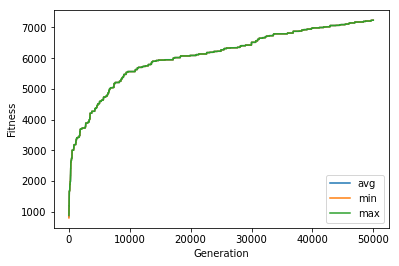

In [18]:
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="avg")
plt.plot(gen, min_, label="min")
plt.plot(gen, max_, label="max")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [19]:
solution.to_file('output/medium.txt')

In [20]:
a = np.ones((2, 3), dtype=int)
a.append()

AttributeError: 'numpy.ndarray' object has no attribute 'append'